# -----
# FIG 4 & 5 in RECCAP SO paper
# -----
# also included: panels b-c of Fig. S5
#
# same Figure layout as Fig. 2
# HERE: seasonal fluxes for 2015-2018
#
# Plot bars of climatolgical air-sea CO2 flux (all; ICE/SPSS/STSS)
# Plot zonal avg of climatolgical air-sea CO2 flux
# Plot maps of climatolgical air-sea CO2 flux
# Note: AOML is not considered in multi-data-product mean
# Note: MPI is not shown  
#
# Contact: cara.nissen@awi.de or cara.nissen@colorado.edu
#
# version: August 2023
#

In [40]:
### modules
import os
import numpy as np
import seawater as sw
import matplotlib
import matplotlib.pyplot as plt
from netCDF4 import Dataset
from matplotlib import cm 
from datetime import date, timedelta
import copy
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter,
                                LatitudeLocator)
from cartopy.util import add_cyclic_point
import cartopy.feature as cfeature
import matplotlib.gridspec as gridspec
from djf_mean import djf_mean
from mam_mean import mam_mean
from jja_mean import jja_mean
from son_mean import son_mean

In [41]:
#-----
# SETTINGS
# define paths to all data
# define where to save plots (if any)
# define years to average over
#-----

# CHOOSE A SEASON: jja, son, djf, mam
season = 'son' 

# data sets
path1 = '/pscratch/sd/c/cnissen/RECCAPv2/'
path_models = path1+'reccap_submissions/download_20220124/Models/2D_CO2/' 
path_data   = path1+'reccap_submissions/download_20220124/Surface_CO2/'
path_atminv = path1+'reccap_submissions/download_20220124/Atmospheric_inversions/'
path_soccom = path1+'reccap_submissions/download_20220124/Surface_CO2/'
path_trend  = path1+'reccap_submissions/download_20220124/Models/Linear_trends/' 

# river flux adjustment
path_river  = path1+'masks_reccap/river_flux_adjustment/'

# path to RECCAP SO mask
path_mask = path1+'masks_reccap/'

#----
# specify years to average over
#----
# NOTE: the script is written to plot avrages over 2015-2018
#    the years are defined here for plot titles and filenames 
year1,year2 = 2015,2018 
eval_time   = np.arange(year1,year2+1) 

#----
# define simulation
#----
sim = 'A'

#----
# define where to save plots
#----
save_to_dir ='/global/cfs/cdirs/m4003/cnissen/Plots/RECCAPv2_SO_Paper/Figs_4_5/'+season+'/'
if not os.path.exists(save_to_dir):
    print ('Created '+save_to_dir)
    os.makedirs(save_to_dir)
    
save_to_dir2 =save_to_dir+'individual_maps/'
if not os.path.exists(save_to_dir2):
    print ('Created '+save_to_dir2)
    os.makedirs(save_to_dir2)
    

In [42]:
#-----
# define data sets to consider
#-----
# NOTE: there is 6 different atm. inversions in the provided file, only load the ones that start in 1990 for the bar plot
# NOTE: AOML has to be the first in the list! there is a few places where the exclusion of AOML is 
# hard-coded as "[1:]"

# variable name of interest
var = '2D_CO2'

models     = ('CCSM-WHOI','CESM-ETHZ','CNRM-ESM2-1','EC-Earth3','FESOM_REcoM_HR','FESOM_REcoM_LR',\
             'MOM6-Princeton','MPIOM-HAMOCC','MRI-ESM2-1','NorESM-OC1.2',\
             'ORCA025-GEOMAR','ORCA1-LIM3-PISCES','PlankTOM12','ROMS-SouthernOcean-ETHZ') 
models2     = ('CCSM-WHOI','CESM-ETHZ','CNRM-ESM2-1','EC-Earth3','FESOM_REcoM_HR','FESOM_REcoM_LR',\
             'MOM6-Princeton','MPIOM-HAMOCC','MRI-ESM2-1','NorESM-OC1.2',\
             'ORCA025-GEOMAR','ORCA1-LIM3-PISCES','PlankTOM12','ROMS-SO-ETHZ') 
ind_mpi = models.index("MPIOM-HAMOCC")
ind_not_mpi = [i for i, s in enumerate(models) if 'MPIOM-HAMOCC' not in s]
print ('Index of MPI:',ind_mpi)
print ('All inidces except MPI:',ind_not_mpi)
data_assim  = ('BSOSE','ECCO-Darwin')
data_ocim   = ('OCIM-v2014-CTL','OCIM-v2021')
#data_atminv = ['Atm_inv1','Atm_inv2','Atm_inv4']  #'Atm_inv3','Atm_inv5','Atm_inv6' -> start later than 1990
data_atminv = ['Atm_inv1','Atm_inv2','Atm_inv3','Atm_inv4','Atm_inv5','Atm_inv6'] # for 2015-2018, consider all 6
data_prod   = ('AOML_EXTRAT','CMEMS-LSCE-FFNN','CSIRML6','JenaMLS','JMAMLR',\
             'LDEO-HPD','NIES-ML3','OceanSODAETHZ','SOMFFN') 
data_watson = ['UOEX_Wat20']
soccom      = ('SOCCOM_Jena','SOCCOM_SOMFFN')

versionID_models     = ('20211125','v20211122','v20211208','v20220323','v20211119','v20211119',\
                       'v20220125','v20220110','v20220502','v20211125',\
                       'v20210804','v20211215','v20220404','v20220630') 
versionID_data_assim  = ('I134','v20210712')
versionID_data_ocim   = ('v20210607','v20210511')
versionID_data_atminv = ['v20211008']
versionID_data_prod   = ('v20211130','v20210709','v20211117','v20211126','v20211208',\
                       'v20211210','v20220222','v20211207','v20211121')
versionID_data_watson = ['v20211204']

# list of filenames for data products
filename_data_prod = ('fgco2_AOML_EXTRAT_1997-2020_v20211018.nc4',\
                      'fgco2_CMEMS-LSCE-FFNN_1985-2018_v20210709.nc',\
                      'fgco2_CSIRML6_1985-2018_v20211117.nc',\
                      'fgco2_JenaMLS_1985-2018_v20211126.nc',\
                      'fgco2_JMAMLR_1985-2019_v20211208.nc',\
                      'fgco2_LDEO_HPD_1985-2018_v20211210.nc',\
                      'fgco2_NIES-ML3_1980-2020_v20220222.nc',\
                      'fgco2_OceanSODAETHZ_1985-2018_v20211207.nc',\
                      'fgco2_MPI_SOMFFN_1982-2019_v20211121.nc')
filename_data_watson = ['fgco2_UOEX_Wat20_1985-2019_v20211204.nc']

subregions = ('STSS-Atl','STSS-Ind','STSS-Pac',\
              'SPSS-Atl','SPSS-Ind','SPSS-Pac',\
              'ICE-Atl','ICE-Ind','ICE-Pac','STSS','SPSS','ICE','all')   

print ('Models:',len(models),len(versionID_models))
print ('Data products:',len(data_prod),len(filename_data_prod))
print ('Data Watson2020:',len(data_watson),len(versionID_data_watson))
print ('Data assimilating models:',len(data_assim),len(versionID_data_assim))
print ('Data OCIM:',len(data_ocim),len(versionID_data_assim))
print ('Data ATM inversion:',len(data_atminv),len(versionID_data_atminv))


Index of MPI: 7
All inidces except MPI: [0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13]
Models: 14 14
Data products: 9 9
Data Watson2020: 1 1
Data assimilating models: 2 2
Data OCIM: 2 2
Data ATM inversion: 6 1


In [43]:
#----
# FUNCTIONS
#----

# transform longitude (e.g., go from -179.5:179.5 to 0.5:359.5)
def transform_lon_coord(data):
    # change lon coordinate in 2D array from 0-360 to -180:180
    # for 2D arrays: assume lon coordinate to be the 2nd dimension  
    # for 3D arrays: assume lon coordinate to be the 3rd dimension  
    if len(data.shape)==2:
        data_transformed          = np.empty_like(data)
        data_transformed[:,0:180] = data[:,180:]
        data_transformed[:,180:]  = data[:,0:180] 
    elif len(data.shape)==3:
        data_transformed          = np.empty_like(data)
        try:
            data_transformed[:,:,0:180] = data[:,:,180:]
            data_transformed[:,:,180:]  = data[:,:,0:180]
        except:
            data_transformed[:,0:180,:] = data[:,180:,:]
            data_transformed[:,180:,:]  = data[:,0:180,:] 
    elif len(data.shape)==4:
        data_transformed          = np.empty_like(data)
        data_transformed[:,0:180,:,:] = data[:,180:,:,:]
        data_transformed[:,180:,:,:]  = data[:,0:180,:,:] 
    elif len(data.shape)==1:
        data_transformed          = np.empty_like(data)
        data_transformed[0:180] = data[180:]
        data_transformed[180:]  = data[0:180]
    return data_transformed


In [44]:
#------
# load RECCAP mask for SO
# make sure region mask matches the submitted products in terms of longitude!
#------

# SO RECCAP regions
#reccap_mask_SO   = Dataset(path_mask+'RECCAP2_region_masks_all_v20221025.nc')
#regions          = reccap_mask_SO_2.variables['southern'][:,:] #"1.SO STSS, 2.SO SPSS, 3.SO ICE"
#lon_regions      = reccap_mask_SO_2.variables['lon'][:]
#print(np.min(lon_regions),np.max(lon_regions)) # lon should be from 0-360 (if it is from -180:180, use transform_lon_coord)
#print(np.min(regions_2),np.max(regions_2))

# SO RECCAP regions
reccap_mask_SO = Dataset(path_mask+'reccap_regions_SOsubs.nc')
regions        = reccap_mask_SO.variables['SO_basins_biomes'][:,:]
lon_regions    = reccap_mask_SO.variables['lon'][:]
print(np.min(lon_regions),np.max(lon_regions)) # lon should be from 0-360 (if it is from -180:180, use transform_lon_coord)

# lon in file is -180:180 -> want 0-360, so transform here
regions = transform_lon_coord(regions)
print(np.min(regions),np.max(regions))


-179.5 179.5
0.0 8.0


In [45]:
#-----
# load data
#-----       

# the code is identical to the one for Fig 2, except for the fact that I kick out
# some years and choose a season before computing the time average

years_kick_out = year1-1985
print ('Year1:',(year1))
print ('# of years to be kicked out:',(years_kick_out))
        
flux_models = np.nan*np.ones([180,360,len(models)])
for ii in range(0,len(models)):
    print ('Load '+models[ii])
    ff = Dataset(path_models+models[ii]+'_'+var+'_'+versionID_models[ii]+'/'+\
                    'fgco2_'+models[ii]+'_'+sim+'_1_gr_1980-2018_'+versionID_models[ii]+'.nc')
    data = np.squeeze(ff.variables['fgco2'][:,:,:])
    if models[ii] in ['CCSM-WHOI']: # kick out years 1958-1984
        data = -1*data[27*12:,:,:] # flip sign
    else: 
        data = data[5*12:,:,:] # kick out years 1980-1984
    if models[ii] in ['MPIOM-HAMOCC']: # kick out year 2019
        data = data[:-12,:,:]
    data = data[years_kick_out*12:,:,:]
    print (data.shape)
    data[data.mask==True]=np.nan
    data[data==0]=np.nan
    if season in ['djf']:
        data = djf_mean(data)
    elif season in ['mam']:
        data = mam_mean(data)
    elif season in ['jja']:
        data = jja_mean(data)
    elif season in ['son']:
        data = son_mean(data)
    flux_models[:,:,ii] = np.nanmean(data,axis=0)
    ff.close()
    del data


#-----
# data products
#-----
flux_data_products = np.nan*np.ones([180,360,len(data_prod)])
for ii in range(0,len(data_prod)):
    print ('Load '+data_prod[ii])
    ff = Dataset(path_data+data_prod[ii]+'_'+versionID_data_prod[ii]+'/'+\
                    filename_data_prod[ii])
    data = np.squeeze(ff.variables['fgco2'][:,:,:])
    if data_prod[ii] in ['AOML_RANDOMF','AOML_EXTRAT']: # get starting time of this product 
        # -> to get rid of incomplete year in beginning, find out exact start time first
        #time = np.squeeze(ff.variables['time'][:])
        #day = time[0]
        #start = date(1980,1,1)      # This is the "days since" part
        #delta = timedelta(day)     # Create a time delta object from the number of days
        #offset = start + delta      # Add the specified number of days to 1990
        #del time,day,start,delta,offset
        # delete first 4 entries!
        data = data[4:,:,:]
        data = data[:-24,:,:] # kick out 2019 & 2020    
    if data_prod[ii] in ['SOMFFN']: # reorganize dimensions to math the others
        data = np.transpose(data,[2,1,0])
        data = data[3*12:,:,:] # kick out 1982-1984
    if data_prod[ii] in ['NIES-ML3']: # reorganize dimensions to math the others
        data = np.transpose(data,[2,1,0])
        data = data[5*12:,:,:] # kick out 1980-1984
    if data_prod[ii] in ['JMAMLR']: 
        data = data[5*12:,:,:] # kick out 1980-1984 (filename suggests it starts in 1985, but timedim suggests otherwise)
    if data_prod[ii] in ['JMAMLR','NIES-nn','UOEX_WAT20','CSIRML6','SOMFFN']: # 1985-2019
        data = data[:-12,:,:] # kick out 2019
    if data_prod[ii] in ['NIES-ML3']: # 1985-2020
        data = data[:-24,:,:] # kick out 2019 & 2020
    if data_prod[ii] in ['NIES-nn','NIES-ML3']: # mask missing values
        data[data<-9999999]=np.nan
    if data_prod[ii] in ['AOML_RANDOMF','AOML_EXTRAT']: # kick out 16 yers
        data = data[(years_kick_out-13)*12:,:,:]
    else: # kick out 29 years if start year is 2014
        data = data[years_kick_out*12:,:,:]
    print (data.shape)
    if season in ['djf']:
        data = djf_mean(data)
    elif season in ['mam']:
        data = mam_mean(data)
    elif season in ['jja']:
        data = jja_mean(data)
    elif season in ['son']:
        data = son_mean(data)
    flux_data_products[:,:,ii] = np.nanmean(data,axis=0)     
    ff.close()
    del data

#-----
# data product: Watson
#-----
flux_data_watson = np.nan*np.ones([180,360,len(data_watson)])
for ii in range(0,len(data_watson)):
    print ('Load '+data_watson[ii])
    ff = Dataset(path_data+data_watson[ii]+'_'+versionID_data_watson[ii]+'/'+\
                    filename_data_watson[ii])
    ind_start_watson = 12*3 # skip first three years, i.e. 1985-1987 (wind climatology is used)
    data = np.squeeze(ff.variables['fgco2'][ind_start_watson:-12,:,:])  
    data = data[(years_kick_out-3)*12:,:,:] # kick out 3 years less because product starts in 1988
    print (data.shape)
    if season in ['djf']:
        data = djf_mean(data)
    elif season in ['mam']:
        data = mam_mean(data)
    elif season in ['jja']:
        data = jja_mean(data)
    elif season in ['son']:
        data = son_mean(data)
    flux_data_watson[:,:,ii] = np.nanmean(data,axis=0)
    ff.close()
    del data
    
#-----
# data-assimilating models 
#-----
flux_data_assim = np.nan*np.ones([180,360,len(data_assim)])
for ii in range(0,len(data_assim)):
    print ('Load '+data_assim[ii])
    ff = Dataset(path_models+data_assim[ii]+'_'+var+'_'+versionID_data_assim[ii]+'/'+\
                    'fgco2_'+data_assim[ii]+'_'+sim+'_1_gr_1980-2018_'+versionID_data_assim[ii]+'.nc')
    data = np.squeeze(ff.variables['fgco2'][:,:,:])
    if data_assim[ii] in ['ECCO-Darwin']: # flip longitudes
        data = transform_lon_coord(data) 
    if data_assim[ii] in ['BSOSE']: #2013-2019
        data = data[:-12,:,:] # kick out 2019
    if data_assim[ii] in ['ECCO-Darwin']:
        data = data[(years_kick_out-10)*12:,:,:]
    elif data_assim[ii] in ['BSOSE']:
        if year1==2014:
            data = data[12:,:,:]
        elif year1==2015:
            data = data[24:,:,:]
    print (data.shape)       
    if season in ['djf']:
        data = djf_mean(data)
    elif season in ['mam']:
        data = mam_mean(data)
    elif season in ['jja']:
        data = jja_mean(data)
    elif season in ['son']:
        data = son_mean(data)
    flux_data_assim[:,:,ii] = np.nanmean(data,axis=0)
    # for some products, change sign so that pos=into ocean
    if data_assim[ii] in ['BSOSE']:
        print ('Change sign')
        flux_data_assim[:,:,ii] = -1*flux_data_assim[:,:,ii] 
    ff.close()
    del data

#-----
# OCIM
#-----
flux_ocim = np.nan*np.ones([180,360,len(data_ocim)])
for ii in range(0,len(data_ocim)):
    print ('Load '+data_ocim[ii])
    ff = Dataset(path_models+data_ocim[ii]+'_'+var+'_'+versionID_data_ocim[ii]+'/'+\
                    'fgco2_'+data_ocim[ii]+'_'+sim+'_1_gr_1980-2018_'+versionID_data_ocim[ii]+'.nc')
    data = np.squeeze(ff.variables['fgco2'][:,:,:])
    data = data[5*12:,:,:] # kick out 1980-1984
    data = data[years_kick_out*12:,:,:] # kick out 1985-start_year
    print (data.shape)
    data[data.mask==True]=np.nan
    if season in ['djf']:
        data = djf_mean(data)
    elif season in ['mam']:
        data = mam_mean(data)
    elif season in ['jja']:
        data = jja_mean(data)
    elif season in ['son']:
        data = son_mean(data)
    flux_ocim[:,:,ii] = np.nanmean(data,axis=0)
    ff.close()
    del data

#-----
# atmospheric inversion
#-----
flux_atminv = np.nan*np.ones([180,360,len(data_atminv)])
for ii in range(0,len(data_atminv)):
    print ('Load '+data_atminv[ii])
    ff = Dataset(path_atminv+'GCP2021_inversions_for_RECCAP2_1x1_version1_1_20211122.nc') 
    # this file contains 6 products!
    ind_list = [0,1,2,3,4,5] #[0,1,3] # only load inv1, inv2, inv4 -> only these start in 1990
    data = np.squeeze(ff.variables['ocean_flux_NOT_adjusted'][ind_list[ii],:,:,:]) # 1990-2020, .mean(axis=0)
    data = data[:-24,:,:] # kick out 2019 & 2020
    data = data[(years_kick_out-5)*12:,:,:] # kick out 1985-start_year; atm inv start in 1990
    print (data.shape)
    data[data.mask==True]=np.nan
    data[data==0]=np.nan # set land to NaN
    if season in ['djf']:
        data = djf_mean(data)
    elif season in ['mam']:
        data = mam_mean(data)
    elif season in ['jja']:
        data = jja_mean(data)
    elif season in ['son']:
        data = son_mean(data)
    flux_atminv[:,:,ii] = np.nanmean(data,axis=0)
    print ('Change sign')
    flux_atminv[:,:,ii] = -1*flux_atminv[:,:,ii]
        
    ff.close()
    del data
print ('Transform longitude to 0:360')
flux_atminv = transform_lon_coord(flux_atminv)
    

Year1: 2015
# of years to be kicked out: 30
Load CCSM-WHOI
(36, 180, 360)
Load CESM-ETHZ
(48, 180, 360)
Load CNRM-ESM2-1


/global/u2/c/cnissen/scripts_reccap/son_mean.py:44: RuntimeWarning: Mean of empty slice
  var_son_mean[t,:,:] = np.nanmean(datamB, axis=0)
/tmp/ipykernel_1931503/2110638133.py:36: RuntimeWarning: Mean of empty slice
  flux_models[:,:,ii] = np.nanmean(data,axis=0)


(48, 180, 360)
Load EC-Earth3
(48, 180, 360)
Load FESOM_REcoM_HR
(48, 180, 360)
Load FESOM_REcoM_LR
(48, 180, 360)
Load MOM6-Princeton
(48, 180, 360)
Load MPIOM-HAMOCC
(48, 180, 360)
Load MRI-ESM2-1
(48, 180, 360)
Load NorESM-OC1.2
(48, 180, 360)
Load ORCA025-GEOMAR
(48, 180, 360)
Load ORCA1-LIM3-PISCES
(48, 180, 360)
Load PlankTOM12
(48, 180, 360)
Load ROMS-SouthernOcean-ETHZ
(48, 180, 360)
Load AOML_EXTRAT
(48, 180, 360)
Load CMEMS-LSCE-FFNN
(48, 180, 360)
Load CSIRML6


/tmp/ipykernel_1931503/2110638133.py:88: RuntimeWarning: Mean of empty slice
  flux_data_products[:,:,ii] = np.nanmean(data,axis=0)


(48, 180, 360)
Load JenaMLS
(48, 180, 360)
Load JMAMLR
(48, 180, 360)
Load LDEO-HPD
(48, 180, 360)
Load NIES-ML3


/tmp/ipykernel_1931503/2110638133.py:49: UserWarning: WARNING: _FillValue not used since it
cannot be safely cast to variable data type
  data = np.squeeze(ff.variables['fgco2'][:,:,:])


(48, 180, 360)
Load OceanSODAETHZ
(48, 180, 360)
Load SOMFFN
(48, 180, 360)
Load UOEX_Wat20
(48, 180, 360)
Load BSOSE
(48, 180, 360)
Change sign
Load ECCO-Darwin


/tmp/ipykernel_1931503/2110638133.py:112: RuntimeWarning: Mean of empty slice
  flux_data_watson[:,:,ii] = np.nanmean(data,axis=0)


(48, 180, 360)
Load OCIM-v2014-CTL


/tmp/ipykernel_1931503/2110638133.py:145: RuntimeWarning: Mean of empty slice
  flux_data_assim[:,:,ii] = np.nanmean(data,axis=0)


(36, 180, 360)
Load OCIM-v2021


/tmp/ipykernel_1931503/2110638133.py:174: RuntimeWarning: Mean of empty slice
  flux_ocim[:,:,ii] = np.nanmean(data,axis=0)


(48, 180, 360)
Load Atm_inv1
(48, 180, 360)


/tmp/ipykernel_1931503/2110638133.py:201: RuntimeWarning: Mean of empty slice
  flux_atminv[:,:,ii] = np.nanmean(data,axis=0)


Change sign
Load Atm_inv2
(48, 180, 360)
Change sign
Load Atm_inv3
(48, 180, 360)
Change sign
Load Atm_inv4
(48, 180, 360)
Change sign
Load Atm_inv5
(48, 180, 360)
Change sign
Load Atm_inv6
(48, 180, 360)
Change sign
Transform longitude to 0:360


In [46]:
#------
# print some numbers (to spot any obvious unit problems)
#------

print(season)
print()

for ii in range(0,len(models)):
    print (models[ii]+' min/max: '+str(np.nanmin(flux_models[:,:,ii]))+' '+str(np.nanmax(flux_models[:,:,ii])))

for ii in range(0,len(data_prod)):
    print (data_prod[ii]+': '+str(np.nanmin(flux_data_products[:,:,ii]))+' '+str(np.nanmax(flux_data_products[:,:,ii])))

for ii in range(0,len(data_watson)):
    print (data_watson[ii]+': '+str(np.nanmin(flux_data_watson[:,:,ii]))+' '+str(np.nanmax(flux_data_watson[:,:,ii])))
    
for ii in range(0,len(data_assim)):
    print (data_assim[ii]+': '+str(np.nanmin(flux_data_assim[:,:,ii]))+' '+str(np.nanmax(flux_data_assim[:,:,ii])))

for ii in range(0,len(data_ocim)):
    print (data_ocim[ii]+': '+str(np.nanmin(flux_ocim[:,:,ii]))+' '+str(np.nanmax(flux_ocim[:,:,ii])))

# DIFFERENT UNIT than all others -> take that into account further down
for ii in range(0,len(data_atminv)):
    print (data_atminv[ii]+': '+str(np.nanmin(flux_atminv[:,:,ii]))+' '+str(np.nanmax(flux_atminv[:,:,ii])))

# SON: UOEX_Wat20: -3.02840037168e-07 2.38750811836e-07
# SON here: -1.946237913625748e-07 2.740566915692194e-07


son

CCSM-WHOI min/max: -3.0547543398521765e-07 2.581609095386739e-07
CESM-ETHZ min/max: -1.5102099126806934e-07 2.4027770706425144e-07
CNRM-ESM2-1 min/max: -2.282642142433418e-07 6.417775007415571e-07
EC-Earth3 min/max: -3.6565023719958845e-07 2.3057964071426795e-07
FESOM_REcoM_HR min/max: -1.1824950285975596e-06 2.907630718778292e-07
FESOM_REcoM_LR min/max: -3.5527283734992546e-07 2.7089597469012367e-07
MOM6-Princeton min/max: -6.146989267534361e-07 9.346812281509382e-07
MPIOM-HAMOCC min/max: -1.7712754640797357e-07 3.52072760279043e-07
MRI-ESM2-1 min/max: -7.094083542824592e-07 2.61544663260338e-07
NorESM-OC1.2 min/max: -2.530342513296091e-07 2.7279986625217134e-07
ORCA025-GEOMAR min/max: -5.939601164905096e-07 3.93615291063983e-07
ORCA1-LIM3-PISCES min/max: -4.462191682819139e-07 2.2401022192752862e-07
PlankTOM12 min/max: -4.3088583367989486e-07 1.6010807257771376e-07
ROMS-SouthernOcean-ETHZ min/max: -1.742324204911938e-07 4.5369573342668446e-07
AOML_EXTRAT: -1.3063666948198716e-07

In [47]:
#------
# get surface area of all the biomes
#------
# calculate area with sw.dist

def get_areas_biomes(area,regions,subregions):
    # calculate area-weighted averages of a given quantity in data according to biomes defined
    # after Fay & McKinley (2014), use RECCAP mask loaded further up
    # provide "area" (with lon from 0:360)
    
    # only consider area for SO RECCAP mask
    area[regions.mask==True]=0
    print ('Total Southern Ocean ocean surface area '+str(np.nansum(area))+' m2')
    
    data_avg = np.zeros(13) # 9 regions in SO, + 3 for combined sectors, +1 for whole SO
    for i in range(0,13):
        reg2  = regions.ravel()
        area2 = area.ravel()
        if subregions[i] in ['STSS-Atl']:
            ind_region = np.where(reg2==0)[0]
        elif subregions[i] in ['STSS-Ind']:
            ind_region = np.where(reg2==3)[0]
        elif subregions[i] in ['STSS-Pac']:
            ind_region = np.where(reg2==6)[0]
        elif subregions[i] in ['SPSS-Atl']:
            ind_region = np.where(reg2==1)[0]
        elif subregions[i] in ['SPSS-Ind']:
            ind_region = np.where(reg2==4)[0]
        elif subregions[i] in ['SPSS-Pac']:
            ind_region = np.where(reg2==7)[0]
        elif subregions[i] in ['ICE-Atl']:
            ind_region = np.where(reg2==2)[0]
        elif subregions[i] in ['ICE-Ind']:
            ind_region = np.where(reg2==5)[0]
        elif subregions[i] in ['ICE-Pac']:
            ind_region = np.where(reg2==8)[0]
        elif subregions[i] in ['STSS']:
            ind_region = np.where((reg2==0) | (reg2==3) | (reg2==6))[0]
        elif subregions[i] in ['SPSS']:
            ind_region = np.where((reg2==1) | (reg2==4) | (reg2==7))[0]
        elif subregions[i] in ['ICE']:
            ind_region =np.where((reg2==2) | (reg2==5) | (reg2==8))[0]
        elif subregions[i] in ['all']:
            ind_region = np.where(reg2>=0)[0]
        data_avg[i] = np.nansum(area2[ind_region]) #np.nansum(data2[ind_region]*area2[ind_region]/total_area)
        del reg2, area2,ind_region
    return data_avg

# define for filtering, but don't use for area calculation
lon = np.arange(0.5,359.5+1,1)
lat = np.arange(-89.5,89.5+1,1)

# need the box boundaries for area calculation
xi = np.arange(0,360+1,1)
yi = np.arange(-90,90+1,1) 

area = np.zeros((len(xi)-1,len(yi)-1))
#calculate area
for i in range(0,len(xi)-1): #laenge pruefen!
    if i==np.round(len(xi)/2): 
        print ('50% done')
    for j in range(0,len(yi)-1): 
        dist1 = sw.dist([yi[j],yi[j+1]],[xi[i],xi[i]])
        dist2 = sw.dist([yi[j],yi[j]],[xi[i],xi[i+1]])
        area[i][j] = float(dist1[0]) * float(dist2[0]) *1000 *1000 #m2
area = area.transpose()
print ('Global area:',np.sum(area),'m2') 
area_global = np.copy(area)

area_biomes = get_areas_biomes(area,regions,subregions)

#print (area_biomes)
print('TEST: the following three should be identical')
print (np.sum(area_biomes[0:9])) # 9 subregions
print (np.sum(area_biomes[9:12])) # 3 subregions
print (np.sum(area_biomes[12])) # 1 subregion 


50% done
Global area: 509364377985322.94 m2
Total Southern Ocean ocean surface area 77409028462219.4 m2
TEST: the following three should be identical
77409028462219.4
77409028462219.42
77409028462219.42


In [48]:
#-----
# get multi-model and multi-data mean
#-----
# do not include MPI!!

# unit conversion: from mol C m-2 s-1 to mol C m-2 yr-1
factor = 86400.*365.25

# fill land
fill_value = -999

#multi_model_mean      = np.nanmean(flux_models,axis=2)
multi_model_mean      = np.nanmean(flux_models[:,:,ind_not_mpi],axis=2)
multi_model_mean      = factor*multi_model_mean
multi_model_mean[np.isnan(multi_model_mean)]=fill_value
    
# NOTE: note the hard-coded index here! This assumes AOML to be the first entry int he list of products!
print ('exclude AOML (starts later) from multi-data product mean')
multi_data_prod_mean  = np.nanmean(flux_data_products[:,:,1:],axis=2) # leave out AOML_EXTRAT (starts later)
multi_data_prod_mean  = factor*multi_data_prod_mean
multi_data_prod_mean[np.isnan(multi_data_prod_mean)]=fill_value
multi_data_prod_mean[multi_data_prod_mean==0]=fill_value
    
multi_data_watson_mean  = np.nanmean(flux_data_watson,axis=2)
multi_data_watson_mean  = factor*multi_data_watson_mean
multi_data_watson_mean[np.isnan(multi_data_watson_mean)]=fill_value
    
multi_data_assim_mean = np.nanmean(flux_data_assim,axis=2)
multi_data_assim_mean = factor*multi_data_assim_mean
multi_data_assim_mean[np.isnan(multi_data_assim_mean)]=fill_value
multi_data_assim_mean[multi_data_assim_mean==0]=fill_value
# B-SOSE
BSOSE_mean = np.copy(flux_data_assim[:,:,0])
BSOSE_mean = factor*BSOSE_mean
BSOSE_mean[np.isnan(BSOSE_mean)]=fill_value
BSOSE_mean[BSOSE_mean==0]=fill_value
    
multi_ocim_mean  = np.nanmean(flux_ocim,axis=2)
multi_ocim_mean  = factor*multi_ocim_mean
multi_ocim_mean[np.isnan(multi_ocim_mean)]=fill_value
    
multi_atminv_mean  = np.nanmean(flux_atminv,axis=2)
multi_atminv_mean  = factor*multi_atminv_mean
multi_atminv_mean[np.isnan(multi_atminv_mean)]=fill_value 
    

exclude AOML (starts later) from multi-data product mean


/tmp/ipykernel_1931503/1536995648.py:13: RuntimeWarning: Mean of empty slice
  multi_model_mean      = np.nanmean(flux_models[:,:,ind_not_mpi],axis=2)
/tmp/ipykernel_1931503/1536995648.py:19: RuntimeWarning: Mean of empty slice
  multi_data_prod_mean  = np.nanmean(flux_data_products[:,:,1:],axis=2) # leave out AOML_EXTRAT (starts later)
/tmp/ipykernel_1931503/1536995648.py:24: RuntimeWarning: Mean of empty slice
  multi_data_watson_mean  = np.nanmean(flux_data_watson,axis=2)
/tmp/ipykernel_1931503/1536995648.py:38: RuntimeWarning: Mean of empty slice
  multi_ocim_mean  = np.nanmean(flux_ocim,axis=2)
/tmp/ipykernel_1931503/1536995648.py:42: RuntimeWarning: Mean of empty slice
  multi_atminv_mean  = np.nanmean(flux_atminv,axis=2)


In [49]:
#----
# load SOCCOM files from Seth
#----

ff = Dataset(path_soccom+'RECCAP_regrid_Jena_CS.nc')
soccom1 = ff.variables['F_CO2'][:] 
time1 = ff.variables['time'][:] # starts in Jan 1957, ends in Dec 2020
ff.close()
ff = Dataset(path_soccom+'RECCAP_regrid_SOM_FFN.nc')
soccom2 = ff.variables['F_CO2'][:]
time2 = ff.variables['time'][:] # starts in Jan 1982, ends in Dec 2019
ff.close()
print (soccom1.shape,soccom2.shape)

start = date(1950,1,1)      # This is the "days since" part
offset1 = start + timedelta(time1[0])      # Add the specified number of days to 1990
offset2 = start + timedelta(time2[0])      # Add the specified number of days to 1990
print(offset1) 
print(offset2) 

end1 = start + timedelta(time1[-1])      # Add the specified number of days to 1990
end2 = start + timedelta(time2[-1])      # Add the specified number of days to 1990
print(end1) 
print(end2) 

# reduce data to Jan-2015 until Dec-2018
soccom1 = soccom1[(30+28)*12:-24,:,:]
soccom2 = soccom2[(30+3)*12:-12,:,:]
print (soccom1.shape,soccom2.shape )

# avg over the chosen season
if season in ['djf']:
    soccom1 = djf_mean(soccom1)
    soccom2 = djf_mean(soccom2)
elif season in ['mam']:
    soccom1 = mam_mean(soccom1)
    soccom2 = mam_mean(soccom2)
elif season in ['jja']:
    soccom1 = jja_mean(soccom1)
    soccom2 = jja_mean(soccom2)
elif season in ['son']:
    soccom1 = son_mean(soccom1) 
    soccom2 = son_mean(soccom2) 
print (soccom1.shape,soccom2.shape )

# avg over the whole time
soccom1 = np.nanmean(soccom1,axis=0)
soccom2 = np.nanmean(soccom2,axis=0)

# to get rid of some grey lines in plotting:
soccom1[:,-2] = soccom1[:,-3]
soccom1[:,-1] = soccom1[:,-2]
soccom1[:,1] = soccom1[:,2]
soccom1[:,0] = soccom1[:,1]

# for avg map
soccom_mean_map = np.nanmean(np.dstack((soccom1,soccom2)),axis=2)


(768, 180, 360) (456, 180, 360)
1957-01-15
1982-01-15
2020-12-15
2019-12-15
(48, 180, 360) (48, 180, 360)
(4, 180, 360) (4, 180, 360)


/tmp/ipykernel_1931503/452361583.py:47: RuntimeWarning: Mean of empty slice
  soccom1 = np.nanmean(soccom1,axis=0)
/tmp/ipykernel_1931503/452361583.py:48: RuntimeWarning: Mean of empty slice
  soccom2 = np.nanmean(soccom2,axis=0)
/tmp/ipykernel_1931503/452361583.py:57: RuntimeWarning: Mean of empty slice
  soccom_mean_map = np.nanmean(np.dstack((soccom1,soccom2)),axis=2)


[1.0 2.0 3.0 --]
-179.5 180.5


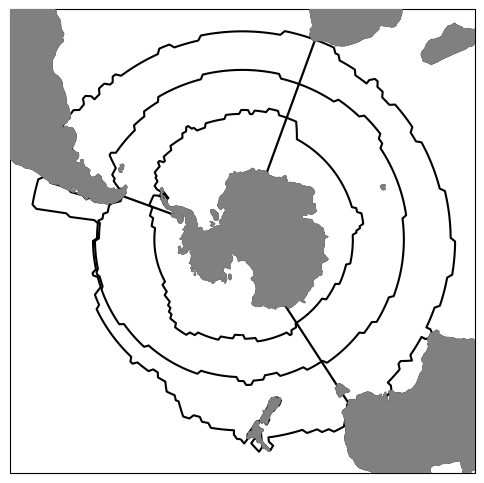

In [50]:
#-----
# test plot for contour lines of biomes
#-------

# lat/lon on RECCAP mesh
lon = np.arange(0.5,359.5+1,1)
lat = np.arange(-89.5,89.5+1,1)

# lon,lat for plotting
xax_X = transform_lon_coord(lon)
xax_X[xax_X>180] = xax_X[xax_X>180]-360 # lon now runs from -179.5:179.5
X, Y  = np.meshgrid(xax_X, lat) 
X = add_cyclic_point(X)
X[:,-1] = 180.5 # -> cannot be -179.5 or the plot will look weird
Y = add_cyclic_point(Y)
    
r_mask = np.copy(regions)
r_mask = transform_lon_coord(regions) 
r_mask = np.ma.masked_where(np.isnan(r_mask),r_mask)
# repeat first element at the end to get rid of grey line in plot
b = np.zeros((180,360+1))
b[:,:-1] = r_mask
b[:,-1] = r_mask[:,0]
r_mask = b

# create the corresponding mask with only 3 regions
r_mask2 = np.zeros_like(r_mask)
r_mask2[r_mask==0]=1
r_mask2[r_mask==3]=1
r_mask2[r_mask==6]=1
r_mask2[r_mask==1]=2
r_mask2[r_mask==4]=2
r_mask2[r_mask==7]=2
r_mask2[r_mask==2]=3
r_mask2[r_mask==5]=3
r_mask2[r_mask==8]=3
r_mask2 = np.ma.masked_where(r_mask2==0,r_mask2)
print(np.unique(r_mask2))
print(np.min(X),np.max(X))

# correct contour lines near Antarctica (don't want it plotted)
r_mask3 = np.copy(r_mask2)
r_mask3[0:23,:]=np.nan
r_mask3[0:26,200:340]=np.nan
r_mask3 = np.ma.masked_where(np.isnan(r_mask3),r_mask3)

#---
# on a map
#---
fig = plt.figure(figsize=(6,12))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.SouthPolarStereo()) #
#ax = plt.axes(projection=ccrs.PlateCarree())
#ax.stock_img()
ax.coastlines()
ax.set_extent([-180,180, -90, -30],ccrs.PlateCarree())

lw = 1.5
cnt=plt.contour(X,Y,r_mask3,levels=[0,1,2,3],colors=['k','k','k'],linewidths=[lw,lw,lw,lw],transform=ccrs.PlateCarree())

plot_lon_lines = True
if plot_lon_lines:
    # draw longitudinal contours: 70W, 20E, 147E
    lw = 1.6
    lon1, lon2 = 20,20
    lat1, lat2 = -70,-35
    ax.plot([lon1, lon2], [lat1, lat2],color='k',linewidth=lw,transform=ccrs.Geodetic())
    lon1, lon2 = 147,147
    lat1, lat2 = -70,-39
    ax.plot([lon1, lon2], [lat1, lat2],color='k',linewidth=lw,transform=ccrs.Geodetic())
    lon1, lon2 = -70,-70
    lat1, lat2 = -70,-55
    ax.plot([lon1, lon2], [lat1, lat2],color='k',linewidth=lw,transform=ccrs.Geodetic())

ax.add_feature(cartopy.feature.LAND,color='grey',zorder=50)
plt.show()



In [51]:
#----
# FUNCTIONS
#----

def get_data_plot(data_input,levels):
    # data to plot
    data_plot = np.copy(-1*data_input)
    data_plot = transform_lon_coord(data_plot) 
    b = np.zeros((180,360+1))
    b[:,:-1] = data_plot
    b[:,-1]  = data_plot[:,0]
    data_plot = b
    #------
    mask = (data_plot>levels[-1]) & (data_plot<990)
    data_plot[mask] = levels[-1]
    return data_plot
    
#def plot_map(ax,X,Y,data_plot,levels,colormap,color_continents,lineslonlat,xlin,ylin): 
#    color_no_SO = 'gainsboro'
#    map = Basemap(projection='spstere',boundinglat=-30,lon_0=-180,resolution='l',ax=ax)
#    x, y = map(X,Y)
#    mm=ax.contourf(x, y, data_plot, levels=levels, cmap=colormap, extend='both') 
#    cbar=plt.colorbar(mm, ax=ax,orientation='horizontal',shrink=0.5,pad=0.05) #fraction=0.075, pad=0.15,shrink=1.0
#    #cbar.cmap.set_over(color_continents)
#    cbar.cmap.set_under(color_no_SO)
#    cbar.remove()
#    fig.canvas.draw_idle() #plt.draw() does not work
#    for lin in range(len(lineslonlat)): # Plot biome boundaries from file with lines:
#        ax.plot(xlin[lin],ylin[lin], color='black', linestyle='-',linewidth=0.1,zorder=1)
#    #map.drawmapboundary(fill_color=color_continents,zorder=30) 
#    map.fillcontinents(color=color_continents,lake_color=color_continents)
#    return mm
    
    
def add_annotations_to_plot(ax,plot_title1,plot_title2,panel_label,fs_text,color_text):
    bbox_props = dict(boxstyle="square,pad=0.25", fc="white", ec="white", lw=1) # fc=frontcolor, ec=edgecolor
    ax.annotate(panel_label+'  ', xy=(0.015,1.035), xycoords='axes fraction',color='black',\
                        fontweight='bold',fontsize=fs_text,bbox=bbox_props) # 0.95
    ax.annotate(plot_title1, xy=(0.088,1.035), xycoords='axes fraction',color=color_text,\
                        fontweight='bold',fontsize=fs_text,bbox=bbox_props)
    ax.annotate(plot_title2, xy=(0.02,0.03), xycoords='axes fraction',color='black',\
                        fontweight='bold',fontsize=fs_text,bbox=bbox_props) #(0.01,0.025)
    

In [52]:
#-----
# settings for all plots
#-----
dpicnt      = 400

# colormap
colormap = copy.copy(plt.cm.RdBu_r)

#colormap.set_under('gainsboro')
#colormap    = cm.RdBu_r

levels      = np.arange(-4.0,4.25,0.25)
fs_label    = 14
fs_text     = 5
color_continents = 'grey'
label_colorbar   = 'FCO$_{2}$ (mol C m$^{-2}$ yr$^{-1}$)'
#label_colorbar   = 'CO$_{2}$ flux in mol C m$^{-2}$ yr$^{-1}$'

color_models      = 'C2'
color_data        = 'C0'
color_data_assim  = 'grey'
color_watson      = 'lightsteelblue'
color_data_assim1 = 'dimgrey'
color_data_assim2 = 'darkgrey'

# lon,lat for plotting
xax_X = transform_lon_coord(lon)
xax_X[xax_X>180] = xax_X[xax_X>180]-360 # lon now runs from -179.5:179.5
X, Y  = np.meshgrid(xax_X, lat) 
X = add_cyclic_point(X)
X[:,-1] = 180.5 # -> cannot be -179.5 or the plot will look weird
Y = add_cyclic_point(Y)

lon_to_nc = np.copy(xax_X)
lon_to_nc[lon_to_nc>180] = lon_to_nc[lon_to_nc>180]-360
    

test plot...


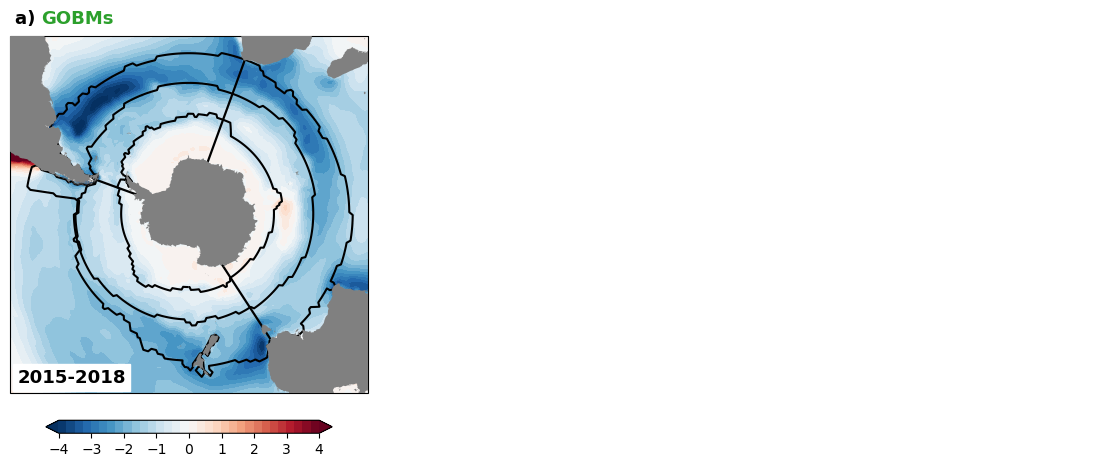

In [53]:
#-----
# test plot
#-----

plot_test = True
if plot_test:
    print('test plot...')

    ## Transform lines to map coordinates (loop line-by-line):
    #xlin=[]; ylin=[]
    #for lin in range(len(lineslonlat)):
    #    x, y = map(lineslonlat[lin][0,:],lineslonlat[lin][1,:],transform=ccrs.Geodetic())
    #    xlin.append(x); ylin.append(y)

    # data to plot
    data_plot = np.copy(-1*multi_model_mean)
    data_plot = transform_lon_coord(data_plot) # transform for plotting (-> -179:179)
    data_plot = add_cyclic_point(data_plot)
    
    
    fig = plt.figure(figsize=(12,6))
    ax1 = fig.add_subplot(1, 3, 1, projection=ccrs.SouthPolarStereo()) #projection=ccrs.PlateCarree())
    ax2 = fig.add_subplot(1, 3, 2, projection=ccrs.SouthPolarStereo())
    ax3 = fig.add_subplot(1, 3, 3, projection=ccrs.SouthPolarStereo())
    fig.subplots_adjust(bottom=0.05, top=0.95,
                        left=0.04, right=0.95, wspace=0.025)
    
    ax1.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())
    ax2.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())
    ax3.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())
    
    data_plot = np.ma.masked_where(data_plot>990,data_plot)
    mm=ax1.contourf(X,Y, data_plot, levels=levels, cmap=colormap, extend='both',transform=ccrs.PlateCarree()) 
    cbar=plt.colorbar(mm, ax=ax1,orientation='horizontal',shrink=0.8,pad=0.05) #fraction=0.075, pad=0.15,shrink=1.0

    #---
    # plot outlines of biomes
    #---
    lw = 1.5
    cnt=ax1.contour(X,Y,r_mask3,levels=[0,1,2,3],colors=['k','k','k'],linewidths=[lw,lw,lw,lw],transform=ccrs.PlateCarree())
    # draw longitudinal contours: 70W, 20E, 147E
    lw = 1.6
    lon1, lon2 = 20,20
    lat1, lat2 = -70,-35
    ax1.plot([lon1, lon2], [lat1, lat2],color='k',linewidth=lw,transform=ccrs.Geodetic())
    lon1, lon2 = 147,147
    lat1, lat2 = -70,-39
    ax1.plot([lon1, lon2], [lat1, lat2],color='k',linewidth=lw,transform=ccrs.Geodetic())
    lon1, lon2 = -70,-70
    lat1, lat2 = -70,-55
    ax1.plot([lon1, lon2], [lat1, lat2],color='k',linewidth=lw,transform=ccrs.Geodetic())
    
    ax1.add_feature(cfeature.GSHHSFeature('low'), zorder=50, edgecolor=None, facecolor=color_continents)
    ax1.plot([180, 180], [-90, -79],
                 zorder=3, color=color_continents,
                 linewidth=3,
                 transform=ccrs.PlateCarree()) 
    ax1.plot([0, 0], [-90, -70.9],
                 zorder=3, color=color_continents,
                 linewidth=3,
                 transform=ccrs.PlateCarree()) 
    
    # ax1.add_feature(cartopy.feature.LAND,color=color_continents,zorder=50)
    #ax2.add_feature(cartopy.feature.LAND,color=color_continents,zorder=50)
    #ax3.add_feature(cartopy.feature.LAND,color=color_continents,zorder=50)
    
    plot_title2a = '2015-2018' # years
    panel_label_a = 'a)'
    plot_title1a = 'GOBMs'
    add_annotations_to_plot(ax1,plot_title1a,plot_title2a,panel_label_a,13,color_models)
    
    ax=ax2
    ax.set_axis_off()
    ax=ax3
    ax.set_axis_off()

    plt.show()


In [54]:
#----
# FUNCTIONS to save netcdf files
#----

#-----
# save multi-model mean and multi-data product mean as netcdf
#-----
def save_field_as_netcdf(data,lat,lon,which_var,save_netcdf):
    # inputs are as the fields that are plotted for Fig. 2
    
    #save_netcdf = True
    if save_netcdf:
        savepath = '/pscratch/sd/c/cnissen/RECCAPv2/reccap_submissions/download_20220124/ARCHIVE/'
        source = '/global/homes/c/cnissen/scripts_reccap/PAPER_RECCAPv2_SO_Fig4_5.ipynb'

        if which_var in ['data_products']:
            prod_name = 'pCO2_products'
        elif which_var in ['models']:
            prod_name = 'GOBMs'
            
        netcdf_name = 'RECCAPv2_SO_CO2_flux_fields_avg_2015_2018_'+season+'_'+prod_name+'.nc'
        
        if not os.path.exists(savepath+netcdf_name):
            print ('Create file '+savepath+netcdf_name)
            w_nc_fid = Dataset(savepath+netcdf_name, 'w', format='NETCDF4_CLASSIC')
            # create dimension & variable
            w_nc_fid.createDimension('lat', len(lat)) 
            w_nc_fid.createDimension('lon', len(lon)) 
            w_nc_fid.all_GOBMs = 'CCSM-WHOI, CESM-ETHZ, CNRM-ESM2-1, EC-Earth3, FESOM_REcoM_HR, '+\
            'FESOM_REcoM_LR, MOM6-Princeton, MPI-HAMOCC, MRI-ESM2-1, NorESM-OC1.2,'+\
            'ORCA025-GEOMAR, ORCA1-LIM3-PISCES, PlankTOM12, ROMS-SouthernOcean-ETHZ'
            w_nc_fid.all_data_products = 'AOML_EXTRAT,CMEMS-LSCE-FFNN, CSIRML6, JenaMLS, JMAMLR, LDEO-HPD, NIES-ML3, OceanSODAETHZ, SOMFFN'
            #w_nc_fid.all_data_assim = 'B-SOSE, ECCO-DARWIN'
            #w_nc_fid.all_atm_inv = 'CAMS v20r2, sEXTocNEET v2021, NISMON-CO2 (Atm 1, 2 & 4 in original RECCAP file)'
            w_nc_fid.sign_convention = 'pos=outgassing, neg=uptake'
            w_nc_fid.script = source
            w_nc_fid.contact = 'cara.nissen@colorado.edu'
            
            w_nc_fid.createVariable('lat', 'f4',('lat'))
            w_nc_fid.createVariable('lon', 'f4',('lon'))

            w_nc_fid.variables['lat'][:] = lat
            w_nc_fid.variables['lon'][:] = lon
            
            w_nc_fid.close()
            
        w_nc_fid = Dataset(savepath+netcdf_name, 'r+', format='NETCDF4_CLASSIC')      # Create and open new netcdf file to write to
        
    #CAMS v20r2: Frederic Chevallier: frederic.chevallier@lsce.ipsl.fr
    #sEXTocNEET v2021: Christian Roedenbeck: christian.roedenbeck@bgc-jena.mpg.de
    #CTE2021: Ingrid Luijkx: ingrid.luijkx@wur.nl
    #NISMON-CO2: Yosuke Niwa: niwa.yosuke@nies.go.jp
    #CMS-Flux: Junjie Liu: junjie.liu@jpl.nasa.gov
    #UoE: Liang Feng: liang.feng@ed.ac.uk\n" 
    
        fv = 999
        print (np.min(data),np.max(data))

        if which_var in ['data_products']:
            w_nc_var1 = w_nc_fid.createVariable('fgco2_data_prod_mean', 'f4',('lat','lon'),fill_value=fv)
            w_nc_var1.units = 'mol C m-2 yr-1' 
            w_nc_var1.description = 'multi-data product mean CO2 flux 2015-2018'
            w_nc_var1.note = 'AOML_EXTRAT not considered in data-product mean (only starts in 1995)'
            w_nc_fid.variables['fgco2_data_prod_mean'][:] = data
        
        if which_var in ['models']:
            w_nc_var1 = w_nc_fid.createVariable('fgco2_GOBMs_mean', 'f4',('lat','lon'),fill_value=fv)
            w_nc_var1.units = 'mol C m-2 yr-1' 
            w_nc_var1.description = 'multi-model mean CO2 flux 2015-2018'
            w_nc_fid.variables['fgco2_GOBMs_mean'][:] = data
        
        w_nc_fid.close() 
    
        print ('Successfully saved '+netcdf_name)
        
#-----
# save individual models & products as netcdf
#-----
def save_individual_field_as_netcdf(mm,data,lat,lon,which_var,list_names,save_netcdf,netcdf_name):
    # inputs are as the fields that are plotted for Fig. 2
    
    #save_netcdf = True
    if save_netcdf:
        savepath = '/pscratch/sd/c/cnissen/RECCAPv2/reccap_submissions/download_20220124/ARCHIVE/'
        source = '/global/homes/c/cnissen/scripts_reccap/PAPER_RECCAPv2_SO_Fig4_5.ipynb'

        if not os.path.exists(savepath+netcdf_name):
            print ('Create file '+savepath+netcdf_name)
            w_nc_fid = Dataset(savepath+netcdf_name, 'w', format='NETCDF4_CLASSIC')
            # create dimension & variable
            w_nc_fid.createDimension('lat', len(lat)) 
            w_nc_fid.createDimension('lon', len(lon)) 
            w_nc_fid.all_GOBMs = 'CCSM-WHOI, CESM-ETHZ, CNRM-ESM2-1, EC-Earth3, FESOM_REcoM_HR, '+\
            'FESOM_REcoM_LR, MOM6-Princeton, MPI-HAMOCC, MRI-ESM2-1, NorESM-OC1.2,'+\
            'ORCA025-GEOMAR, ORCA1-LIM3-PISCES, PlankTOM12, ROMS-SouthernOcean-ETHZ'
            w_nc_fid.all_data_products = 'CMEMS-LSCE-FFNN, CSIRML6, JenaMLS, JMAMLR, LDEO-HPD, NIES-ML3, OceanSODAETHZ, SOMFFN'
            #w_nc_fid.all_data_assim = 'B-SOSE, ECCO-DARWIN'
            #w_nc_fid.all_atm_inv = 'CAMS v20r2, sEXTocNEET v2021, NISMON-CO2 (Atm 1, 2 & 4 in original RECCAP file)'
            #w_nc_fid.note = 'AOML_EXTRAT missing for data products, MPIOM-HAMOCC missing for models'
            w_nc_fid.sign_convention = 'pos=outgassing, neg=uptake'
            w_nc_fid.script = source
            
            w_nc_fid.createVariable('lat', 'f4',('lat'))
            w_nc_fid.createVariable('lon', 'f4',('lon'))

            w_nc_fid.variables['lat'][:] = lat
            w_nc_fid.variables['lon'][:] = lon
            
            w_nc_fid.close()
            
        w_nc_fid = Dataset(savepath+netcdf_name, 'r+', format='NETCDF4_CLASSIC')      # Create and open new netcdf file to write to
        
        fv = 999
        print (np.min(data),np.max(data))

        if which_var in ['data_products']:
            try:
                w_nc_fid.createDimension('num_data_prod', len(list_names)) 
            except:
                pass
            try:
                w_nc_var1 = w_nc_fid.createVariable('fgco2_data_prod', 'f4',('num_data_prod','lat','lon'),fill_value=fv)
                w_nc_var1.units = 'mol C m-2 yr-1' 
                w_nc_var1.description = 'mean CO2 flux 2015-2018 for individual pCO2-products'
                w_nc_var1.note = 'AOML 1995-2018 only'
            except:
                pass
            
            w_nc_fid.variables['fgco2_data_prod'][mm,:,:] = data
        
        
        if which_var in ['models']:
            try:
                w_nc_fid.createDimension('num_GOBMs', len(list_names)) 
            except:
                pass
            try:
                w_nc_var1 = w_nc_fid.createVariable('fgco2_GOBMs', 'f4',('num_GOBMs','lat','lon'),fill_value=fv)
                w_nc_var1.units = 'mol C m-2 yr-1' 
                w_nc_var1.description = 'mean CO2 flux 2015-2018 for individual models'
            except:
                pass
            
            
            w_nc_fid.variables['fgco2_GOBMs'][mm,:,:] = data
        
        w_nc_fid.close() 
    
        print ('Successfully saved '+netcdf_name)


In [55]:
#----
# FUNCTIONS
#----

def get_data_plot(data_input,levels):
    # data to plot
    data_plot = np.copy(-1*data_input)
    data_plot = transform_lon_coord(data_plot) # transform for plotting (-> -179:179)
    data_plot = add_cyclic_point(data_plot)
    #data_plot = np.copy(-1*data_input)
    #data_plot = transform_lon_coord(data_plot) 
    #b = np.zeros((180,360+1))
    #b[:,:-1] = data_plot
    #b[:,-1]  = data_plot[:,0]
    #data_plot = b
    ##------
    #mask = (data_plot>levels[-1]) & (data_plot<990)
    #data_plot[mask] = levels[-1]
    return data_plot
    
def plot_map(ax,X,Y,data_plot,levels,colormap,color_continents,r_mask): #,xlin,ylin): 
    color_no_SO = 'gainsboro'
    ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())
    mm=ax.contourf(X,Y, data_plot, levels=levels, cmap=colormap, extend='both',transform=ccrs.PlateCarree()) 
    cbar=plt.colorbar(mm, ax=ax,orientation='horizontal',shrink=0.5,pad=0.05) #fraction=0.075, pad=0.15,shrink=1.0
    cbar.cmap.set_over(color_no_SO)
    cbar.cmap.set_under(color_no_SO)
    cbar.remove()
    fig.canvas.draw_idle() #plt.draw() does not work
    
    #---
    # plot outlines of biomes
    #---
    lw = 1.5
    cnt=ax.contour(X,Y,r_mask,levels=[0,1,2,3],colors=['k','k','k'],linewidths=[lw,lw,lw,lw],transform=ccrs.PlateCarree())
    # draw longitudinal contours: 70W, 20E, 147E
    lw = 1.6
    lon1, lon2 = 20,20
    lat1, lat2 = -70,-35
    ax.plot([lon1, lon2], [lat1, lat2],color='k',linewidth=lw,transform=ccrs.Geodetic())
    lon1, lon2 = 147,147
    lat1, lat2 = -70,-39
    ax.plot([lon1, lon2], [lat1, lat2],color='k',linewidth=lw,transform=ccrs.Geodetic())
    lon1, lon2 = -70,-70
    lat1, lat2 = -70,-55
    ax.plot([lon1, lon2], [lat1, lat2],color='k',linewidth=lw,transform=ccrs.Geodetic())
    
    # add continents
    ax.add_feature(cfeature.GSHHSFeature('low'), zorder=50, edgecolor=None, facecolor=color_continents)
    ax.plot([180, 180], [-90, -79],
                 zorder=3, color=color_continents,
                 linewidth=3,
                 transform=ccrs.PlateCarree()) 
    ax.plot([0, 0], [-90, -70.9],
                 zorder=3, color=color_continents,
                 linewidth=3,
                 transform=ccrs.PlateCarree()) 
    #ax.add_feature(cartopy.feature.LAND,color=color_continents,zorder=50)
    return mm

def plot_map_no_biomes(ax,X,Y,data_plot,levels,colormap,color_continents,r_mask): #,xlin,ylin): 
    color_no_SO = 'gainsboro'
    ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())
    mm=ax.contourf(X,Y, data_plot, levels=levels, cmap=colormap, extend='both',transform=ccrs.PlateCarree()) 
    cbar=plt.colorbar(mm, ax=ax,orientation='horizontal',shrink=0.5,pad=0.05) #fraction=0.075, pad=0.15,shrink=1.0
    cbar.cmap.set_over(color_no_SO)
    cbar.cmap.set_under(color_no_SO)
    cbar.remove()
    #fig.canvas.draw_idle() #plt.draw() does not work
    #ax.add_feature(cartopy.feature.LAND,color=color_continents,zorder=50)
    return mm

def plot_colorbar(ax,X,Y,data_plot,levels,colormap,color_continents,r_mask): #,xlin,ylin): 
    ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())
    mm=ax.contourf(X,Y, data_plot, levels=levels, cmap=colormap, extend='both',transform=ccrs.PlateCarree()) 
    cbar=plt.colorbar(mm, ax=ax,orientation='horizontal',shrink=0.5,pad=0.05) #fraction=0.075, pad=0.15,shrink=1.0
    #cbar.cmap.set_over(color_continents)
    #cbar.cmap.set_under(color_no_SO)
    cbar.remove()
    fig.canvas.draw_idle() #plt.draw() does not work
    return mm
    
def add_annotations_to_plot(ax,plot_title1,plot_title2,panel_label,fs_text,color_text):
    bbox_props = dict(boxstyle="square,pad=0.25", fc="white", ec="white", lw=1) # fc=frontcolor, ec=edgecolor
    ax.annotate(panel_label+'  ', xy=(0.015,1.035), xycoords='axes fraction',color='black',\
                        fontweight='bold',fontsize=fs_text,bbox=bbox_props) # 0.95
    ax.annotate(plot_title1, xy=(0.092,1.035), xycoords='axes fraction',color=color_text,\
                        fontweight='bold',fontsize=fs_text,bbox=bbox_props)
    ax.annotate(plot_title2, xy=(0.02,0.03), xycoords='axes fraction',color='black',\
                        fontweight='bold',fontsize=fs_text,bbox=bbox_props) #(0.01,0.025)
    

Models...
Data products...
Data products+SOCCOM...
B-SOSE...


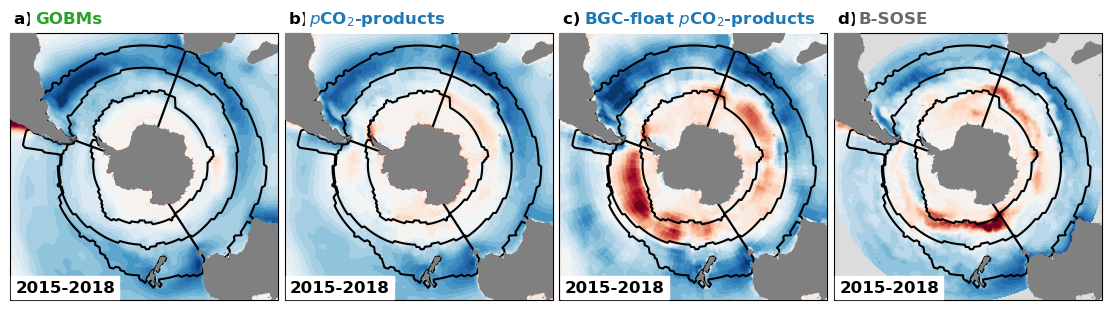

In [56]:
#------
# FIGURE 2 with only 3 panels: models/B-SOSE/data
#------

reccap_regions_only = True
save_plots = True
save_netcdf = False
fs_text = 12
colormap = copy.copy(plt.cm.RdBu_r)

# labels for panels
plot_title1a = 'GOBMs'
plot_title1b = '$\it{p}$CO$_{2}$-products' 
plot_title1c = 'BGC-float $\it{p}$CO$_{2}$-products' 
plot_title1d = 'B-SOSE'
plot_title2a = str(year1)+'-'+str(year2)
plot_title2b = '2015-'+str(year2)
plot_title2c = str(year1)+'-'+str(year2)
plot_title2d = str(year1)+'-'+str(year2)

panel_label_a = 'a)'
panel_label_b = 'b)'
panel_label_c = 'c)'  
panel_label_d = 'd)'  
    
#----
# plot maps
#----
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(1, 4, 1, projection=ccrs.SouthPolarStereo()) #projection=ccrs.PlateCarree())
ax2 = fig.add_subplot(1, 4, 2, projection=ccrs.SouthPolarStereo())
ax3 = fig.add_subplot(1, 4, 3, projection=ccrs.SouthPolarStereo())
ax4 = fig.add_subplot(1, 4, 4, projection=ccrs.SouthPolarStereo())
fig.subplots_adjust(bottom=0.05, top=0.95,
                left=0.04, right=0.95, wspace=0.025,hspace=0.025)

#-----
# MODELS
#-----
print('Models...')
ax=ax1
data_plot = get_data_plot(multi_model_mean,levels)
data_plot[data_plot<levels[0]] = levels[0]+0.001 # values that exceed colorbar limits are shown in darkest color
data_plot[data_plot>levels[-1]] = levels[-1]-0.001
data_plot[data_plot==999] = -999
data_plot = np.ma.masked_where(data_plot==-999,data_plot)
save_field_as_netcdf(data_plot[:,:-1],lat,lon_to_nc,'models',save_netcdf) # SAVE NETCDFs
mm=plot_map(ax,X,Y,data_plot,levels,colormap,color_continents,r_mask3)
#for lin in range(len(lineslonlat)): # Plot biome boundaries from file with lines:
#    ax.plot(xlin[lin],ylin[lin], color='black', linestyle='-',linewidth=0.1,zorder=10)
add_annotations_to_plot(ax,plot_title1a,plot_title2a,panel_label_a,fs_text,color_models)
del data_plot
    
#------
# DATA PRODUCTS
#-----
print('Data products...')
ax=ax2
#ax.set_axis_off()
data_plot = get_data_plot(multi_data_prod_mean,levels)
data_plot[data_plot<levels[0]] = levels[0]+0.001 # values that exceed colorbar limits are shown in darkest color
data_plot[data_plot>levels[-1]] = levels[-1]-0.001
data_plot[data_plot==999] = -999
save_field_as_netcdf(data_plot[:,:-1],lat,lon_to_nc,'data_products',save_netcdf) # SAVE NETCDFs
mm=plot_map(ax,X,Y,data_plot,levels,colormap,color_continents,r_mask3)
add_annotations_to_plot(ax,plot_title1b,plot_title2b,panel_label_b,fs_text,color_data)
del data_plot

#------
# DATA PRODUCTS+BGC FLOATS
#-----
print('Data products+SOCCOM...')
ax=ax3
#ax.set_axis_off()
data_plot = get_data_plot(-1*86400.*365.25*soccom_mean_map,levels)
data_plot[data_plot<levels[0]] = levels[0]+0.001 # values that exceed colorbar limits are shown in darkest color
data_plot[data_plot>levels[-1]] = levels[-1]-0.001
data_plot[data_plot==999] = -999
save_field_as_netcdf(data_plot[:,:-1],lat,lon_to_nc,'soccom',save_netcdf) # SAVE NETCDFs
mm=plot_map(ax,X,Y,data_plot,levels,colormap,color_continents,r_mask3)
add_annotations_to_plot(ax,plot_title1c,plot_title2c,panel_label_c,fs_text,color_data)
del data_plot
    
    
#------
# B-SOSE
#-----
print('B-SOSE...')
ax=ax4
#ax.set_axis_off()
data_plot = np.copy(BSOSE_mean)
data_plot[data_plot<levels[0]] = levels[0]+0.001 # values that exceed colorbar limits are shown in darkest color
data_plot[data_plot>levels[-1]] = levels[-1]-0.001
data_plot[data_plot==-999]=999
data_plot[BSOSE_mean==-999]=999
#if reccap_regions_only:
#    data_plot[regions.mask==True]=999
data_plot = get_data_plot(data_plot,levels)
mm=plot_map(ax,X,Y,data_plot,levels,colormap,color_continents,r_mask3)
add_annotations_to_plot(ax,plot_title1d,plot_title2d,panel_label_d,fs_text,color_data_assim1)
del data_plot

filename = 'fig_maps_product_means_2015_2018_'+season+'.png'
if save_plots: 
    plt.savefig(save_to_dir+filename, bbox_inches='tight',dpi=dpicnt, transparent=False)     
    
plt.show()


Separate COLORBAR...


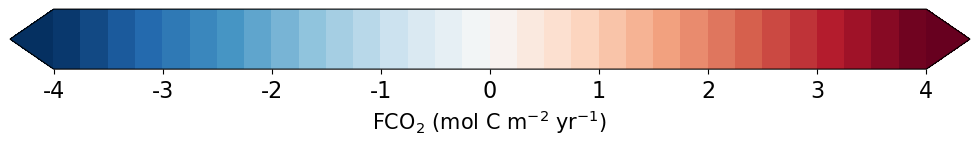

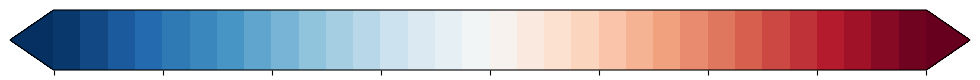

In [57]:

#-----
# COLORBAR: plot separately
#-----
print('Separate COLORBAR...')
cticks_label = [-4,-3,-2,-1,0,1,2,3,4]
colormap = copy.copy(plt.cm.RdBu_r)

fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(1, 1, 1, projection=ccrs.SouthPolarStereo()) #projection=ccrs.PlateCarree())
fig.subplots_adjust(bottom=0.05, top=0.95,
                left=0.04, right=0.95, wspace=0.025,hspace=0.025)
ax=ax1
data_plot = get_data_plot(multi_model_mean,levels)
data_plot[data_plot==999] = -999
mm=plot_colorbar(ax1,X,Y,data_plot,levels,colormap,color_continents,r_mask3)
add_annotations_to_plot(ax,plot_title1a,plot_title2a,panel_label_a,fs_text,color_models)
del data_plot
fig.gca().set_visible(False)

cax = plt.axes([0.1, 0.2, 0.8, 0.1])
cbar=fig.colorbar(mm,cax=cax,orientation='horizontal')#,fraction=0.075, shrink=1.0)#pad=0.15,cax=cbar_ax, 
cbar.set_label(label_colorbar,fontsize=fs_text+3)
cbar.ax.tick_params(labelsize=fs_text+4)
cbar.ax.set_xticklabels(cticks_label)

filename = 'fig_maps_product_means_COLORBAR.png'
if save_plots: 
    plt.savefig(save_to_dir+filename, bbox_inches='tight',dpi=dpicnt, transparent=False)     
    
plt.show()

#---
# EPS
#---
cticks_label = []

fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(1, 1, 1, projection=ccrs.SouthPolarStereo()) #projection=ccrs.PlateCarree())
fig.subplots_adjust(bottom=0.05, top=0.95,
                left=0.04, right=0.95, wspace=0.025,hspace=0.025)
ax=ax1
data_plot = get_data_plot(multi_model_mean,levels)
data_plot[data_plot==999] = -999
mm=plot_colorbar(ax1,X,Y,data_plot,levels,colormap,color_continents,r_mask3)
add_annotations_to_plot(ax,plot_title1a,plot_title2a,panel_label_a,fs_text,color_models)
del data_plot
fig.gca().set_visible(False)

cax = plt.axes([0.1, 0.2, 0.8, 0.1])
cbar=fig.colorbar(mm,cax=cax,orientation='horizontal')#,fraction=0.075, shrink=1.0)#pad=0.15,cax=cbar_ax, 
#cbar.set_label(label_colorbar,fontsize=fs_text+3)
cbar.ax.tick_params(labelsize=fs_text+4)
cbar.ax.set_xticklabels(cticks_label)
    
filename = 'fig_maps_product_means_COLORBAR.eps'
if save_plots: 
    plt.savefig(save_to_dir+filename, bbox_inches='tight',dpi=dpicnt, transparent=False,format='eps')     
    
plt.show()


Models...


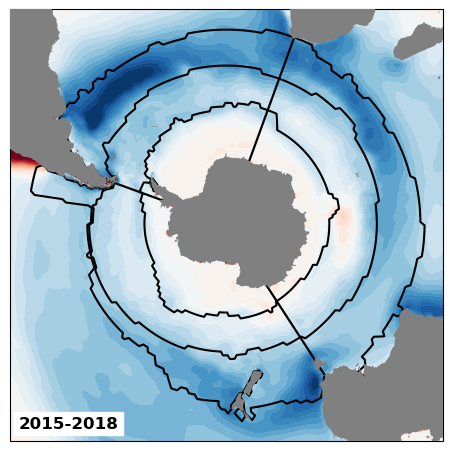

Data products...


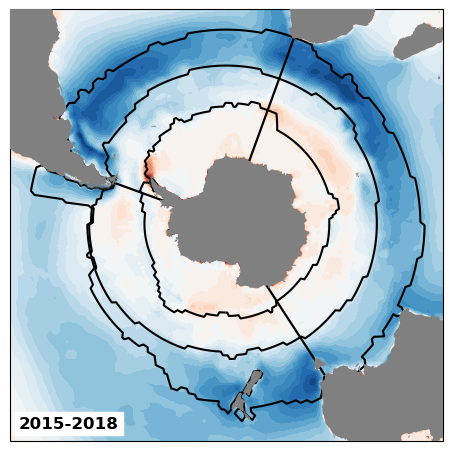

SOCCOM data products...


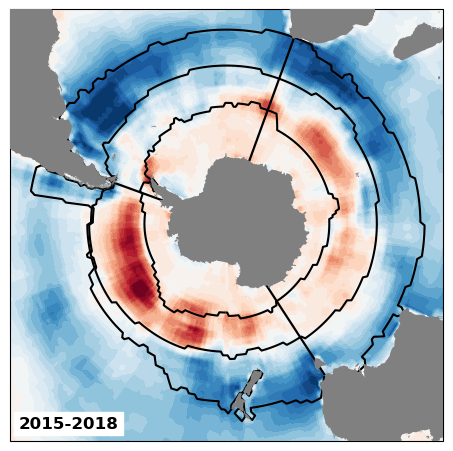

In [58]:
#---
# save multi-model mean and multi-data product mean
#---

save_plots = True
save_netcdf = False
fs_text = 12
colormap = copy.copy(plt.cm.RdBu_r)

# labels for panels
plot_title1a = 'GOBMs'
plot_title1b = 'B-SOSE'
plot_title1c = '$\it{p}$CO$_{2}$-products' 
plot_title2a = str(year1)+'-'+str(year2)
plot_title2b = '2015-'+str(year2)
plot_title2c = str(year1)+'-'+str(year2)

panel_label_a = 'a)'
panel_label_b = 'c)'
panel_label_c = 'b)'

def add_annotations_to_plot_2(ax,plot_title1,plot_title2,panel_label,fs_text,color_text):
    bbox_props = dict(boxstyle="square,pad=0.25", fc="white", ec="white", lw=1) # fc=frontcolor, ec=edgecolor
    #ax.annotate(panel_label+'  ', xy=(0.015,1.035), xycoords='axes fraction',color='black',\
    #                    fontweight='bold',fontsize=fs_text,bbox=bbox_props) # 0.95
    #ax.annotate(plot_title1, xy=(0.088,1.035), xycoords='axes fraction',color=color_text,\
    #                    fontweight='bold',fontsize=fs_text,bbox=bbox_props)
    ax.annotate(plot_title2, xy=(0.02,0.03), xycoords='axes fraction',color='black',\
                        fontweight='bold',fontsize=fs_text,bbox=bbox_props) #(0.01,0.025)
    
fs_text = 12


#-----
# MODELS
#-----
print('Models...')
fig = plt.figure(figsize=(5,6))
ax  = fig.add_subplot(1, 1, 1, projection=ccrs.SouthPolarStereo()) #projection=ccrs.PlateCarree())
fig.subplots_adjust(bottom=0.05, top=0.95,
                left=0.04, right=0.95, wspace=0.025,hspace=0.025)
data_plot = get_data_plot(multi_model_mean,levels)
data_plot[data_plot<levels[0]] = levels[0]+0.001 # values that exceed colorbar limits are shown in darkest color
data_plot[data_plot>levels[-1]] = levels[-1]-0.001
data_plot[data_plot==999] = -999
data_plot = np.ma.masked_where(data_plot==-999,data_plot)
save_field_as_netcdf(data_plot[:,:-1],lat,lon_to_nc,'models',save_netcdf) # SAVE NETCDFs
mm=plot_map(ax,X,Y,data_plot,levels,colormap,color_continents,r_mask3)
add_annotations_to_plot_2(ax,plot_title1a,plot_title2a,panel_label_a,fs_text,color_models)
del data_plot
filename = 'fig_maps_mean_MODELS_2015_2018_'+season+'.png'
if save_plots: 
    plt.savefig(save_to_dir+filename, bbox_inches='tight',dpi=dpicnt, transparent=False)     
plt.show()


#------
# DATA PRODUCTS
#-----
print('Data products...')
fig = plt.figure(figsize=(5,6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.SouthPolarStereo()) #projection=ccrs.PlateCarree())
fig.subplots_adjust(bottom=0.05, top=0.95,
                left=0.04, right=0.95, wspace=0.025,hspace=0.025)
#ax.set_axis_off()
data_plot = get_data_plot(multi_data_prod_mean,levels)
data_plot[data_plot<levels[0]] = levels[0]+0.001 # values that exceed colorbar limits are shown in darkest color
data_plot[data_plot>levels[-1]] = levels[-1]-0.001
data_plot[data_plot==999] = -999
save_field_as_netcdf(data_plot[:,:-1],lat,lon_to_nc,'data_products',save_netcdf) # SAVE NETCDFs
mm=plot_map(ax,X,Y,data_plot,levels,colormap,color_continents,r_mask3)
add_annotations_to_plot_2(ax,plot_title1c,plot_title2c,panel_label_c,fs_text,color_data)
del data_plot
    
filename = 'fig_maps_mean_DATA_PRODUCTS_2015_2018_'+season+'.png'
if save_plots: 
    plt.savefig(save_to_dir+filename, bbox_inches='tight',dpi=dpicnt, transparent=False)     
plt.show()


#------
# AVG of BOTH SOCCOM PRODUCTS
#-----
print('SOCCOM data products...')
fig = plt.figure(figsize=(5,6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.SouthPolarStereo()) #projection=ccrs.PlateCarree())
fig.subplots_adjust(bottom=0.05, top=0.95,
                left=0.04, right=0.95, wspace=0.025,hspace=0.025)
#ax.set_axis_off()
data_plot = get_data_plot(-1*86400.*365.25*soccom_mean_map,levels)
data_plot[data_plot<levels[0]] = levels[0]+0.001 # values that exceed colorbar limits are shown in darkest color
data_plot[data_plot>levels[-1]] = levels[-1]-0.001
data_plot[data_plot==999] = -999
save_field_as_netcdf(data_plot[:,:-1],lat,lon_to_nc,'data_products',save_netcdf) # SAVE NETCDFs
mm=plot_map(ax,X,Y,data_plot,levels,colormap,color_continents,r_mask3)
add_annotations_to_plot_2(ax,plot_title1c,plot_title2c,panel_label_c,fs_text,color_data)
del data_plot
    
filename = 'fig_maps_mean_SOCCOM_DATA_PRODUCTS_2015_2018_'+season+'.png'
if save_plots: 
    plt.savefig(save_to_dir+filename, bbox_inches='tight',dpi=dpicnt, transparent=False)     
plt.show()


In [39]:
#---
# save individual fields as netcdf
#---

# lon,lat for plotting
xax_X = transform_lon_coord(lon)

lon_to_nc = np.copy(xax_X)
lon_to_nc[lon_to_nc>180] = lon_to_nc[lon_to_nc>180]-360

save_netcdf = False
if not save_netcdf:
    print()
    print('do not save fields')
    print()

#----
# all MODELS
#----
netcdf_name = 'RECCAPv2_SO_CO2_flux_fields_avg_2015_2018_GOBMs_'+season+'.nc'
for ii in range(0,len(models)):
    #eval('ax=ax'+str(ii+1),globals=None, locals=None)
    print (models[ii])
    data_plot = np.copy(factor*flux_models[:,:,ii])
    #data_plot[data_plot>levels[-1]] = levels[-1]-0.01 
    data_plot[np.isnan(data_plot)]=-1*fill_value
    data_plot[data_plot==0]=-1*fill_value
    data_plot = get_data_plot(data_plot,levels)
    data_plot[data_plot==-999]=999
    #(mm,data,lat,lon,which_var,list_names,save_netcdf,netcdf_name)
    save_individual_field_as_netcdf(ii,data_plot[:,:-1],lat,lon_to_nc,'models',models,save_netcdf,netcdf_name)
        
#----
# all data products
#----
netcdf_name = 'RECCAPv2_SO_CO2_flux_fields_avg_2015_2018_pCO2_products_'+season+'.nc'
for ii in range(0,len(data_prod)):
    print (data_prod[ii])
    data_plot = np.copy(factor*flux_data_products[:,:,ii])
    #data_plot[data_plot>levels[-1]] = levels[-1]-0.01 
    data_plot[np.isnan(data_plot)]=-1*fill_value
    data_plot[data_plot==0]=-1*fill_value
    data_plot = get_data_plot(data_plot,levels)

    data_plot[data_plot==-999]=999
    #(mm,data,lat,lon,which_var,list_names,save_netcdf,netcdf_name)
    save_individual_field_as_netcdf(ii,data_plot[:,:-1],lat,lon_to_nc,'data_products',data_prod,save_netcdf,netcdf_name)
    
    



do not save fields

CCSM-WHOI
CESM-ETHZ
CNRM-ESM2-1
EC-Earth3
FESOM_REcoM_HR
FESOM_REcoM_LR
MOM6-Princeton
MPIOM-HAMOCC
MRI-ESM2-1
NorESM-OC1.2
ORCA025-GEOMAR
ORCA1-LIM3-PISCES
PlankTOM12
ROMS-SouthernOcean-ETHZ
AOML_EXTRAT
CMEMS-LSCE-FFNN
CSIRML6
JenaMLS
JMAMLR
LDEO-HPD
NIES-ML3
OceanSODAETHZ
SOMFFN


In [ ]:
#---
# plot all models, data products etc. individually
#---

plot_individual_panels = False
if plot_individual_panels:

    save_plots = True
    display_plots = False

    # option to skip models, data products and data-assim. models
    plot_all_models    = False
    plot_all_data_prod = True
    plot_all_data_assim = True

    # time labels for panels
    plot_time_full = str(year1)+'-'+str(year2)
    plot_time_data_assim = ['2015-'+str(year2),'2015-'+str(year2)]
    plot_time_data_products = ['2015-'+str(year2),str(year1)+'-'+str(year2),str(year1)+'-'+str(year2),
                              str(year1)+'-'+str(year2),str(year1)+'-'+str(year2),str(year1)+'-'+str(year2),
                              str(year1)+'-'+str(year2),str(year1)+'-'+str(year2),str(year1)+'-'+str(year2)]
    plot_time_watson = ['2015-'+str(year2)]
    plot_time_soccom = ['2015-'+str(year2)]

    def add_annotations_to_plot_individual(ax,plot_title1,plot_title2,panel_label,fs_text,color_text):
        bbox_props = dict(boxstyle="square,pad=0.25", fc="white", ec="white", lw=1) # fc=frontcolor, ec=edgecolor
        #ax.annotate(panel_label+'  ', xy=(0.015,1.035), xycoords='axes fraction',color='black',\
        #                    fontweight='bold',fontsize=fs_text,bbox=bbox_props) # 0.95
        #ax.annotate(plot_title1, xy=(0.015,1.015), xycoords='axes fraction',color=color_text,\
        #                    fontweight='bold',fontsize=fs_text,bbox=bbox_props)
        print('xx',plot_title2)
        ax.annotate(plot_title2, xy=(0.02,0.03), xycoords='axes fraction',color='black',\
                            fontweight='bold',fontsize=fs_text,bbox=bbox_props) #(0.01,0.025)

    #---
    # MODELS
    #---
    if plot_all_models:
        for ii in range(0,len(models)):
            fig = plt.figure(figsize=(6,6))
            ax1 = fig.add_subplot(1, 1, 1, projection=ccrs.SouthPolarStereo()) #projection=ccrs.PlateCarree())
            fig.subplots_adjust(bottom=0.05, top=0.95,
                        left=0.04, right=0.95, wspace=0.025,hspace=0.025)

            data_plot = np.copy(factor*flux_models[:,:,ii])
            print ('nanmin in model ii:',np.nanmin(data_plot))
            # make sure dark blue is still dark blue
            # but note: sign change happens in plotting function, so a sink is still positive here
            data_plot[data_plot>levels[-1]] = levels[-1]-0.01 
            data_plot[data_plot<levels[0]] = levels[0]+0.01 
            data_plot[np.isnan(data_plot)]=-1*fill_value
            data_plot[data_plot==0]=-1*fill_value
            data_plot = get_data_plot(data_plot,levels)
            plot_map(ax1,X,Y,data_plot,levels,colormap,color_continents,r_mask3)
            if models[ii] in ['CCSM-WHOI']: 
                plot_time_string = str(year1)+'-2017'
            else: 
                plot_time_string = plot_time_full
            add_annotations_to_plot_individual(ax1,models2[ii],plot_time_string,'',fs_text,color_models)
            del data_plot,plot_time_string
            if save_plots: 
                filename = 'fig_maps_MODELS_'+models[ii]+'_2015_2018_'+season+'.png'
                print(save_to_dir2+filename)
                plt.savefig(save_to_dir2+filename, bbox_inches='tight',dpi=dpicnt, transparent=False)  
            if display_plots:
                plt.show()
            else:
                plt.close(fig)


    #----
    # all data-assim
    #----
    if plot_all_data_assim:
        for ii in range(0,len(data_assim)):
            fig = plt.figure(figsize=(6,6))
            ax1 = fig.add_subplot(1, 1, 1, projection=ccrs.SouthPolarStereo()) #projection=ccrs.PlateCarree())
            fig.subplots_adjust(bottom=0.05, top=0.95,
                        left=0.04, right=0.95, wspace=0.025,hspace=0.025)

            data_plot = np.copy(factor*flux_data_assim[:,:,ii])
            print ('nanmin in data-assim. model ii:',np.nanmin(data_plot))
            # make sure dark blue is still dark blue
            # but note: sign change happens in plotting function, so a sink is still positive here
            data_plot[data_plot>levels[-1]] = levels[-1]-0.01 
            data_plot[data_plot<levels[0]] = levels[0]+0.01 
            data_plot[np.isnan(data_plot)]=-1*fill_value
            data_plot[data_plot==0]=-1*fill_value
            data_plot = get_data_plot(data_plot,levels)
            plot_map(ax1,X,Y,data_plot,levels,colormap,color_continents,r_mask3)
            add_annotations_to_plot_individual(ax1,data_assim[ii],plot_time_data_assim[ii],'',fs_text,color_data_assim)
            del data_plot
            if save_plots: 
                filename = 'fig_maps_DATA_ASSIM_'+data_assim[ii]+'_2015_2018_'+season+'.png'
                print(save_to_dir2+filename)
                plt.savefig(save_to_dir2+filename, bbox_inches='tight',dpi=dpicnt, transparent=False)  
            if display_plots:
                plt.show()
            else:
                plt.close(fig)     

    #----
    # all data products
    #----
    if plot_all_data_prod: 
        for ii in range(0,len(data_prod)):
            fig = plt.figure(figsize=(6,6))
            ax1 = fig.add_subplot(1, 1, 1, projection=ccrs.SouthPolarStereo()) #projection=ccrs.PlateCarree())
            fig.subplots_adjust(bottom=0.05, top=0.95,
                        left=0.04, right=0.95, wspace=0.025,hspace=0.025)

            data_plot = np.copy(factor*flux_data_products[:,:,ii])
            print ('nanmin in data product ii:',np.nanmin(data_plot))
            # make sure dark blue is still dark blue
            # but note: sign change happens in plotting function, so a sink is still positive here
            data_plot[data_plot>levels[-1]] = levels[-1]-0.01 
            data_plot[data_plot<levels[0]] = levels[0]+0.01 
            data_plot[np.isnan(data_plot)]=-1*fill_value
            data_plot[data_plot==0]=-1*fill_value
            data_plot = get_data_plot(data_plot,levels)
            plot_map(ax1,X,Y,data_plot,levels,colormap,color_continents,r_mask3)
            add_annotations_to_plot_individual(ax1,data_prod[ii],plot_time_data_products[ii],'',fs_text,color_data_assim)
            del data_plot
            if save_plots: 
                filename = 'fig_maps_DATA_PROD_'+data_prod[ii]+'_2015_2018_'+season+'.png'
                print(save_to_dir2+filename)
                plt.savefig(save_to_dir2+filename, bbox_inches='tight',dpi=dpicnt, transparent=False)  
            if display_plots:
                plt.show()
            else:
                plt.close(fig)  


    #----
    # SOCCOM1
    #----
    fig = plt.figure(figsize=(6,6))
    ax1 = fig.add_subplot(1, 1, 1, projection=ccrs.SouthPolarStereo()) #projection=ccrs.PlateCarree())
    fig.subplots_adjust(bottom=0.05, top=0.95,
                    left=0.04, right=0.95, wspace=0.025,hspace=0.025)

    data_plot = np.copy(-1*factor*soccom1) # soccom: flip sign once more!
    print ('nanmin in SOCCOM1:',np.nanmin(data_plot))
    # make sure dark blue is still dark blue
    # but note: sign change happens in plotting function, so a sink is still positive here
    data_plot[data_plot>levels[-1]] = levels[-1]-0.01 
    data_plot[data_plot<levels[0]] = levels[0]+0.01 
    data_plot[np.isnan(data_plot)]=-1*fill_value
    data_plot[data_plot==0]=-1*fill_value
    data_plot = get_data_plot(data_plot,levels)
    plot_map(ax1,X,Y,data_plot,levels,colormap,color_continents,r_mask3)
    add_annotations_to_plot_individual(ax1,soccom[0],plot_time_soccom[0],'',fs_text,color_data_assim)
    del data_plot
    if save_plots: 
        filename = 'fig_maps_SOCCOM1_'+soccom[0]+'_2015_2018_'+season+'.png'
        print(save_to_dir2+filename)
        plt.savefig(save_to_dir2+filename, bbox_inches='tight',dpi=dpicnt, transparent=False)  
    if display_plots:
        plt.show()
    else:
        plt.close(fig) 

    #----
    # SOCCOM2
    #----
    fig = plt.figure(figsize=(6,6))
    ax1 = fig.add_subplot(1, 1, 1, projection=ccrs.SouthPolarStereo()) #projection=ccrs.PlateCarree())
    fig.subplots_adjust(bottom=0.05, top=0.95,
                    left=0.04, right=0.95, wspace=0.025,hspace=0.025)

    data_plot = np.copy(-1*factor*soccom2) # soccom: flip sign once more!
    print ('nanmin in SOCCOM2:',np.nanmin(data_plot))
    # make sure dark blue is still dark blue
    # but note: sign change happens in plotting function, so a sink is still positive here
    data_plot[data_plot>levels[-1]] = levels[-1]-0.01 
    data_plot[data_plot<levels[0]] = levels[0]+0.01 
    data_plot[np.isnan(data_plot)]=-1*fill_value
    data_plot[data_plot==0]=-1*fill_value
    data_plot = get_data_plot(data_plot,levels)
    plot_map(ax1,X,Y,data_plot,levels,colormap,color_continents,r_mask3)
    add_annotations_to_plot_individual(ax1,soccom[1],plot_time_soccom[0],'',fs_text,color_data_assim)
    del data_plot
    if save_plots: 
        filename = 'fig_maps_SOCCOM2_'+soccom[1]+'_2015_2018_'+season+'.png'
        print(save_to_dir2+filename)
        plt.savefig(save_to_dir2+filename, bbox_inches='tight',dpi=dpicnt, transparent=False)  
    if display_plots:
        plt.show()
    else:
        plt.close(fig) 


    #----
    # Watson2020
    #----
    fig = plt.figure(figsize=(6,6))
    ax1 = fig.add_subplot(1, 1, 1, projection=ccrs.SouthPolarStereo()) #projection=ccrs.PlateCarree())
    fig.subplots_adjust(bottom=0.05, top=0.95,
                    left=0.04, right=0.95, wspace=0.025,hspace=0.025)

    data_plot = np.copy(factor*flux_data_watson[:,:,0])
    print ('nanmin in Watson2020:',np.nanmin(data_plot))
    # make sure dark blue is still dark blue
    # but note: sign change happens in plotting function, so a sink is still positive here
    data_plot[data_plot>levels[-1]] = levels[-1]-0.01 
    data_plot[data_plot<levels[0]] = levels[0]+0.01 
    data_plot[np.isnan(data_plot)]=-1*fill_value
    data_plot[data_plot==0]=-1*fill_value
    data_plot = get_data_plot(data_plot,levels)
    plot_map(ax1,X,Y,data_plot,levels,colormap,color_continents,r_mask3)
    add_annotations_to_plot_individual(ax1,data_watson[0],plot_time_watson[0],'',fs_text,color_data_assim)
    del data_plot
    if save_plots: 
        filename = 'fig_maps_WATSON2020_'+data_watson[0]+'_2015_2018_'+season+'.png'
        print(save_to_dir2+filename)
        plt.savefig(save_to_dir2+filename, bbox_inches='tight',dpi=dpicnt, transparent=False)  
    if display_plots:
        plt.show()
    else:
        plt.close(fig) 


In [ ]:
#-----
# bar plots (mean + std of models, data products & data assimilating models)
#-----

In [ ]:
#----
# load river file
#----
# if true, the flux is added to the models

river_adjustment = True
if river_adjustment: 
    river_adj_names = ('Lacroix2020')
    ff = Dataset(path_river+'fgco2_lacroix-river_v20211223.nc')
    river = ff.variables['fgco2'][:] # lon is 0-360, needs to be transformed for plotting
    ff.close()
    print (river.shape)


In [ ]:
#-----
# get subareas avg
#-----
# NOTE: for each product/model, get areas of biomes separately
# the areas are not the same for the different prodcuts

def get_ind_subarea(reg2,subarea):
    if subarea in ['STSS-Atl']:
        ind_region = np.where(reg2==0)[0]
    elif subarea in ['STSS-Ind']:
        ind_region = np.where(reg2==3)[0]
    elif subarea in ['STSS-Pac']:
        ind_region = np.where(reg2==6)[0]
    elif subarea in ['SPSS-Atl']:
        ind_region = np.where(reg2==1)[0]
    elif subarea in ['SPSS-Ind']:
        ind_region = np.where(reg2==4)[0]
    elif subarea in ['SPSS-Pac']:
        ind_region = np.where(reg2==7)[0]
    elif subarea in ['ICE-Atl']:
        ind_region = np.where(reg2==2)[0]
    elif subarea in ['ICE-Ind']:
        ind_region = np.where(reg2==5)[0]
    elif subarea in ['ICE-Pac']:
        ind_region = np.where(reg2==8)[0]
    elif subarea in ['STSS']:
        ind_region = np.where((reg2==0) | (reg2==3) | (reg2==6))[0]
    elif subarea in ['SPSS']:
        ind_region = np.where((reg2==1) | (reg2==4) | (reg2==7))[0]
    elif subarea in ['ICE']:
        ind_region =np.where((reg2==2) | (reg2==5) | (reg2==8))[0]
    elif subarea in ['all']:
        ind_region = np.where(reg2>=0)[0]
    return ind_region

def get_subarea_avg(flux_models,regions,area,eval_time,models_ABCD,subregions):
    #print flux_models.shape
    flux_subareas  = np.nan*np.ones([len(models_ABCD),len(subregions)]) 
    biome_areas    = np.nan*np.ones([len(models_ABCD),len(subregions)]) 
    for pp in range(0,len(models_ABCD)):
        counter=0 # only for printing of total area
        print ('Process '+models_ABCD[pp])
        for i in range(0,len(subregions)):
            if len(flux_models.shape)<3: #river
                data1 = flux_models[:,:]
                reg2  = regions.ravel()  # SO RECCAP mask
                area2 = area.ravel() # surface area
                data2 = data1.ravel()
                
                ind_region = get_ind_subarea(reg2,subregions[i])
                    
                ind_not_nan_data = np.where(~np.isnan(data2[ind_region]))[0] # only consider data points that are filled
                total_area = np.sum(area2[ind_region][ind_not_nan_data])
                #total_area = np.sum(area2[ind_region])
                if np.nansum(data1)!=0: # only for years which are filled
                    if (subregions[i] in ['all']) & (counter==0):
                        print (total_area)
                        counter = 1
                    biome_areas[pp,i] = total_area 
                    flux_subareas[pp,i] = np.nansum(data2[ind_region]*area2[ind_region]/total_area)
                del data1,reg2,area2,data2,ind_region,total_area
            else:
                data1 = flux_models[:,:,pp]
                reg2  = regions.ravel()  # SO RECCAP mask
                area2 = area.ravel() # surface area
                data2 = data1.ravel()
                
                ind_region = get_ind_subarea(reg2,subregions[i])
                    
                ind_not_nan_data = np.where(~np.isnan(data2[ind_region]))[0] # only consider data points that are filled
                total_area = np.sum(area2[ind_region][ind_not_nan_data])
                #total_area = np.sum(area2[ind_region])
                if np.nansum(data1)!=0: # only for years which are filled
                    if (subregions[i] in ['all']) & (counter==0):
                        print (total_area)
                        counter = 1
                    biome_areas[pp,i] = total_area 
                    flux_subareas[pp,i] = np.nansum(data2[ind_region]*area2[ind_region]/total_area)
                del data1,reg2,area2,data2,ind_region,total_area
    return flux_subareas,biome_areas
    

In [ ]:
#------
# get subarea mean of models, data product, data assimilation products
#------

# calculate subarea averages
#subregions = ('STSS_Atl','SPSS_Atl','ICE_Atl','STSS_Ind','SPSS_Ind',\
#              'ICE_Ind','STSS_Pac','SPSS_Pac','ICE_Pac','STSS','SPSS','ICE')#,'all')
# 13 regions: 9 regions in SO, + 3 for combined sectors, +1 for whole SO

print ('-----')
print ('river flux')
print ('-----')
river_subareas,biome_area_river = get_subarea_avg(river,regions,area,\
                                                eval_time,[river_adj_names],subregions)
river_subareas = np.squeeze(river_subareas)
biome_area_river = np.squeeze(biome_area_river )
    
print ('-----')
print ('models')
print ('-----')
flux_models_subareas,biome_area_models = get_subarea_avg(flux_models,regions,area,\
                                                eval_time,models,subregions)
print ('-----')
print ('OCIM')
print ('-----')
flux_ocim_subareas,biome_area_ocim = get_subarea_avg(flux_ocim,regions,area,\
                                                eval_time,data_ocim,subregions)
        
print ('-----')
print ('data products')
print ('-----')
flux_data_products_subareas,biome_area_data_products = get_subarea_avg(flux_data_products,regions,area,\
                                                eval_time,data_prod,subregions)

print ('-----')
print ('SOCCOM')
print ('-----')
soccom_all = np.stack((soccom1,soccom2), axis=2)
flux_soccom_subareas,biome_area_soccom = get_subarea_avg(soccom_all,regions,area,\
                                                eval_time,soccom,subregions)


print ('-----')
print ('data products/Watson2020')
print ('-----')
flux_data_watson_subareas,biome_area_data_watson = get_subarea_avg(flux_data_watson,regions,area,\
                                                eval_time,data_watson,subregions)

print ('-----')
print ('data-assimilating models')
print ('-----')
flux_data_assim_subareas,biome_area_data_assim = get_subarea_avg(flux_data_assim,regions,area,\
                                                eval_time,data_assim,subregions)

print ('-----')
print ('atm inversions')
print ('-----')
flux_atminv_subareas,biome_area_atminv = get_subarea_avg(flux_atminv,regions,area,\
                                                eval_time,data_atminv,subregions)
    

In [ ]:
#---
# print some numbers
#---

ss = -1

print ('######')
print ('Subregion '+subregions[ss]+':')
print ('######')

print ('River adjustment: '+str(river_subareas[ss]))

for ii in range(0,len(soccom)):
    print (soccom[ii]+': '+str(flux_soccom_subareas[ii,ss]))
        
for ii in range(0,len(models)):
    print (models[ii]+': '+str(flux_models_subareas[ii,ss]))

for ii in range(0,len(data_prod)):
    print (data_prod[ii]+': '+str(flux_data_products_subareas[ii,ss]))
        
for ii in range(0,len(data_watson)):
    print (data_watson[ii]+': '+str(flux_data_watson_subareas[ii,ss]))
    
for ii in range(0,len(data_assim)):
    print (data_assim[ii]+': '+str(flux_data_assim_subareas[ii,ss]))

for ii in range(0,len(data_ocim)):
    print (data_ocim[ii]+': '+str(flux_ocim_subareas[ii,ss]))

for ii in range(0,len(data_atminv)):
    print (data_atminv[ii]+': '+str(flux_atminv_subareas[ii,ss]))

print (subregions)
print (flux_soccom_subareas)
               

In [ ]:
#----
# check for river fluxes
#----
if river_adjustment:
    print ('')
    print ('River flux adjustment (pos=outgassing):')
    factor = 365.25*86400.*12.011/1e15 # don't use "-1" here; global number should positive = outgassing due to rivers
    for ss in range(0,len(subregions)):
        print (subregions[ss]+': '+str(factor*river_subareas[ss]*biome_area_river[ss])+' Pg C yr-1')
    # check: add up 3 subregions
    print ('based on STSS/SPSS/ICE: '+str(np.sum(factor*river_subareas[9:12]*biome_area_river[9:12]))+' Pg C yr-1')

    print ('Global ocean area: '+str(np.sum(area_global))+' m2')
    print ('Global river flux: '+str(np.nansum(factor*np.multiply(river,area_global)))+' Pg C yr-1')
    print ('SO/Global: '+str(100*factor*river_subareas[-1]*biome_area_river[-1]/np.nansum(factor*np.multiply(river,area_global)))+'%')
    print ('')
    #print river


In [ ]:
#-------
# get zonal avg or integral for monthly data
#-------
def calc_zonal_avg(data):
    # calculate zonal avg flux
    # assumes lon is 2nd dimension
    # "area" is not needed because grid cell area is constant for any given latitude
    
    data[data==0]=np.nan # if there is zeros in the field, correct for them here
    data_avg = np.nanmean(data,axis=1) # mean over all lon
    return data_avg

def calc_zonal_integral(data,area):
    # calculate zonally integrated flux
    # "area" contains the area of the grid cells
    
    data_avg = np.nansum(data*area,axis=1) # integrate over all lon
    #print data_avg.shape
    return data_avg

flux_models_zonal = np.nan*np.ones([180,len(models)])
for pp in range(0,len(models)):
    flux_models_zonal[:,pp] = calc_zonal_avg(flux_models[:,:,pp])

flux_ocim_zonal = np.nan*np.ones([180,len(data_ocim)])
for pp in range(0,len(data_ocim)):
    flux_ocim_zonal[:,pp] = calc_zonal_avg(flux_ocim[:,:,pp])

flux_data_products_zonal = np.nan*np.ones([180,len(data_prod)])
for pp in range(0,len(data_prod)):
    flux_data_products_zonal[:,pp] = calc_zonal_avg(flux_data_products[:,:,pp])

flux_soccom_zonal = np.nan*np.ones([180,len(soccom)])
for pp in range(0,len(soccom)):
    flux_soccom_zonal[:,pp] = calc_zonal_avg(soccom_all[:,:,pp])
            
flux_data_watson_zonal = np.nan*np.ones([180,len(data_watson)])
for pp in range(0,len(data_watson)):
    flux_data_watson_zonal[:,pp] = calc_zonal_avg(flux_data_watson[:,:,pp])


flux_data_assim_zonal = np.nan*np.ones([180,len(data_assim)])
for pp in range(0,len(data_assim)):
    flux_data_assim_zonal[:,pp] = calc_zonal_avg(flux_data_assim[:,:,pp])

flux_data_atminv_zonal = np.nan*np.ones([180,len(data_atminv)])
for pp in range(0,len(data_atminv)):
    flux_data_atminv_zonal[:,pp] = calc_zonal_avg(flux_atminv[:,:,pp])
            

In [ ]:

def panel_zonal_avg_flux_models_only(ax,lat,flux_models_zonal,flux_data_products_zonal,flux_soccom_zonal,\
                         flux_data_assim_zonal,flux_data_watson_zonal,flux_data_atminv_zonal,\
                         models,data_prod,panel_label,ind_not_mpi):
    #----
    # no river flux adjustment!!!
    #----
    
    lw_mean = 3.5
    lw_all = 2.5
    alpha_value=0.3
    alpha_std = 0.1
    color_models = 'C2'#'cornflowerblue'
    color_data   = 'C0'#'black'
    color_data_assim ='grey'
    color_watson     = 'lightsteelblue'
    color_data_assim1 = 'dimgrey'
    color_data_assim2 = 'darkgrey'
    color_atminv     = 'C4'
    color_soccom   = 'darkslateblue'
    color_ocim1 = 'navajowhite'
    color_ocim2 = 'papayawhip'
    fs = 14

    fs = 16
    fs_label    = 16
    fs_text     = 10

    # fgco2: convert from mol C s-1 to mol yr-1
    factor = -1*86400*365
    unit = 'FCO$_2$ (mol C m$^{-2}$ yr$^{-1}$)' # deg$^{-1}$
    
    # fgco2: convert from mol C s-1 to TgC yr-1
    #factor = -1*86400*365*12.011/1e12
    #unit = 'FCO$_2$ (TgC yr$^{-1}$ deg$^{-1}$)'
    
    lat_lim1 = -70
    lat_lim2 = -35
    ind_lat1 = np.argmin(np.abs(lat-lat_lim1))
    ind_lat2 = np.argmin(np.abs(lat-lat_lim2))#+2
    print ('Plot between '+str(-1*lat[ind_lat1])+'°S and '+str(-1*lat[ind_lat2])+'°S')

    dpicnt = 200
    
    color_list = ('k','darkgreen','lightgreen','mediumturquoise',\
                          'darkblue','cornflowerblue','lightsteelblue',\
                 'k','darkgreen','lightgreen','mediumturquoise',\
                          'darkblue','cornflowerblue','lightsteelblue')
    line_type_list = ('-','-','-','-','-','-','-','-','-','-',':',':',':',':',':',':',':')
    
    from matplotlib.colors import ListedColormap
    
    color_list = [(51./255.,34./255.,136./255.),(136./255.,204./255.,238./255.),\
                  (68./255.,170./255.,153./255.),(17./255.,119./255.,51./255.),\
                  (153./255.,153./255.,51./255.),(221./255.,204./255.,119./255.),\
                   (204./255.,102./255.,119./255.),(136./255.,34./255.,85./255.),\
                   (170./255.,68./255.,153./255.),(170./255.,170./255.,170./255.),\
                  (51./255.,34./255.,136./255.),(136./255.,204./255.,238./255.),\
                  (68./255.,170./255.,153./255.),(17./255.,119./255.,51./255.),\
                  (153./255.,153./255.,51./255.),(221./255.,204./255.,119./255.),\
                   (204./255.,102./255.,119./255.),(136./255.,34./255.,85./255.),\
                   (170./255.,68./255.,153./255.),(170./255.,170./255.,170./255.)]
    #color_list = ListedColormap(color_list)
    
    #---
    # models
    #---
    flux_models_zonal[flux_models_zonal==0]=np.nan # don't skew the mean
    a1  = np.nanmean(factor*flux_models_zonal[ind_lat1:ind_lat2+1,ind_not_mpi],axis=1)
    a1_std = np.nanstd(factor*flux_models_zonal[ind_lat1:ind_lat2+1,ind_not_mpi],axis=1)
    a2a = a1+a1_std
    a2b = a1-a1_std
    #ax.fill_between(lat[ind_lat1:ind_lat2+1], a2a, a2b, color=color_models,alpha = alpha_std,\
    #                     edgecolor='none') 
    for dd in range(0,flux_models_zonal.shape[1]):
        if dd in ind_not_mpi:
            if models[dd] in ['ROMS-SouthernOcean-ETHZ']:
                ax.plot(lat[ind_lat1:ind_lat2+1],factor*flux_models_zonal[ind_lat1:ind_lat2+1,dd],\
                            color=color_list[dd], linestyle=line_type_list[dd],linewidth=lw_all, alpha=0.8,\
                       label='ROMS-SO-ETHZ')
            else:
                ax.plot(lat[ind_lat1:ind_lat2+1],factor*flux_models_zonal[ind_lat1:ind_lat2+1,dd],\
                            color=color_list[dd], linestyle=line_type_list[dd],linewidth=lw_all, alpha=0.8,\
                       label=models[dd])
        
    ax.annotate(panel_label,xy=(0.015,0.92), xycoords='axes fraction',
                         fontsize=fs_text+1.7,fontweight='bold')
    
    ax.set_xlim((lat[ind_lat1],lat[ind_lat2]))
    xlim1,xlim2 = ax.get_xlim()
    ylim1,ylim2 = ax.get_ylim()
    ax.set_ylim((ylim1-0.06,ylim2))
    ylim1,ylim2 = ax.get_ylim()
    
   # ax.set_ylim((-105,30))
   # ax.set_yticks([-100,-75,-50,-25,0,25])
    #ax.set_yticklabels([-100,-75,-50,-25,0,25])

    ax.hlines(0,xlim1,xlim2,linestyle='-',color='black')
    ax.set_xticks([-70,-60,-50,-40])
    ax.set_xticklabels([70,60,50,40])
    ax.set_xlabel('Latitude ($^{\circ}$S)',fontsize=fs-2)
    ax.set_ylabel(unit,fontsize=fs-2)
    
    mark_subregions = True
    if mark_subregions:
        circle_size = 6
        color_marker = 'black'
        fs2 = 10
        color_text = 'grey'
        l1=ax.plot(-59.95,ylim1,marker='o',markersize=circle_size,color=color_marker,zorder=20,clip_on=False)
        l2=ax.plot(-48.05,ylim1,marker='o',markersize=circle_size,color=color_marker,zorder=20,clip_on=False)
        l3=ax.plot(-39.11,ylim1,marker='o',markersize=circle_size,color=color_marker,zorder=20,clip_on=False)
        ax.annotate('ICE',xy=(0.13,-0.04), xycoords='axes fraction',fontsize=fs2,color=color_text)
        ax.annotate('SPSS',xy=(0.46,-0.04), xycoords='axes fraction',fontsize=fs2,color=color_text)
        ax.annotate('STSS',xy=(0.76,-0.04), xycoords='axes fraction',fontsize=fs2,color=color_text)
        #ax.annotate('ICE',xy=(0.26,0.02), xycoords='axes fraction',fontsize=fs2)
        #ax.annotate('SPSS',xy=(0.59,0.02), xycoords='axes fraction',fontsize=fs2)
        #ax.annotate('STSS',xy=(0.84,0.02), xycoords='axes fraction',fontsize=fs2)
    
    for label in ax.yaxis.get_majorticklabels():
            label.set_size(fs-3)
    for label in ax.xaxis.get_majorticklabels():
            label.set_size(fs-3)
    ax.legend(loc='upper center', bbox_to_anchor=(1.1, 0.6),\
                ncol=1,fancybox=True, frameon=False,shadow=False,prop={'size': 8})

test_plot = True
if test_plot:
    fig, axs = plt.subplots(1,1,figsize=(13,5), dpi=dpicnt,\
                                gridspec_kw={'width_ratios': [1],'height_ratios': [1]})
    plt.subplots_adjust(wspace=0.025)
    plt.subplots_adjust(hspace=0.025)

    ax1 = plt.subplot2grid((1,1), (0,0))#, colspan=2)

    ax = ax1

    #print flux_data_assim_zonal.shape
    panel_zonal_avg_flux_models_only(ax,lat,flux_models_zonal,flux_data_products_zonal,flux_soccom_zonal,\
                             flux_data_assim_zonal,flux_data_watson_zonal,flux_data_atminv_zonal,\
                         models,data_prod,'annual',ind_not_mpi)

    
    filename = 'fig_zonal_avg_all_models_'+season+'_'+str(year1)+'_'+str(year2)+'.png'
    

    save_plots=False
    if save_plots: 
        plt.savefig(save_to_dir+filename, bbox_inches='tight',dpi=dpicnt, transparent=False)  
    plt.show()
    
    
    

In [ ]:

def panel_zonal_avg_flux(ax,lat,flux_models_zonal,flux_data_products_zonal,flux_soccom_zonal,\
                         flux_data_assim_zonal,flux_data_watson_zonal,flux_data_atminv_zonal,\
                         models,data_prod,panel_label,ind_not_mpi,season):
    #-----
    # no river flux adjustment
    #-----
    
    lw_mean = 2.5#3.5
    lw_all = 1
    alpha_value=0.3
    alpha_std = 0.1
    color_models = 'C2'#'cornflowerblue'
    color_data   = 'C0'#'black'
    color_data_assim ='grey'
    color_watson     = color_data #'lightsteelblue'
    color_data_assim1 = 'dimgrey'
    color_data_assim2 = 'darkgrey'
    color_atminv     = 'goldenrod' #'C4'
    color_soccom   = color_data #'darkslateblue'
    color_ocim1 = 'navajowhite'
    color_ocim2 = 'papayawhip'
    fs = 12

    fs = 14
    fs_label    = 14
    fs_text     = 14
    
    ls_ecco = '--'
    ls_soccom = '--'
    ls_watson = ':'
    #ls_ldeo = '-.'
    #dash_ldeo = [3,1,1,1]

    # fgco2: convert from mol C m-2 s-1 to mol m-2 yr-1
    factor = -1*86400*365
    # for atm inversions: fgco2: convert from PgC m-2 yr-1 to mol m-2 yr-1
    factor_atminv = -1e15/(12.0)
    unit = 'FCO$_2$ (mol C m$^{-2}$ yr$^{-1}$)' # deg$^{-1}$
    
    
    # fgco2: convert from mol C s-1 to TgC yr-1
    #factor = -1*86400*365*12.011/1e12
    #unit = 'FCO$_2$ (TgC yr$^{-1}$ deg$^{-1}$)'
    
    lat_lim1 = -70
    lat_lim2 = -35
    ind_lat1 = np.argmin(np.abs(lat-lat_lim1))
    ind_lat2 = np.argmin(np.abs(lat-lat_lim2))#+2
    print ('Plot between '+str(-1*lat[ind_lat1])+'°S and '+str(-1*lat[ind_lat2])+'°S')

    dpicnt = 200
    
    color_list = ('k','darkgreen','lightgreen','mediumturquoise',\
                          'darkblue','cornflowerblue','lightsteelblue',\
                 'k','darkgreen','lightgreen','mediumturquoise',\
                          'darkblue','cornflowerblue','lightsteelblue')
    line_type_list = ('-','-','-','-','-','-','-',':',':',':',':',':',':',':')
    
    #---
    # models
    #---
    flux_models_zonal[flux_models_zonal==0]=np.nan # don't skew the mean
    a1  = np.nanmean(factor*flux_models_zonal[ind_lat1:ind_lat2+1,:],axis=1)
    mean_models = np.copy(a1)
    a1_std = np.nanstd(factor*flux_models_zonal[ind_lat1:ind_lat2+1,:],axis=1)
    a2a = a1+a1_std
    a2b = a1-a1_std
  #  ax.fill_between(lat[ind_lat1:ind_lat2+1], a2a, a2b, color=color_models,alpha = alpha_std,\
  #                       edgecolor='none') 
    for dd in range(0,flux_models_zonal.shape[1]):
        if dd in ind_not_mpi:
            ax.plot(lat[ind_lat1:ind_lat2+1],factor*flux_models_zonal[ind_lat1:ind_lat2+1,dd],\
                    color=color_models, linewidth=0.5, alpha=0.4) #ax=ax, hue=dim
    ax.plot(lat[ind_lat1:ind_lat2+1],a1,color_models,linewidth=lw_mean,label='GOBMs',zorder=30)
    
    
    #---
    # B-SOSE
    #---
    flux_data_assim_zonal[flux_data_assim_zonal==0]=np.nan # don't skew the mean
    ax.plot(lat[ind_lat1:ind_lat2+1],factor*flux_data_assim_zonal[ind_lat1:ind_lat2+1,0],color_data_assim1,\
            linewidth=lw_mean-0.75,label='B-SOSE',zorder=16)
    #color_data_assim1,\
            
    #---
    # ECCO-DARWIN
    #---
    ax.plot(lat[ind_lat1:ind_lat2+1],factor*flux_data_assim_zonal[ind_lat1:ind_lat2+1,1],color_data_assim1,\
            linewidth=lw_mean-0.75,linestyle=ls_ecco,label='ECCO-DARWIN',zorder=15)
    
    #---
    # data products
    #---
    flux_data_products_zonal[flux_data_products_zonal==0]=np.nan # don't skew the mean
    a1  = np.nanmean(factor*flux_data_products_zonal[ind_lat1:ind_lat2+1,:],axis=1)
    mean_data = np.copy(a1)
    a1_std = np.nanstd(factor*flux_data_products_zonal[ind_lat1:ind_lat2+1,:],axis=1)
    a2a = a1+a1_std
    a2b = a1-a1_std
  #  ax.fill_between(lat[ind_lat1:ind_lat2+1], a2a, a2b, color=color_data,alpha = alpha_std,\
  #                       edgecolor='none') 
    for dd in range(0,flux_data_products_zonal.shape[1]):
        #ax.plot(lat[ind_lat1:ind_lat2+1],factor*flux_data_products_zonal[ind_lat1:ind_lat2+1,dd],\
        #            color=color_list[dd], linestyle=line_type_list[dd],linewidth=1.5, alpha=0.8,\
        #       label=data_prod[dd])
        ax.plot(lat[ind_lat1:ind_lat2+1],factor*flux_data_products_zonal[ind_lat1:ind_lat2+1,dd],\
                    color=color_data, linewidth=0.5, alpha=0.4) #ax=ax, hue=dim
    ax.plot(lat[ind_lat1:ind_lat2+1],a1,color_data,linewidth=lw_mean,label='pCO$_{2}$-products',zorder=30)
    
    #---
    # Atm inversion
    #---
    flux_data_atminv_zonal[flux_data_atminv_zonal==0]=np.nan # don't skew the mean
    # atm. inv are already in PgC m-2 yr-1, only change sign here
    for dd in range(0,flux_data_atminv_zonal.shape[1]):
        ax.plot(lat[ind_lat1:ind_lat2+1],factor_atminv*flux_data_atminv_zonal[ind_lat1:ind_lat2+1,dd],\
                    color=color_atminv, linewidth=0.5, alpha=0.4) 
    ax.plot(lat[ind_lat1:ind_lat2+1],factor_atminv*np.mean(flux_data_atminv_zonal[ind_lat1:ind_lat2+1,:],axis=1),\
            color_atminv,\
            linewidth=lw_mean-0.75,label='Atmosph. inversions',zorder=5)
    mean_atminv = np.copy(factor_atminv*np.mean(flux_data_atminv_zonal[ind_lat1:ind_lat2+1,:],axis=1))
    
    #---
    # Watson2020
    #---
    flux_data_watson_zonal[flux_data_watson_zonal==0]=np.nan # don't skew the mean
    ax.plot(lat[ind_lat1:ind_lat2+1],factor*flux_data_watson_zonal[ind_lat1:ind_lat2+1,0],color_watson,\
            linestyle=ls_watson,linewidth=lw_mean-0.75,label='Watson2020',zorder=15)
    
    #---
    # SOCCOM
    #---
    flux_soccom_zonal[flux_soccom_zonal==0]=np.nan # don't skew the mean
    a1  = np.nanmean(factor*flux_soccom_zonal[ind_lat1:ind_lat2+1,:],axis=1)
    mean_soccom = -1*np.copy(a1)
    #a1_std = np.nanstd(factor*flux_soccom_zonal[ind_lat1:ind_lat2+1,:],axis=1)
    #a2a = a1+a1_std
    #a2b = a1-a1_std
    #ax.fill_between(lat[ind_lat1:ind_lat2+1], a2a, a2b, color=color_soccom,alpha = alpha_std,\
    #                     edgecolor='none') 
    #for dd in range(0,flux_soccom_zonal.shape[1]):
    #    ax.plot(lat[ind_lat1:ind_lat2+1],factor*flux_soccom_zonal[ind_lat1:ind_lat2+1,dd],\
    #                color=color_soccom, linewidth=0.5, alpha=0.8) #ax=ax, hue=dim
    ax.plot(lat[ind_lat1:ind_lat2+1],-1*a1,color_soccom,linewidth=lw_mean-0.75,\
            linestyle=ls_soccom,label='BGC-float pCO$_{2}$-prod.',zorder=15)
    
    #ax.plot(lat[ind_lat1:ind_lat2+1],-1*factor*flux_soccom_zonal[ind_lat1:ind_lat2+1,0],\
    #        color_soccom,linewidth=lw_mean-1,zorder=30)
    #ax.plot(lat[ind_lat1:ind_lat2+1],-1*factor*flux_soccom_zonal[ind_lat1:ind_lat2+1,1],\
    #        color_soccom,linewidth=lw_mean-1,zorder=30)
    
    #-----
    # print some numbers
    print ('')
    print ('Min/Max/Diff models:',np.nanmin(mean_models),np.nanmax(mean_models),np.nanmin(mean_models)-np.nanmax(mean_models))
    print ('Min/Max/Diff data product:',np.nanmin(mean_data),np.nanmax(mean_data),np.nanmin(mean_data)-np.nanmax(mean_data))
    print ('Min/Max/Diff SOCCOM:',np.nanmin(mean_soccom),np.nanmax(mean_soccom),np.nanmin(mean_soccom)-np.nanmax(mean_soccom))
    print ('Min/Max/Diff atm inv.:',np.nanmin(mean_atminv),np.nanmax(mean_atminv),np.nanmin(mean_atminv)-np.nanmax(mean_atminv))
    print ('')
    #-----
    
    ax.annotate(panel_label,xy=(0.015,0.92), xycoords='axes fraction',
                         fontsize=fs_text+1.7,fontweight='bold')
    
    ax.set_xlim((lat[ind_lat1],lat[ind_lat2]))
    xlim1,xlim2 = ax.get_xlim()
    ylim1,ylim2 = ax.get_ylim()
    ax.set_ylim((ylim1-0.05,ylim2))
    ylim1,ylim2 = ax.get_ylim()
    
   # ax.set_ylim((-105,30))
   # ax.set_yticks([-100,-75,-50,-25,0,25])
    #ax.set_yticklabels([-100,-75,-50,-25,0,25])

    ax.hlines(0,xlim1,xlim2,linestyle='-',color='k',linewidth=0.5)
    ax.set_xticks([-70,-60,-50,-40])
    ax.set_xticklabels([70,60,50,40])
    ax.set_xlabel('Latitude ($^{\circ}$S)',fontsize=fs)
    ax.set_ylabel(unit,fontsize=fs-4)
    
    mark_subregions = True
    if mark_subregions:
        circle_size = 3
        color_marker = 'black'
        color_text   = 'grey'
        fs2 = 5
        l1=ax.plot(-59.95,ylim1,marker='o',markersize=circle_size,color=color_marker,zorder=20,clip_on=False)
        l2=ax.plot(-48.05,ylim1,marker='o',markersize=circle_size,color=color_marker,zorder=20,clip_on=False)
        l3=ax.plot(-39.11,ylim1,marker='o',markersize=circle_size,color=color_marker,zorder=20,clip_on=False)
        ax.annotate('ICE',xy=(0.13,-0.055), xycoords='axes fraction',fontsize=fs2,color=color_text)
        ax.annotate('SPSS',xy=(0.46,-0.055), xycoords='axes fraction',fontsize=fs2,color=color_text)
        ax.annotate('STSS',xy=(0.76,-0.055), xycoords='axes fraction',fontsize=fs2,color=color_text)
        
        
    for label in ax.yaxis.get_majorticklabels():
            label.set_size(fs-2)
    for label in ax.xaxis.get_majorticklabels():
            label.set_size(fs-2)
            
    handles, labels = ax.get_legend_handles_labels() 
    order = [0,3,1,2,6,5,4] ##specify order of items in legend
    
    if season in ['JJA','jja']: # bottom left
        ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order],\
              loc='upper center', bbox_to_anchor=(0.215, 0.3),\
                ncol=2,fancybox=True, markerfirst=True,frameon=False,\
              shadow=False,prop={'size': 5},handlelength=2.4) # 0.215, 0.345
    elif season in ['DJF','djf']: # bottom right
        ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order],\
              loc='upper center', bbox_to_anchor=(0.67, 0.26),\
                ncol=3,fancybox=True, markerfirst=False,frameon=False,\
              shadow=False,prop={'size': 5},handlelength=2.4)
    else: # top right
        ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order],\
              loc='upper center', bbox_to_anchor=(0.785, 1.02),\
                ncol=2,fancybox=True, markerfirst=False,frameon=False,\
              shadow=False,prop={'size': 5},handlelength=2.4)
        

test_plot = True
if test_plot:
    fig, axs = plt.subplots(1,1,figsize=(10,4), dpi=dpicnt,\
                                gridspec_kw={'width_ratios': [1],'height_ratios': [1]})
    plt.subplots_adjust(wspace=0.025)
    plt.subplots_adjust(hspace=0.025)

    ax1 = plt.subplot2grid((1,1), (0,0))#, colspan=2)

    ax = ax1

    #print flux_data_assim_zonal.shape
    panel_zonal_avg_flux(ax,lat,flux_models_zonal,flux_data_products_zonal,flux_soccom_zonal,\
                             flux_data_assim_zonal,flux_data_watson_zonal,flux_data_atminv_zonal,\
                         models,data_prod,'a)',ind_not_mpi,season)

    plt.show()



In [ ]:
#---
# settings for plots
#---

save_plots=True
river_adjustment = True

if river_adjustment:
    add_to_models = np.copy(river_subareas)
else:
    add_to_models = np.zeros_like(river_subareas) # add a field of zeros
print ('River fluxes to add for subregion all:',add_to_models[-1])
    
# means over products
model_mean = np.mean(flux_models_subareas[ind_not_mpi,:],axis=0)
model_std  = np.std(flux_models_subareas[ind_not_mpi,:],axis=0) 

data_mean  = np.mean(flux_data_products_subareas[1:,:],axis=0) # leave out AOML (starts later)
data_std   = np.std(flux_data_products_subareas[1:,:],axis=0) 

area_mean_models        = np.mean(biome_area_models,axis=0)
area_mean_data_products = np.mean(biome_area_data_products[1:,:],axis=0) # exclude AOML

print ('area_mean_models (all):',area_mean_models[-1])
print ('area_mean_data_products (all):',area_mean_data_products[-1])

watson  = np.mean(flux_data_watson_subareas,axis=0) 

soccom_mean = np.mean(flux_soccom_subareas,axis=0)
soccom_std  = np.std(flux_soccom_subareas,axis=0)

ocim_mean  = np.mean(flux_ocim_subareas,axis=0) 
ocim_std   = np.std(flux_ocim_subareas,axis=0) 

atminv_mean = np.mean(flux_atminv_subareas,axis=0)
atminv_std = np.std(flux_atminv_subareas,axis=0)

area_mean_models        = np.mean(biome_area_models[ind_not_mpi,:],axis=0)
area_mean_data_products = np.mean(biome_area_data_products[1:,:],axis=0) # exclude AOML
area_mean_watson        = np.mean(biome_area_data_watson,axis=0)
area_mean_data_assim    = np.mean(biome_area_data_assim,axis=0)
area_mean_ocim          = np.mean(biome_area_ocim,axis=0)
area_mean_atminv        = np.mean(biome_area_atminv,axis=0)
area_mean_soccom        = np.mean(biome_area_soccom,axis=0)
print('area_mean_watson (region all):',area_mean_watson[-1])

# which regions to plot
ind_ss1 = -1
ind_ss2 = -2
ind_ss3 = -3
ind_ss4 = -4

fs = 14
fs_label    = 14
fs_text     = 14

color_models     = 'C2'
color_data       = 'C0'
color_watson     = color_data #'lightsteelblue'
color_data_assim1 = 'dimgrey'
color_data_assim2 = color_data_assim1 #'darkgrey'
color_ocim       = 'lightgrey'
color_atminv     = 'goldenrod' #'C4'
color_soccom = color_data #'darkslateblue'
color_ocim1 = 'navajowhite'
color_ocim2 = 'papayawhip'
color_dots = 'black'
alpha1 = 0.7
alpha2=0.9
alpha3=1

# convert from mol C m-2 s-1 to PgC m-2 yr-1
factor = -1*365.25*86400.*12.011/1e15
factor_s_yr = -1*365.25*86400.
factor_soccom = 365.25*86400.*12.011/1e15
factor_river = 365.25*86400.*12.011/1e15 # for river fluxes, no need to multiply by "-1" -> pos=outgassing already!
#print factor*area_biomes[ind_ss1]*model_mean[ind_ss1]   

# labels for panels
plot_title1a = 'GOBMs'
plot_title1c = 'pCO$_{2}$-products'
plot_title2a = str(year1)+'-'+str(year2)
plot_title2c = str(year1)+'-'+str(year2)

panel_label_a = 'c)' # map1
panel_label_b = 'd)' # map2
panel_label_d = 'a)' # bars
panel_label_e = 'b)' # zonal avg
    
# lon,lat for plotting
xax_X = transform_lon_coord(lon)
xax_X = np.concatenate((xax_X,np.full(1,xax_X[0]))) 
X, Y  = np.meshgrid(xax_X, lat) 

#7.7359372994e+13

In [ ]:
#---
# panel a only: bar plot
#---

plot_eps = True

circle_size=8 #3.5
# markers for each model/data product
#circle_size=8 #3.5
edgewidth=0.75 #0.5
# whiskers for model/data spread
whisker_properties = dict(lw=4, capsize=7, capthick=3,ecolor='dimgrey')
whisker_properties2 = dict(lw=3, capsize=6, capthick=2.5,ecolor='dimgrey')

fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(1, 1, 1) # projection=ccrs.SouthPolarStereo(), projection=ccrs.PlateCarree())

#------
# BAR PLOTS -> w/ river flux adjustment if "true"
#------
width1 = 0.8
width2 = 0.6

hatch_ecco = "////"
hatch_soccom = "////"
hatch_watson = "...."
plt.rcParams.update({'hatch.color': 'gainsboro'})
plt.rcParams['hatch.linewidth'] = 0.45# 0.35

# no OCIM
x_pos1 = [0.,1.,\
          2.5,3.5,\
          5.,6.,\
         7.5,8.5]

ax = ax1
ax.yaxis.tick_right()
ax.set_xlim((x_pos1[0]-1,x_pos1[-1]+1))

#----
# print flux in mol C m-2 yr-1
#----
print ('-------')
print ('')
print ('Multi-model mean, multi-data product mean')
print ('')
for rr in range(0,len(subregions)):
    add_rivers = factor_river*biome_area_river[rr]*add_to_models[rr]
    print (subregions[rr],factor_s_yr*model_mean[rr]+add_rivers,factor_s_yr*data_mean[rr])
print ('')
print ('-------')

#-------
# ALL: models, data-assim, data, atminv
add_rivers = factor_river*biome_area_river[ind_ss1]*add_to_models[ind_ss1]
print ('multi-model mean, all:',factor*area_mean_models[ind_ss1]*model_mean[ind_ss1]+add_rivers)
ax.bar(x_pos1[0],factor*area_mean_models[ind_ss1]*model_mean[ind_ss1]+add_rivers,color=color_models,\
        alpha=alpha1,width=width1,yerr=factor*area_mean_models[ind_ss1]*model_std[ind_ss1],\
                error_kw=whisker_properties,label='GOBMs (2015-2018)')
print ('std models',factor*area_mean_models[ind_ss1]*model_std[ind_ss1])
for mm in range(0,len(models)):
    if mm in ind_not_mpi:
        ax.plot(x_pos1[0],factor*biome_area_models[mm,ind_ss1]*flux_models_subareas[mm,ind_ss1]+add_rivers,\
             markeredgecolor=color_dots,marker='o',markeredgewidth=edgewidth,
            markersize=circle_size,markerfacecolor="None")
# data
ax.bar(x_pos1[1],factor*area_mean_data_products[ind_ss1]*data_mean[ind_ss1],color=color_data,\
        alpha=alpha1,width=width1,yerr=factor*area_mean_data_products[ind_ss1]*data_std[ind_ss1],\
                error_kw=whisker_properties,label='$p$CO$_{2}$-products (2015-2018)')
for mm in range(1,len(data_prod)): # leave out AOML
    ax.plot(x_pos1[1],factor*biome_area_data_products[mm,ind_ss1]*flux_data_products_subareas[mm,ind_ss1],\
             markeredgecolor=color_dots,marker='o',markeredgewidth=edgewidth,
            markersize=circle_size,markerfacecolor="None")

#-------
# region1: models, data, data-assim, atm inv
add_rivers = factor_river*biome_area_river[ind_ss2]*add_to_models[ind_ss2]
print ('multi-model mean, region 1:',factor*area_mean_models[ind_ss2]*model_mean[ind_ss2]+add_rivers)
ax.bar(x_pos1[2],factor*area_mean_models[ind_ss2]*model_mean[ind_ss2]+add_rivers,color=color_models,\
        alpha=alpha1,width=width1,yerr=factor*area_mean_models[ind_ss2]*model_std[ind_ss2],\
                error_kw=whisker_properties)
for mm in range(0,len(models)):
    if mm in ind_not_mpi:
        ax.plot(x_pos1[2],factor*biome_area_models[mm,ind_ss2]*flux_models_subareas[mm,ind_ss2]+add_rivers,\
             markeredgecolor=color_dots,marker='o',markeredgewidth=edgewidth,
            markersize=circle_size,markerfacecolor="None")
# data
ax.bar(x_pos1[3],factor*area_mean_data_products[ind_ss2]*data_mean[ind_ss2],color=color_data,\
        alpha=alpha1,width=width1,yerr=factor*area_mean_data_products[ind_ss2]*data_std[ind_ss2],\
                error_kw=whisker_properties)
for mm in range(1,len(data_prod)): # leave out AOML
    ax.plot(x_pos1[3],factor*biome_area_data_products[mm,ind_ss2]*flux_data_products_subareas[mm,ind_ss2],\
             markeredgecolor=color_dots,marker='o',markeredgewidth=edgewidth,
            markersize=circle_size,markerfacecolor="None")

#-------
# region2: models, data, data-assim, atm inv
add_rivers = factor_river*biome_area_river[ind_ss3]*add_to_models[ind_ss3]
print ('multi-model mean, region 2:',factor*area_mean_models[ind_ss3]*model_mean[ind_ss3]+add_rivers)
ax.bar(x_pos1[4],factor*area_mean_models[ind_ss3]*model_mean[ind_ss3]+add_rivers,color=color_models,\
        alpha=alpha1,width=width1,yerr=factor*area_mean_models[ind_ss3]*model_std[ind_ss3],\
                error_kw=whisker_properties)
for mm in range(0,len(models)):
    if mm in ind_not_mpi:
        ax.plot(x_pos1[4],factor*biome_area_models[mm,ind_ss3]*flux_models_subareas[mm,ind_ss3]+add_rivers,\
             markeredgecolor=color_dots,marker='o',markeredgewidth=edgewidth,
            markersize=circle_size,markerfacecolor="None")
#for mm in range(0,len(models)):
#    ax.plot(x_pos1[4],factor*biome_area_models[mm,ind_ss3]*flux_models_subareas[mm,ind_ss3]+add_rivers,\
#             markerdgecolor=color_dots,marker='o',markeredgewidth=edgewidth,\
#            markersize=circle_size,markerfacecolor="None")
# data
ax.bar(x_pos1[5],factor*area_mean_data_products[ind_ss3]*data_mean[ind_ss3],color=color_data,\
        alpha=alpha1,width=width1,yerr=factor*area_mean_data_products[ind_ss3]*data_std[ind_ss3],\
                error_kw=whisker_properties)
for mm in range(1,len(data_prod)): # leave out AOML
    ax.plot(x_pos1[5],factor*biome_area_data_products[mm,ind_ss3]*flux_data_products_subareas[mm,ind_ss3],\
             markeredgecolor=color_dots,marker='o',markeredgewidth=edgewidth,
            markersize=circle_size,markerfacecolor="None")

    
#-------
# region3: models, data, data-assim, atm inv
add_rivers = factor_river*biome_area_river[ind_ss4]*add_to_models[ind_ss4]
print ('multi-model mean, region 3:',factor*area_mean_models[ind_ss4]*model_mean[ind_ss4]+add_rivers)
ax.bar(x_pos1[6],factor*area_mean_models[ind_ss4]*model_mean[ind_ss4]+add_rivers,color=color_models,\
        alpha=alpha1,width=width1,yerr=factor*area_mean_models[ind_ss4]*model_std[ind_ss4],\
                error_kw=whisker_properties)
for mm in range(0,len(models)):
    if mm in ind_not_mpi:
        ax.plot(x_pos1[6],factor*biome_area_models[mm,ind_ss4]*flux_models_subareas[mm,ind_ss4]+add_rivers,\
             markeredgecolor=color_dots,marker='o',markeredgewidth=edgewidth,
            markersize=circle_size,markerfacecolor="None")
# data
ax.bar(x_pos1[7],factor*area_mean_data_products[ind_ss4]*data_mean[ind_ss4],color=color_data,\
        alpha=alpha1,width=width1,yerr=factor*area_mean_data_products[ind_ss4]*data_std[ind_ss4],\
                error_kw=whisker_properties)
for mm in range(1,len(data_prod)): # leave out AOML
    ax.plot(x_pos1[7],factor*biome_area_data_products[mm,ind_ss4]*flux_data_products_subareas[mm,ind_ss4],\
             markeredgecolor=color_dots,marker='o',markeredgewidth=edgewidth,
            markersize=circle_size,markerfacecolor="None")#,zorder=30)


ax.set_ylabel('FCO$_2$ (PgC yr$^{-1}$)',fontsize=fs)
ax.yaxis.set_label_position("left")
ax.yaxis.tick_left()
# ax.set_ylim((-1.22,0.35)) # annual
ax.set_ylim((-2.2,0.8)) 
ax.set_yticks([-2,-1.5,-1,-0.5,0,0.5])
ax.set_yticklabels([-2,-1.5,-1,-0.5,0,0.5])
ax.set_xticks([x_pos1[0]+0.5,x_pos1[2]+0.5,x_pos1[4]+0.5,x_pos1[6]+0.5])
#ax.set_xticks([x_pos1[4],x_pos1[13],x_pos1[22],x_pos1[31]]) # w/ OCIM
ax.set_xticklabels(['Southern Ocean',subregions[ind_ss2],subregions[ind_ss3],subregions[ind_ss4]],
                  fontweight='bold')
ylim1,ylim2 = ax.get_ylim()
xlim1,xlim2 = ax.get_xlim()
ax.hlines(0,xlim1,xlim2,linestyle='-',linewidth=0.5,color='k',zorder=0)
ax.vlines(x_pos1[1]+0.75,ylim1,ylim2,linestyle=':',linewidth=1.25,zorder=0)

ax.vlines(x_pos1[3]+0.75,ylim1,ylim2,linestyle=':',color='grey',linewidth=1.0,zorder=0)
ax.vlines(x_pos1[5]+0.75,-0.88,ylim2,linestyle=':',color='grey',linewidth=1.0,zorder=0)

for label in ax.yaxis.get_majorticklabels():
        label.set_size(fs-2)
for label in ax.xaxis.get_majorticklabels():
        label.set_size(fs-2)
ax.legend(loc='right',bbox_to_anchor=(1.0, 0.09), \
              ncol=1,markerfirst=False,fancybox=False, \
               frameon=False,shadow=False,prop={'size': 10}) 
#ax.legend(markerfirst=False)
bbox_props = dict(boxstyle="square,pad=0.25", fc="white", ec="white", lw=1) # fc=frontcolor, ec=edgecolor
ax.annotate(panel_label_d+'  ', xy=(0.018,0.92), xycoords='axes fraction',color='black',\
                        fontweight='bold',fontsize=fs_text+1.5,bbox=bbox_props)

if season in ['djf']:
    season_string = 'DJF'
    season_string2 = 'summer'
elif season in ['mam']:
    season_string = 'MAM'
    season_string2 = 'fall'
elif season in ['jja']:
    season_string  = 'JJA'
    season_string2 = 'winter'
elif season in ['son']:
    season_string = 'SON'
    season_string2 = 'spring'
ax.annotate(season_string2+' mean ('+season_string+'), 2015-2018', xy=(0.99,1.02), xycoords='axes fraction',color='black',\
                        fontweight='bold',fontsize=fs_text+3,ha='right')#bbox=bbox_props)

if river_adjustment:
    filename = 'fig_bars_wRiver_Adjustment_2015_2018_'+season
else:
    filename = 'fig_bars_2015_2018_'+season

if save_plots: 
    plt.savefig(save_to_dir+filename+'.png', bbox_inches='tight',dpi=dpicnt, transparent=False,format='png') 
    
    plt.savefig(save_to_dir2+filename+'.pdf', bbox_inches='tight',dpi=dpicnt, transparent=False,format='pdf') 
plt.show()

if plot_eps:
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(1, 1, 1) # projection=ccrs.SouthPolarStereo(), projection=ccrs.PlateCarree())
    ax.yaxis.tick_right()
    ax.set_xlim((x_pos1[0]-1,x_pos1[-1]+1))

    #-------
    # ALL: models, data-assim, data, atminv
    add_rivers = factor_river*biome_area_river[ind_ss1]*add_to_models[ind_ss1]
    ax.bar(x_pos1[0],factor*area_mean_models[ind_ss1]*model_mean[ind_ss1]+add_rivers,color=color_models,\
            alpha=alpha1,width=width1,yerr=factor*area_mean_models[ind_ss1]*model_std[ind_ss1],\
                    error_kw=whisker_properties,label='GOBMs (2015-2018)')
    for mm in range(0,len(models)):
        if mm in ind_not_mpi:
            ax.plot(x_pos1[0],factor*biome_area_models[mm,ind_ss1]*flux_models_subareas[mm,ind_ss1]+add_rivers,\
                 markeredgecolor=color_dots,marker='o',markeredgewidth=edgewidth,
                markersize=circle_size,markerfacecolor="None")
    # data
    ax.bar(x_pos1[1],factor*area_mean_data_products[ind_ss1]*data_mean[ind_ss1],color=color_data,\
            alpha=alpha1,width=width1,yerr=factor*area_mean_data_products[ind_ss1]*data_std[ind_ss1],\
                    error_kw=whisker_properties,label='$p$CO$_{2}$-products (2015-2018)')
    for mm in range(1,len(data_prod)): # leave out AOML
        ax.plot(x_pos1[1],factor*biome_area_data_products[mm,ind_ss1]*flux_data_products_subareas[mm,ind_ss1],\
                 markeredgecolor=color_dots,marker='o',markeredgewidth=edgewidth,
                markersize=circle_size,markerfacecolor="None")

    #-------
    # region1: models, data, data-assim, atm inv
    add_rivers = factor_river*biome_area_river[ind_ss2]*add_to_models[ind_ss2]
    ax.bar(x_pos1[2],factor*area_mean_models[ind_ss2]*model_mean[ind_ss2]+add_rivers,color=color_models,\
            alpha=alpha1,width=width1,yerr=factor*area_mean_models[ind_ss2]*model_std[ind_ss2],\
                    error_kw=whisker_properties)
    for mm in range(0,len(models)):
        if mm in ind_not_mpi:
            ax.plot(x_pos1[2],factor*biome_area_models[mm,ind_ss2]*flux_models_subareas[mm,ind_ss2]+add_rivers,\
                 markeredgecolor=color_dots,marker='o',markeredgewidth=edgewidth,
                markersize=circle_size,markerfacecolor="None")
    # data
    ax.bar(x_pos1[3],factor*area_mean_data_products[ind_ss2]*data_mean[ind_ss2],color=color_data,\
            alpha=alpha1,width=width1,yerr=factor*area_mean_data_products[ind_ss2]*data_std[ind_ss2],\
                    error_kw=whisker_properties)
    for mm in range(1,len(data_prod)): # leave out AOML
        ax.plot(x_pos1[3],factor*biome_area_data_products[mm,ind_ss2]*flux_data_products_subareas[mm,ind_ss2],\
                 markeredgecolor=color_dots,marker='o',markeredgewidth=edgewidth,
                markersize=circle_size,markerfacecolor="None")

    #-------
    # region2: models, data, data-assim, atm inv
    add_rivers = factor_river*biome_area_river[ind_ss3]*add_to_models[ind_ss3]
    ax.bar(x_pos1[4],factor*area_mean_models[ind_ss3]*model_mean[ind_ss3]+add_rivers,color=color_models,\
            alpha=alpha1,width=width1,yerr=factor*area_mean_models[ind_ss3]*model_std[ind_ss3],\
                    error_kw=whisker_properties)
    for mm in range(0,len(models)):
        if mm in ind_not_mpi:
            ax.plot(x_pos1[4],factor*biome_area_models[mm,ind_ss3]*flux_models_subareas[mm,ind_ss3]+add_rivers,\
                 markeredgecolor=color_dots,marker='o',markeredgewidth=edgewidth,
                markersize=circle_size,markerfacecolor="None")
    ax.bar(x_pos1[5],factor*area_mean_data_products[ind_ss3]*data_mean[ind_ss3],color=color_data,\
            alpha=alpha1,width=width1,yerr=factor*area_mean_data_products[ind_ss3]*data_std[ind_ss3],\
                    error_kw=whisker_properties)
    for mm in range(1,len(data_prod)): # leave out AOML
        ax.plot(x_pos1[5],factor*biome_area_data_products[mm,ind_ss3]*flux_data_products_subareas[mm,ind_ss3],\
                 markeredgecolor=color_dots,marker='o',markeredgewidth=edgewidth,
                markersize=circle_size,markerfacecolor="None")

    #-------
    # region3: models, data, data-assim, atm inv
    add_rivers = factor_river*biome_area_river[ind_ss4]*add_to_models[ind_ss4]
    ax.bar(x_pos1[6],factor*area_mean_models[ind_ss4]*model_mean[ind_ss4]+add_rivers,color=color_models,\
            alpha=alpha1,width=width1,yerr=factor*area_mean_models[ind_ss4]*model_std[ind_ss4],\
                    error_kw=whisker_properties)
    for mm in range(0,len(models)):
        if mm in ind_not_mpi:
            ax.plot(x_pos1[6],factor*biome_area_models[mm,ind_ss4]*flux_models_subareas[mm,ind_ss4]+add_rivers,\
                 markeredgecolor=color_dots,marker='o',markeredgewidth=edgewidth,
                markersize=circle_size,markerfacecolor="None")
    # data
    ax.bar(x_pos1[7],factor*area_mean_data_products[ind_ss4]*data_mean[ind_ss4],color=color_data,\
            alpha=alpha1,width=width1,yerr=factor*area_mean_data_products[ind_ss4]*data_std[ind_ss4],\
                    error_kw=whisker_properties)
    for mm in range(1,len(data_prod)): # leave out AOML
        ax.plot(x_pos1[7],factor*biome_area_data_products[mm,ind_ss4]*flux_data_products_subareas[mm,ind_ss4],\
                 markeredgecolor=color_dots,marker='o',markeredgewidth=edgewidth,
                markersize=circle_size,markerfacecolor="None")#,zorder=30)

    ax.yaxis.set_label_position("left")
    ax.yaxis.tick_left()
    ax.set_ylim((-2.2,0.8)) 
    ax.set_yticks([-2,-1.5,-1,-0.5,0,0.5])
    ax.set_yticklabels([])
    ax.set_yticklabels([])
    ax.set_xticks([x_pos1[0]+0.5,x_pos1[2]+0.5,x_pos1[4]+0.5,x_pos1[6]+0.5])
    ax.set_xticklabels([],fontweight='bold')
    ylim1,ylim2 = ax.get_ylim()
    xlim1,xlim2 = ax.get_xlim()
    ax.hlines(0,xlim1,xlim2,linestyle='-',linewidth=0.5,color='k',zorder=0)
    ax.vlines(x_pos1[1]+0.75,ylim1,ylim2,linestyle=':',linewidth=1.25,zorder=0)

    ax.vlines(x_pos1[3]+0.75,ylim1,ylim2,linestyle=':',color='grey',linewidth=1.0,zorder=0)
    ax.vlines(x_pos1[5]+0.75,-0.88,ylim2,linestyle=':',color='grey',linewidth=1.0,zorder=0)

    if river_adjustment:
        filename = 'fig_bars_wRiver_Adjustment_2015_2018_'+season
    else:
        filename = 'fig_bars_2015_2018_'+season

    if save_plots: 
        plt.savefig(save_to_dir+filename+'.eps', bbox_inches='tight',dpi=dpicnt, transparent=False,format='eps') 
    plt.show()



In [ ]:
#---
# panel a only: bar plot, COMPLETE version (incl. data-assim. models, SOCCOM etc.)
#---

plot_eps = True
circle_size=7 #8 #3.5
# markers for each model/data product
#circle_size=8 #3.5
edgewidth=0.75 #0.5
# whiskers for model/data spread
whisker_properties = dict(lw=3.2, capsize=5, capthick=2.2,ecolor='dimgrey')
whisker_properties2 = dict(lw=2.5, capsize=4, capthick=1.8,ecolor='dimgrey')

fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(1, 1, 1) # projection=ccrs.SouthPolarStereo(), projection=ccrs.PlateCarree())

#------
# BAR PLOTS -> w/ river flux adjustment if "true"
#------
width1 = 0.8
width2 = 0.6

hatch_ecco = "///"
hatch_soccom = "///"
hatch_watson = "..."
plt.rcParams.update({'hatch.color': 'gainsboro'})
plt.rcParams['hatch.linewidth'] = 0.7 #0.45# 0.35

# no OCIM
x_pos1 = [0.,1.,\
              2.8,3.6,4.4,5.2,6.,\
             8,9,\
              10.8,11.6,12.4,13.2,14,\
              16,17,\
              18.8,19.6,20.4,21.2,22,\
              24,25,\
              26.8,27.6,28.4,29.2,30]

# for correct positions of xticklabels
x_pos_old = [0.,1.,2.,3.,4.,5.,6.,\
             8,9,10,11,12,13,14,\
              16,17,18,19,20,21,22,\
              24,25,26,27,28,29,30]
    
ax = ax1
ax.yaxis.tick_right()
ax.set_xlim((x_pos1[0]-1,x_pos1[-1]+1))

#----
# print flux in mol C m-2 yr-1
#----
print ('-------')
print ('')
print ('Multi-model mean, multi-data product mean')
print ('')
for rr in range(0,len(subregions)):
    add_rivers = factor_river*biome_area_river[rr]*add_to_models[rr]
    print (subregions[rr],factor_s_yr*model_mean[rr]+add_rivers,factor_s_yr*data_mean[rr])
print ('')
print ('-------')

#-------
# ALL: models, data-assim, data, atminv
add_rivers = factor_river*biome_area_river[ind_ss1]*add_to_models[ind_ss1]
ax.bar(x_pos1[0],factor*area_mean_models[ind_ss1]*model_mean[ind_ss1]+add_rivers,color=color_models,\
            alpha=alpha1,width=width1,yerr=factor*area_mean_models[ind_ss1]*model_std[ind_ss1],\
                    error_kw=whisker_properties,label='GOBMs')
for mm in range(0,len(models)):
    if mm in ind_not_mpi:
        ax.plot(x_pos1[0],factor*biome_area_models[mm,ind_ss1]*flux_models_subareas[mm,ind_ss1]+add_rivers,\
                markeredgecolor=color_dots,marker='o',markeredgewidth=edgewidth,
            markersize=circle_size,markerfacecolor="None")
# data
ax.bar(x_pos1[1],factor*area_mean_data_products[ind_ss1]*data_mean[ind_ss1],color=color_data,\
        alpha=alpha1,width=width1,yerr=factor*area_mean_data_products[ind_ss1]*data_std[ind_ss1],\
                    error_kw=whisker_properties,label='$p$CO$_{2}$-products')
for mm in range(1,len(data_prod)): # leave out AOML
    ax.plot(x_pos1[1],factor*biome_area_data_products[mm,ind_ss1]*flux_data_products_subareas[mm,ind_ss1],\
                 markeredgecolor=color_dots,marker='o',markeredgewidth=edgewidth,
                markersize=circle_size,markerfacecolor="None")
# plot BSOSE & ECCO-DARWIN separately
ax.bar(x_pos1[2],factor*biome_area_data_assim[0,ind_ss1]*flux_data_assim_subareas[0,ind_ss1],\
           color=color_data_assim1,\
            alpha=alpha2,width=width2,label='B-SOSE')
ax.bar(x_pos1[3],factor*biome_area_data_assim[1,ind_ss1]*flux_data_assim_subareas[1,ind_ss1],\
           color=color_data_assim2,hatch=hatch_ecco,\
            alpha=alpha2,width=width2,label=data_assim[1])
# SOCCOM
ax.bar(x_pos1[4],factor_soccom*area_mean_soccom[ind_ss1]*soccom_mean[ind_ss1],color=color_soccom,\
            alpha=alpha1,width=width2,hatch=hatch_soccom,label='BGC-float $p$CO$_{2}$-products')
for mm in range(0,len(soccom)): 
        ax.plot(x_pos1[4],factor_soccom*biome_area_soccom[mm,ind_ss1]*flux_soccom_subareas[mm,ind_ss1],\
                 markeredgecolor=color_dots,marker='o',markeredgewidth=edgewidth,
                markersize=circle_size-0.7,markerfacecolor="None")#,zorder=30)
# Watson2020 separately
ax.bar(x_pos1[5],factor*area_mean_watson[ind_ss1]*watson[ind_ss1],color=color_watson,\
            alpha=alpha1,width=width2,hatch=hatch_watson,label='Watson2020')
# atm inv
ax.bar(x_pos1[6],-1*area_mean_atminv[ind_ss1]*atminv_mean[ind_ss1],color=color_atminv,\
            yerr=area_mean_atminv[ind_ss1]*atminv_std[ind_ss1],\
                    error_kw=whisker_properties2,\
           alpha=alpha1,width=width2,label='Atmospheric inversions') #data_atminv[0]
for mm in range(0,len(data_atminv)):
    ax.plot(x_pos1[6],-1*biome_area_atminv[mm,ind_ss1]*flux_atminv_subareas[mm,ind_ss1],\
                markeredgecolor=color_dots,marker='o',markeredgewidth=edgewidth,
                markersize=circle_size-0.5,markerfacecolor="None")

#-------
# region1: models, data, data-assim, atm inv
add_rivers = factor_river*biome_area_river[ind_ss2]*add_to_models[ind_ss2]
ax.bar(x_pos1[7],factor*area_mean_models[ind_ss2]*model_mean[ind_ss2]+add_rivers,color=color_models,\
            alpha=alpha1,width=width1,yerr=factor*area_mean_models[ind_ss2]*model_std[ind_ss2],\
                    error_kw=whisker_properties)
for mm in range(0,len(models)):
    if mm in ind_not_mpi:
        ax.plot(x_pos1[7],factor*biome_area_models[mm,ind_ss2]*flux_models_subareas[mm,ind_ss2]+add_rivers,\
                 markeredgecolor=color_dots,marker='o',markeredgewidth=edgewidth,
                markersize=circle_size,markerfacecolor="None")
# data
ax.bar(x_pos1[8],factor*area_mean_data_products[ind_ss2]*data_mean[ind_ss2],color=color_data,\
            alpha=alpha1,width=width1,yerr=factor*area_mean_data_products[ind_ss2]*data_std[ind_ss2],\
                    error_kw=whisker_properties)
for mm in range(1,len(data_prod)): # leave out AOML
        ax.plot(x_pos1[8],factor*biome_area_data_products[mm,ind_ss2]*flux_data_products_subareas[mm,ind_ss2],\
                 markeredgecolor=color_dots,marker='o',markeredgewidth=edgewidth,
                markersize=circle_size,markerfacecolor="None")
# plot BSOSE & ECCO-DARWIN separately
ax.bar(x_pos1[9],factor*biome_area_data_assim[0,ind_ss2]*flux_data_assim_subareas[0,ind_ss2],color=color_data_assim1,\
            alpha=alpha2,width=width2)
ax.bar(x_pos1[10],factor*biome_area_data_assim[1,ind_ss2]*flux_data_assim_subareas[1,ind_ss2],color=color_data_assim2,\
            hatch=hatch_ecco,alpha=alpha2,width=width2)
# SOCCOM
ax.bar(x_pos1[11],factor_soccom*area_mean_soccom[ind_ss2]*soccom_mean[ind_ss2],color=color_soccom,\
            hatch=hatch_soccom,alpha=alpha1,width=width2)
for mm in range(0,len(soccom)): 
        ax.plot(x_pos1[11],factor_soccom*biome_area_soccom[mm,ind_ss2]*flux_soccom_subareas[mm,ind_ss2],\
                 markeredgecolor=color_dots,marker='o',markeredgewidth=edgewidth,
                markersize=circle_size-0.5,markerfacecolor="None")#,zorder=30)

# Watson2020 separately
ax.bar(x_pos1[12],factor*area_mean_watson[ind_ss2]*watson[ind_ss2],color=color_watson,\
            hatch=hatch_watson,alpha=alpha1,width=width2)
# atm inv
ax.bar(x_pos1[13],-1*area_mean_atminv[ind_ss2]*atminv_mean[ind_ss2],color=color_atminv,\
            yerr=area_mean_atminv[ind_ss2]*atminv_std[ind_ss2],\
                    error_kw=whisker_properties2,alpha=alpha1,width=width2) #data_atminv[0]
for mm in range(0,len(data_atminv)):
        ax.plot(x_pos1[13],-1*biome_area_atminv[mm,ind_ss2]*flux_atminv_subareas[mm,ind_ss2],\
                markeredgecolor=color_dots,marker='o',markeredgewidth=edgewidth,
                markersize=circle_size-0.5,markerfacecolor="None")

#-------
# region2: models, data, data-assim, atm inv
add_rivers = factor_river*biome_area_river[ind_ss3]*add_to_models[ind_ss3]
ax.bar(x_pos1[14],factor*area_mean_models[ind_ss3]*model_mean[ind_ss3]+add_rivers,color=color_models,\
            alpha=alpha1,width=width1,yerr=factor*area_mean_models[ind_ss3]*model_std[ind_ss3],\
                    error_kw=whisker_properties)
for mm in range(0,len(models)):
    if mm in ind_not_mpi:
        ax.plot(x_pos1[14],factor*biome_area_models[mm,ind_ss3]*flux_models_subareas[mm,ind_ss3]+add_rivers,\
                 markeredgecolor=color_dots,marker='o',markeredgewidth=edgewidth,
                markersize=circle_size,markerfacecolor="None")
# data
ax.bar(x_pos1[15],factor*area_mean_data_products[ind_ss3]*data_mean[ind_ss3],color=color_data,\
            alpha=alpha1,width=width1,yerr=factor*area_mean_data_products[ind_ss3]*data_std[ind_ss3],\
                    error_kw=whisker_properties)
for mm in range(1,len(data_prod)): # leave out AOML
    ax.plot(x_pos1[15],factor*biome_area_data_products[mm,ind_ss3]*flux_data_products_subareas[mm,ind_ss3],\
                 markeredgecolor=color_dots,marker='o',markeredgewidth=edgewidth,
                markersize=circle_size,markerfacecolor="None")
# plot BSOSE & ECCO-DARWIN separately
ax.bar(x_pos1[16],factor*biome_area_data_assim[0,ind_ss3]*flux_data_assim_subareas[0,ind_ss3],color=color_data_assim1,\
            alpha=alpha2,width=width2)
ax.bar(x_pos1[17],factor*biome_area_data_assim[1,ind_ss3]*flux_data_assim_subareas[1,ind_ss3],color=color_data_assim2,\
            hatch=hatch_ecco,alpha=alpha2,width=width2)
# SOCCOM
ax.bar(x_pos1[18],factor_soccom*area_mean_soccom[ind_ss3]*soccom_mean[ind_ss3],color=color_soccom,\
            hatch=hatch_soccom,alpha=alpha1,width=width2)
for mm in range(0,len(soccom)): 
        ax.plot(x_pos1[18],factor_soccom*biome_area_soccom[mm,ind_ss3]*flux_soccom_subareas[mm,ind_ss3],\
                 markeredgecolor=color_dots,marker='o',markeredgewidth=edgewidth,
                markersize=circle_size-0.5,markerfacecolor="None")#,zorder=30)
# Watson2020 separately
ax.bar(x_pos1[19],factor*area_mean_watson[ind_ss3]*watson[ind_ss3],color=color_watson,\
            hatch=hatch_watson,alpha=alpha1,width=width2)
# atm inv
ax.bar(x_pos1[20],-1*area_mean_atminv[ind_ss3]*atminv_mean[ind_ss3],color=color_atminv,\
            yerr=area_mean_atminv[ind_ss3]*atminv_std[ind_ss3],\
                    error_kw=whisker_properties2,alpha=alpha1,width=width2) #data_atminv[0]
for mm in range(0,len(data_atminv)):
        ax.plot(x_pos1[20],-1*biome_area_atminv[mm,ind_ss3]*flux_atminv_subareas[mm,ind_ss3],\
                markeredgecolor=color_dots,marker='o',markeredgewidth=edgewidth,
                markersize=circle_size-0.5,markerfacecolor="None")
#-------
# region3: models, data, data-assim, atm inv
add_rivers = factor_river*biome_area_river[ind_ss4]*add_to_models[ind_ss4]
ax.bar(x_pos1[21],factor*area_mean_models[ind_ss4]*model_mean[ind_ss4]+add_rivers,color=color_models,\
            alpha=alpha1,width=width1,yerr=factor*area_mean_models[ind_ss4]*model_std[ind_ss4],\
                    error_kw=whisker_properties)
for mm in range(0,len(models)):
    if mm in ind_not_mpi:
        ax.plot(x_pos1[21],factor*biome_area_models[mm,ind_ss4]*flux_models_subareas[mm,ind_ss4]+add_rivers,\
                 markeredgecolor=color_dots,marker='o',markeredgewidth=edgewidth,
                markersize=circle_size,markerfacecolor="None")
# data
ax.bar(x_pos1[22],factor*area_mean_data_products[ind_ss4]*data_mean[ind_ss4],color=color_data,\
            alpha=alpha1,width=width1,yerr=factor*area_mean_data_products[ind_ss4]*data_std[ind_ss4],\
                error_kw=whisker_properties)
for mm in range(1,len(data_prod)): # leave out AOML
        ax.plot(x_pos1[22],factor*biome_area_data_products[mm,ind_ss4]*flux_data_products_subareas[mm,ind_ss4],\
                 markeredgecolor=color_dots,marker='o',markeredgewidth=edgewidth,
                markersize=circle_size,markerfacecolor="None")#,zorder=30)
# plot BSOSE & ECCO-DARWIN separately
ax.bar(x_pos1[23],factor*biome_area_data_assim[0,ind_ss4]*flux_data_assim_subareas[0,ind_ss4],color=color_data_assim1,\
            alpha=alpha2,width=width2)
ax.bar(x_pos1[24],factor*biome_area_data_assim[1,ind_ss4]*flux_data_assim_subareas[1,ind_ss4],color=color_data_assim2,\
            hatch=hatch_ecco,alpha=alpha2,width=width2)
# SOCCOM
ax.bar(x_pos1[25],factor_soccom*area_mean_soccom[ind_ss4]*soccom_mean[ind_ss4],color=color_soccom,\
            hatch=hatch_soccom,alpha=alpha1,width=width2)
for mm in range(0,len(soccom)): 
        ax.plot(x_pos1[25],factor_soccom*biome_area_soccom[mm,ind_ss4]*flux_soccom_subareas[mm,ind_ss4],\
                 markeredgecolor=color_dots,marker='o',markeredgewidth=edgewidth,
                markersize=circle_size-0.5,markerfacecolor="None")#,zorder=30)

# Watson2020 separately
ax.bar(x_pos1[26],factor*area_mean_watson[ind_ss4]*watson[ind_ss4],color=color_watson,\
        hatch=hatch_watson,alpha=alpha1,width=width2)
# atm inv
ax.bar(x_pos1[27],-1*area_mean_atminv[ind_ss4]*atminv_mean[ind_ss4],color=color_atminv,\
            yerr=area_mean_atminv[ind_ss4]*atminv_std[ind_ss4],\
                    error_kw=whisker_properties2,alpha=alpha1,width=width2) #data_atminv[0]
for mm in range(0,len(data_atminv)):
        ax.plot(x_pos1[27],-1*biome_area_atminv[mm,ind_ss4]*flux_atminv_subareas[mm,ind_ss4],\
                markeredgecolor=color_dots,marker='o',markeredgewidth=edgewidth,
                markersize=circle_size-0.5,markerfacecolor="None")
#-------

ax.set_ylabel('FCO$_2$ (PgC yr$^{-1}$)',fontsize=fs)
ax.yaxis.set_label_position("left")
ax.yaxis.tick_left()
# ax.set_ylim((-1.22,0.35)) # annual
ax.set_ylim((-2.2,0.8)) 
ax.set_yticks([-2,-1.5,-1,-0.5,0,0.5])
ax.set_yticklabels([-2,-1.5,-1,-0.5,0,0.5])
ax.set_xticks([x_pos_old[3],x_pos_old[10],x_pos_old[17],x_pos_old[24]])
#ax.set_xticks([x_pos1[4],x_pos1[13],x_pos1[22],x_pos1[31]]) # w/ OCIM
ax.set_xticklabels(['Southern Ocean',subregions[ind_ss2],subregions[ind_ss3],subregions[ind_ss4]],
                  fontweight='bold')
ylim1,ylim2 = ax.get_ylim()
xlim1,xlim2 = ax.get_xlim()
ax.hlines(0,xlim1,xlim2,linestyle='-',linewidth=0.5,color='k',zorder=0)
ax.vlines(x_pos1[6]+1,ylim1,ylim2,linestyle=':',color='grey',linewidth=2,zorder=0)
ax.vlines(x_pos1[13]+1,-1.22,ylim2,linestyle=':',color='grey',linewidth=2,zorder=0)
ax.vlines(x_pos1[20]+1,-1.22,ylim2,linestyle=':',color='grey',linewidth=2,zorder=0)


for label in ax.yaxis.get_majorticklabels():
        label.set_size(fs-2)
for label in ax.xaxis.get_majorticklabels():
        label.set_size(fs-2)
ax.legend(loc='right',bbox_to_anchor=(0.88, 0.15), \
                  ncol=2,markerfirst=True,fancybox=False, \
                   frameon=False,shadow=False,prop={'size': 12}) 
#ax.legend(markerfirst=False)
bbox_props = dict(boxstyle="square,pad=0.25", fc="white", ec="white", lw=1) # fc=frontcolor, ec=edgecolor
ax.annotate(panel_label_d+'  ', xy=(0.018,0.92), xycoords='axes fraction',color='black',\
                        fontweight='bold',fontsize=fs_text+1.5,bbox=bbox_props)

if season in ['djf']:
    season_string = 'DJF'
    season_string2 = 'summer'
elif season in ['mam']:
    season_string = 'MAM'
    season_string2 = 'fall'
elif season in ['jja']:
    season_string  = 'JJA'
    season_string2 = 'winter'
elif season in ['son']:
    season_string = 'SON'
    season_string2 = 'spring'
ax.annotate(season_string2+' mean ('+season_string+'), 2015-2018', xy=(0.99,1.02), xycoords='axes fraction',color='black',\
                        fontweight='bold',fontsize=fs_text+3,ha='right')#bbox=bbox_props)

if river_adjustment:
    filename = 'fig_bars_ALL_wRiver_Adjustment_2015_2018_'+season
else:
    filename = 'fig_bars_ALL_2015_2018_'+season

if save_plots: 
    plt.savefig(save_to_dir+filename+'.png', bbox_inches='tight',dpi=dpicnt, transparent=False,format='png') 
    
    plt.savefig(save_to_dir2+filename+'.pdf', bbox_inches='tight',dpi=dpicnt, transparent=False,format='pdf') 
plt.show()

if plot_eps:
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(1, 1, 1) # projection=ccrs.SouthPolarStereo(), projection=ccrs.PlateCarree())
    ax.yaxis.tick_right()
    ax.set_xlim((x_pos1[0]-1,x_pos1[-1]+1))

    #-------
    # ALL: models, data-assim, data, atminv
    add_rivers = factor_river*biome_area_river[ind_ss1]*add_to_models[ind_ss1]
    ax.bar(x_pos1[0],factor*area_mean_models[ind_ss1]*model_mean[ind_ss1]+add_rivers,color=color_models,\
                alpha=alpha1,width=width1,yerr=factor*area_mean_models[ind_ss1]*model_std[ind_ss1],\
                        error_kw=whisker_properties,label='GOBMs')
    for mm in range(0,len(models)):
        if mm in ind_not_mpi:
            ax.plot(x_pos1[0],factor*biome_area_models[mm,ind_ss1]*flux_models_subareas[mm,ind_ss1]+add_rivers,\
                    markeredgecolor=color_dots,marker='o',markeredgewidth=edgewidth,
                markersize=circle_size,markerfacecolor="None")
    # data
    ax.bar(x_pos1[1],factor*area_mean_data_products[ind_ss1]*data_mean[ind_ss1],color=color_data,\
            alpha=alpha1,width=width1,yerr=factor*area_mean_data_products[ind_ss1]*data_std[ind_ss1],\
                        error_kw=whisker_properties,label='$p$CO$_{2}$-products')
    for mm in range(1,len(data_prod)): # leave out AOML
        ax.plot(x_pos1[1],factor*biome_area_data_products[mm,ind_ss1]*flux_data_products_subareas[mm,ind_ss1],\
                     markeredgecolor=color_dots,marker='o',markeredgewidth=edgewidth,
                    markersize=circle_size,markerfacecolor="None")
    # plot BSOSE & ECCO-DARWIN separately
    ax.bar(x_pos1[2],factor*biome_area_data_assim[0,ind_ss1]*flux_data_assim_subareas[0,ind_ss1],\
               color=color_data_assim1,\
                alpha=alpha2,width=width2,label='B-SOSE')
    ax.bar(x_pos1[3],factor*biome_area_data_assim[1,ind_ss1]*flux_data_assim_subareas[1,ind_ss1],\
               color=color_data_assim2,hatch=hatch_ecco,\
                alpha=alpha2,width=width2,label=data_assim[1])
    # SOCCOM
    ax.bar(x_pos1[4],factor_soccom*area_mean_soccom[ind_ss1]*soccom_mean[ind_ss1],color=color_soccom,\
                alpha=alpha1,width=width2,hatch=hatch_soccom,label='BGC-float $p$CO$_{2}$-products')
    for mm in range(0,len(soccom)): 
            ax.plot(x_pos1[4],factor_soccom*biome_area_soccom[mm,ind_ss1]*flux_soccom_subareas[mm,ind_ss1],\
                     markeredgecolor=color_dots,marker='o',markeredgewidth=edgewidth,
                    markersize=circle_size-0.7,markerfacecolor="None")#,zorder=30)
    # Watson2020 separately
    ax.bar(x_pos1[5],factor*area_mean_watson[ind_ss1]*watson[ind_ss1],color=color_watson,\
                alpha=alpha1,width=width2,hatch=hatch_watson,label='Watson2020')
    # atm inv
    ax.bar(x_pos1[6],-1*area_mean_atminv[ind_ss1]*atminv_mean[ind_ss1],color=color_atminv,\
                yerr=area_mean_atminv[ind_ss1]*atminv_std[ind_ss1],\
                        error_kw=whisker_properties2,\
               alpha=alpha1,width=width2,label='Atmospheric inversions') #data_atminv[0]
    for mm in range(0,len(data_atminv)):
        ax.plot(x_pos1[6],-1*biome_area_atminv[mm,ind_ss1]*flux_atminv_subareas[mm,ind_ss1],\
                    markeredgecolor=color_dots,marker='o',markeredgewidth=edgewidth,
                    markersize=circle_size-0.5,markerfacecolor="None")

    #-------
    # region1: models, data, data-assim, atm inv
    add_rivers = factor_river*biome_area_river[ind_ss2]*add_to_models[ind_ss2]
    ax.bar(x_pos1[7],factor*area_mean_models[ind_ss2]*model_mean[ind_ss2]+add_rivers,color=color_models,\
                alpha=alpha1,width=width1,yerr=factor*area_mean_models[ind_ss2]*model_std[ind_ss2],\
                        error_kw=whisker_properties)
    for mm in range(0,len(models)):
        if mm in ind_not_mpi:
            ax.plot(x_pos1[7],factor*biome_area_models[mm,ind_ss2]*flux_models_subareas[mm,ind_ss2]+add_rivers,\
                     markeredgecolor=color_dots,marker='o',markeredgewidth=edgewidth,
                    markersize=circle_size,markerfacecolor="None")
    # data
    ax.bar(x_pos1[8],factor*area_mean_data_products[ind_ss2]*data_mean[ind_ss2],color=color_data,\
                alpha=alpha1,width=width1,yerr=factor*area_mean_data_products[ind_ss2]*data_std[ind_ss2],\
                        error_kw=whisker_properties)
    for mm in range(1,len(data_prod)): # leave out AOML
            ax.plot(x_pos1[8],factor*biome_area_data_products[mm,ind_ss2]*flux_data_products_subareas[mm,ind_ss2],\
                     markeredgecolor=color_dots,marker='o',markeredgewidth=edgewidth,
                    markersize=circle_size,markerfacecolor="None")
    # plot BSOSE & ECCO-DARWIN separately
    ax.bar(x_pos1[9],factor*biome_area_data_assim[0,ind_ss2]*flux_data_assim_subareas[0,ind_ss2],color=color_data_assim1,\
                alpha=alpha2,width=width2)
    ax.bar(x_pos1[10],factor*biome_area_data_assim[1,ind_ss2]*flux_data_assim_subareas[1,ind_ss2],color=color_data_assim2,\
                hatch=hatch_ecco,alpha=alpha2,width=width2)
    # SOCCOM
    ax.bar(x_pos1[11],factor_soccom*area_mean_soccom[ind_ss2]*soccom_mean[ind_ss2],color=color_soccom,\
                hatch=hatch_soccom,alpha=alpha1,width=width2)
    for mm in range(0,len(soccom)): 
            ax.plot(x_pos1[11],factor_soccom*biome_area_soccom[mm,ind_ss2]*flux_soccom_subareas[mm,ind_ss2],\
                     markeredgecolor=color_dots,marker='o',markeredgewidth=edgewidth,
                    markersize=circle_size-0.5,markerfacecolor="None")#,zorder=30)

    # Watson2020 separately
    ax.bar(x_pos1[12],factor*area_mean_watson[ind_ss2]*watson[ind_ss2],color=color_watson,\
                hatch=hatch_watson,alpha=alpha1,width=width2)
    # atm inv
    ax.bar(x_pos1[13],-1*area_mean_atminv[ind_ss2]*atminv_mean[ind_ss2],color=color_atminv,\
                yerr=area_mean_atminv[ind_ss2]*atminv_std[ind_ss2],\
                        error_kw=whisker_properties2,alpha=alpha1,width=width2) #data_atminv[0]
    for mm in range(0,len(data_atminv)):
        if mm in ind_not_mpi:
            ax.plot(x_pos1[13],-1*biome_area_atminv[mm,ind_ss2]*flux_atminv_subareas[mm,ind_ss2],\
                    markeredgecolor=color_dots,marker='o',markeredgewidth=edgewidth,
                    markersize=circle_size-0.5,markerfacecolor="None")

    #-------
    # region2: models, data, data-assim, atm inv
    add_rivers = factor_river*biome_area_river[ind_ss3]*add_to_models[ind_ss3]
    ax.bar(x_pos1[14],factor*area_mean_models[ind_ss3]*model_mean[ind_ss3]+add_rivers,color=color_models,\
                alpha=alpha1,width=width1,yerr=factor*area_mean_models[ind_ss3]*model_std[ind_ss3],\
                        error_kw=whisker_properties)
    for mm in range(0,len(models)):
        ax.plot(x_pos1[14],factor*biome_area_models[mm,ind_ss3]*flux_models_subareas[mm,ind_ss3]+add_rivers,\
                     markeredgecolor=color_dots,marker='o',markeredgewidth=edgewidth,
                    markersize=circle_size,markerfacecolor="None")
    # data
    ax.bar(x_pos1[15],factor*area_mean_data_products[ind_ss3]*data_mean[ind_ss3],color=color_data,\
                alpha=alpha1,width=width1,yerr=factor*area_mean_data_products[ind_ss3]*data_std[ind_ss3],\
                        error_kw=whisker_properties)
    for mm in range(1,len(data_prod)): # leave out AOML
        ax.plot(x_pos1[15],factor*biome_area_data_products[mm,ind_ss3]*flux_data_products_subareas[mm,ind_ss3],\
                     markeredgecolor=color_dots,marker='o',markeredgewidth=edgewidth,
                    markersize=circle_size,markerfacecolor="None")
    # plot BSOSE & ECCO-DARWIN separately
    ax.bar(x_pos1[16],factor*biome_area_data_assim[0,ind_ss3]*flux_data_assim_subareas[0,ind_ss3],color=color_data_assim1,\
                alpha=alpha2,width=width2)
    ax.bar(x_pos1[17],factor*biome_area_data_assim[1,ind_ss3]*flux_data_assim_subareas[1,ind_ss3],color=color_data_assim2,\
                hatch=hatch_ecco,alpha=alpha2,width=width2)
    # SOCCOM
    ax.bar(x_pos1[18],factor_soccom*area_mean_soccom[ind_ss3]*soccom_mean[ind_ss3],color=color_soccom,\
                hatch=hatch_soccom,alpha=alpha1,width=width2)
    for mm in range(0,len(soccom)): 
            ax.plot(x_pos1[18],factor_soccom*biome_area_soccom[mm,ind_ss3]*flux_soccom_subareas[mm,ind_ss3],\
                     markeredgecolor=color_dots,marker='o',markeredgewidth=edgewidth,
                    markersize=circle_size-0.5,markerfacecolor="None")#,zorder=30)
    # Watson2020 separately
    ax.bar(x_pos1[19],factor*area_mean_watson[ind_ss3]*watson[ind_ss3],color=color_watson,\
                hatch=hatch_watson,alpha=alpha1,width=width2)
    # atm inv
    ax.bar(x_pos1[20],-1*area_mean_atminv[ind_ss3]*atminv_mean[ind_ss3],color=color_atminv,\
                yerr=area_mean_atminv[ind_ss3]*atminv_std[ind_ss3],\
                        error_kw=whisker_properties2,alpha=alpha1,width=width2) #data_atminv[0]
    for mm in range(0,len(data_atminv)):
            ax.plot(x_pos1[20],-1*biome_area_atminv[mm,ind_ss3]*flux_atminv_subareas[mm,ind_ss3],\
                    markeredgecolor=color_dots,marker='o',markeredgewidth=edgewidth,
                    markersize=circle_size-0.5,markerfacecolor="None")
    #-------
    # region3: models, data, data-assim, atm inv
    add_rivers = factor_river*biome_area_river[ind_ss4]*add_to_models[ind_ss4]
    ax.bar(x_pos1[21],factor*area_mean_models[ind_ss4]*model_mean[ind_ss4]+add_rivers,color=color_models,\
                alpha=alpha1,width=width1,yerr=factor*area_mean_models[ind_ss4]*model_std[ind_ss4],\
                        error_kw=whisker_properties)
    for mm in range(0,len(models)):
        if mm in ind_not_mpi:
            ax.plot(x_pos1[21],factor*biome_area_models[mm,ind_ss4]*flux_models_subareas[mm,ind_ss4]+add_rivers,\
                     markeredgecolor=color_dots,marker='o',markeredgewidth=edgewidth,
                    markersize=circle_size,markerfacecolor="None")
    # data
    ax.bar(x_pos1[22],factor*area_mean_data_products[ind_ss4]*data_mean[ind_ss4],color=color_data,\
                alpha=alpha1,width=width1,yerr=factor*area_mean_data_products[ind_ss4]*data_std[ind_ss4],\
                    error_kw=whisker_properties)
    for mm in range(1,len(data_prod)): # leave out AOML
            ax.plot(x_pos1[22],factor*biome_area_data_products[mm,ind_ss4]*flux_data_products_subareas[mm,ind_ss4],\
                     markeredgecolor=color_dots,marker='o',markeredgewidth=edgewidth,
                    markersize=circle_size,markerfacecolor="None")#,zorder=30)
    # plot BSOSE & ECCO-DARWIN separately
    ax.bar(x_pos1[23],factor*biome_area_data_assim[0,ind_ss4]*flux_data_assim_subareas[0,ind_ss4],color=color_data_assim1,\
                alpha=alpha2,width=width2)
    ax.bar(x_pos1[24],factor*biome_area_data_assim[1,ind_ss4]*flux_data_assim_subareas[1,ind_ss4],color=color_data_assim2,\
                hatch=hatch_ecco,alpha=alpha2,width=width2)
    # SOCCOM
    ax.bar(x_pos1[25],factor_soccom*area_mean_soccom[ind_ss4]*soccom_mean[ind_ss4],color=color_soccom,\
                hatch=hatch_soccom,alpha=alpha1,width=width2)
    for mm in range(0,len(soccom)): 
            ax.plot(x_pos1[25],factor_soccom*biome_area_soccom[mm,ind_ss4]*flux_soccom_subareas[mm,ind_ss4],\
                     markeredgecolor=color_dots,marker='o',markeredgewidth=edgewidth,
                    markersize=circle_size-0.5,markerfacecolor="None")#,zorder=30)

    # Watson2020 separately
    ax.bar(x_pos1[26],factor*area_mean_watson[ind_ss4]*watson[ind_ss4],color=color_watson,\
            hatch=hatch_watson,alpha=alpha1,width=width2)
    # atm inv
    ax.bar(x_pos1[27],-1*area_mean_atminv[ind_ss4]*atminv_mean[ind_ss4],color=color_atminv,\
                yerr=area_mean_atminv[ind_ss4]*atminv_std[ind_ss4],\
                        error_kw=whisker_properties2,alpha=alpha1,width=width2) #data_atminv[0]
    for mm in range(0,len(data_atminv)):
            ax.plot(x_pos1[27],-1*biome_area_atminv[mm,ind_ss4]*flux_atminv_subareas[mm,ind_ss4],\
                    markeredgecolor=color_dots,marker='o',markeredgewidth=edgewidth,
                    markersize=circle_size-0.5,markerfacecolor="None")
    #-------

    ax.yaxis.set_label_position("left")
    ax.yaxis.tick_left()
    # ax.set_ylim((-1.22,0.35)) # annual
    ax.set_ylim((-2.2,0.8)) 
    ax.set_yticks([-2,-1.5,-1,-0.5,0,0.5])
    ax.set_yticklabels([])
    ax.set_xticks([x_pos_old[3],x_pos_old[10],x_pos_old[17],x_pos_old[24]])
    #ax.set_xticks([x_pos1[4],x_pos1[13],x_pos1[22],x_pos1[31]]) # w/ OCIM
    ax.set_xticklabels([])
    ylim1,ylim2 = ax.get_ylim()
    xlim1,xlim2 = ax.get_xlim()
    ax.hlines(0,xlim1,xlim2,linestyle='-',linewidth=0.5,color='k',zorder=0)
    ax.vlines(x_pos1[6]+1,ylim1,ylim2,linestyle=':',color='grey',linewidth=2,zorder=0)
    ax.vlines(x_pos1[13]+1,-1.22,ylim2,linestyle=':',color='grey',linewidth=2,zorder=0)
    ax.vlines(x_pos1[20]+1,-1.22,ylim2,linestyle=':',color='grey',linewidth=2,zorder=0)

    if season in ['djf']:
        season_string = 'DJF'
        season_string2 = 'summer'
    elif season in ['mam']:
        season_string = 'MAM'
        season_string2 = 'fall'
    elif season in ['jja']:
        season_string  = 'JJA'
        season_string2 = 'winter'
    elif season in ['son']:
        season_string = 'SON'
        season_string2 = 'spring'
    ax.annotate(season_string2+' mean ('+season_string+'), 2015-2018', xy=(0.99,1.02), xycoords='axes fraction',color='black',\
                            fontweight='bold',fontsize=fs_text+3,ha='right')#bbox=bbox_props)

    if river_adjustment:
        filename = 'fig_bars_ALL_wRiver_Adjustment_2015_2018_'+season
    else:
        filename = 'fig_bars_ALL_2015_2018_'+season

    if save_plots: 
        plt.savefig(save_to_dir+filename+'.eps', bbox_inches='tight',dpi=dpicnt, transparent=False,format='eps') 
    plt.show()



In [ ]:
#------
# panel b only: zonal avg
#------
# zonal avg -> no river flux adjustment here
#-----

lw_mean = 2.5#3.5
lw_all = 1
alpha_value=0.3
alpha_std = 0.1
color_models = 'C2'#'cornflowerblue'
color_data   = 'C0'#'black'
    
fs = 12

fs = 14
fs_label    = 14
fs_text     = 14
    
# fgco2: convert from mol C m-2 s-1 to mol m-2 yr-1
factor_zonal = -1*86400*365
# for atm inversions: fgco2: convert from PgC m-2 yr-1 to mol m-2 yr-1
factor_atminv = -1e15/(12.0)
unit = 'FCO$_2$ (mol C m$^{-2}$ yr$^{-1}$)' # deg$^{-1}$
    
lat_lim1 = -70
lat_lim2 = -35
ind_lat1 = np.argmin(np.abs(lat-lat_lim1))
ind_lat2 = np.argmin(np.abs(lat-lat_lim2))#+2
print ('Plot between '+str(-1*lat[ind_lat1])+'°S and '+str(-1*lat[ind_lat2])+'°S')

dpicnt = 200
    
#-----
# PLOT
fig = plt.figure(figsize=(10,3.5))
ax = fig.add_subplot(1, 1, 1) 

flux_models_zonal[flux_models_zonal==0]=np.nan # don't skew the mean
a1  = np.nanmean(factor_zonal*flux_models_zonal[ind_lat1:ind_lat2+1,:],axis=1)
mean_models = np.copy(a1)
a1_std = np.nanstd(factor_zonal*flux_models_zonal[ind_lat1:ind_lat2+1,:],axis=1)
a2a = a1+a1_std
a2b = a1-a1_std
for dd in range(0,flux_models_zonal.shape[1]):
    ax.plot(lat[ind_lat1:ind_lat2+1],factor_zonal*flux_models_zonal[ind_lat1:ind_lat2+1,dd],\
                    color=color_models, linewidth=0.5, alpha=0.4) #ax=ax, hue=dim
ax.plot(lat[ind_lat1:ind_lat2+1],a1,color_models,linewidth=lw_mean,label='GOBMs',zorder=30)
    
#---
# data products
#---
flux_data_products_zonal[flux_data_products_zonal==0]=np.nan # don't skew the mean
a1  = np.nanmean(factor_zonal*flux_data_products_zonal[ind_lat1:ind_lat2+1,:],axis=1)
mean_data = np.copy(a1)
a1_std = np.nanstd(factor_zonal*flux_data_products_zonal[ind_lat1:ind_lat2+1,:],axis=1)
a2a = a1+a1_std
a2b = a1-a1_std
for dd in range(0,flux_data_products_zonal.shape[1]):
    if dd in ind_not_mpi:
        ax.plot(lat[ind_lat1:ind_lat2+1],factor_zonal*flux_data_products_zonal[ind_lat1:ind_lat2+1,dd],\
                    color=color_data, linewidth=0.5, alpha=0.4) #ax=ax, hue=dim
ax.plot(lat[ind_lat1:ind_lat2+1],a1,color_data,linewidth=lw_mean,label='$p$CO$_{2}$-products',zorder=30)
    
ax.annotate(panel_label_e,xy=(0.015,0.92), xycoords='axes fraction',
                         fontsize=fs_text+1.7,fontweight='bold')
    
ax.set_xlim((lat[ind_lat1],lat[ind_lat2]))
xlim1,xlim2 = ax.get_xlim()
ylim1,ylim2 = ax.get_ylim()
ax.set_ylim((ylim1-0.05,ylim2))
ylim1,ylim2 = ax.get_ylim()

ax.hlines(0,xlim1,xlim2,linestyle='-',color='k',linewidth=0.5)
ax.set_xticks([-70,-60,-50,-40])
ax.set_xticklabels([70,60,50,40])
#ax.set_yticks([-2.5,-2,-1.5,-1,-0.5,0,0.5,1])
#ax.set_yticklabels(['',-2,'',-1,'',0,'',1])
ax.set_yticks([-4,-3,-2,-1,0,1,2])
ax.set_yticklabels([-4,-3,-2,-1,0,1,2])
ax.set_xlabel('Latitude ($^{\circ}$S)',fontsize=fs)
ax.set_ylabel(unit,fontsize=fs)
    
mark_subregions = True
if mark_subregions:
    circle_size = 3
    color_marker = 'black'
    color_text   = 'grey'
    fs2 = 10
    l1=ax.plot(-59.95,ylim1,marker='o',markersize=circle_size,color=color_marker,zorder=20,clip_on=False)
    l2=ax.plot(-48.05,ylim1,marker='o',markersize=circle_size,color=color_marker,zorder=20,clip_on=False)
    l3=ax.plot(-39.11,ylim1,marker='o',markersize=circle_size,color=color_marker,zorder=20,clip_on=False)
    ax.annotate('ICE',xy=(0.13,-0.055), xycoords='axes fraction',fontsize=fs2,color=color_text)
    ax.annotate('SPSS',xy=(0.46,-0.055), xycoords='axes fraction',fontsize=fs2,color=color_text)
    ax.annotate('STSS',xy=(0.76,-0.055), xycoords='axes fraction',fontsize=fs2,color=color_text)

for label in ax.yaxis.get_majorticklabels():
        label.set_size(fs-2)
for label in ax.xaxis.get_majorticklabels():
        label.set_size(fs-2)
            
handles, labels = ax.get_legend_handles_labels() 
order = [0,1] ##specify order of items in legend
    
ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order],\
              loc='upper center', bbox_to_anchor=(0.785, 1.02),\
                ncol=2,fancybox=True, markerfirst=False,frameon=False,\
              shadow=False,prop={'size': 10},handlelength=2.4)
# always without river flux adjustment
filename = 'fig_zonal_avg_2015_2018_'+season
if save_plots: 
    plt.savefig(save_to_dir+filename+'.png', bbox_inches='tight',dpi=dpicnt, transparent=False,format='png') 
    plt.savefig(save_to_dir2+filename+'.pdf', bbox_inches='tight',dpi=dpicnt, transparent=False,format='pdf') 
plt.show()  

plot_eps =True
if plot_eps: 
    #-----
    # PLOT
    fig = plt.figure(figsize=(10,3.5))
    ax = fig.add_subplot(1, 1, 1) 

    flux_models_zonal[flux_models_zonal==0]=np.nan # don't skew the mean
    a1  = np.nanmean(factor_zonal*flux_models_zonal[ind_lat1:ind_lat2+1,:],axis=1)
    mean_models = np.copy(a1)
    a1_std = np.nanstd(factor_zonal*flux_models_zonal[ind_lat1:ind_lat2+1,:],axis=1)
    a2a = a1+a1_std
    a2b = a1-a1_std
    for dd in range(0,flux_models_zonal.shape[1]):
        if dd in ind_not_mpi:
            ax.plot(lat[ind_lat1:ind_lat2+1],factor_zonal*flux_models_zonal[ind_lat1:ind_lat2+1,dd],\
                        color=color_models, linewidth=0.5) #, alpha=0.4) #ax=ax, hue=dim
    ax.plot(lat[ind_lat1:ind_lat2+1],a1,color_models,linewidth=lw_mean,label='GOBMs',zorder=30)

    #---
    # data products
    #---
    flux_data_products_zonal[flux_data_products_zonal==0]=np.nan # don't skew the mean
    a1  = np.nanmean(factor_zonal*flux_data_products_zonal[ind_lat1:ind_lat2+1,:],axis=1)
    mean_data = np.copy(a1)
    a1_std = np.nanstd(factor_zonal*flux_data_products_zonal[ind_lat1:ind_lat2+1,:],axis=1)
    a2a = a1+a1_std
    a2b = a1-a1_std
    for dd in range(0,flux_data_products_zonal.shape[1]):
        ax.plot(lat[ind_lat1:ind_lat2+1],factor_zonal*flux_data_products_zonal[ind_lat1:ind_lat2+1,dd],\
                        color=color_data, linewidth=0.5) #, alpha=0.4) #ax=ax, hue=dim
    ax.plot(lat[ind_lat1:ind_lat2+1],a1,color_data,linewidth=lw_mean,label='$p$CO$_{2}$-products',zorder=30)

    ax.set_xlim((lat[ind_lat1],lat[ind_lat2]))
    xlim1,xlim2 = ax.get_xlim()
    ylim1,ylim2 = ax.get_ylim()
    ax.set_ylim((ylim1-0.05,ylim2))
    ylim1,ylim2 = ax.get_ylim()

    ax.hlines(0,xlim1,xlim2,linestyle='-',color='k',linewidth=0.5)
    ax.set_xticks([-70,-60,-50,-40])
    ax.set_xticklabels([])
    ax.set_yticks([-4,-3,-2,-1,0,1,2])
    ax.set_yticklabels([])
    
    # always without river flux adjustment
    filename = 'fig_zonal_avg_2015_2018_'+season
    if save_plots: 
        plt.savefig(save_to_dir+filename+'.eps', bbox_inches='tight',dpi=dpicnt, transparent=False,format='eps') 
    plt.show()  
        
        

In [ ]:
#------
# panel b only: zonal avg; COMPLETE version (incl. data-assim. models, SOCCOM etc.)
#------
# zonal avg -> no river flux adjustment here
#-----

plot_eps =True

lw_mean = 2.5#3.5
lw_all = 1
alpha_value=0.3
alpha_std = 0.1
color_models = 'C2'#'cornflowerblue'
color_data   = 'C0'#'black'
    
fs = 12

fs = 14
fs_label    = 14
fs_text     = 14
    
ls_ecco = '--'
ls_soccom = '--'
ls_watson = ':'
    
# fgco2: convert from mol C m-2 s-1 to mol m-2 yr-1
factor_zonal = -1*86400*365
# for atm inversions: fgco2: convert from PgC m-2 yr-1 to mol m-2 yr-1
factor_atminv = -1e15/(12.0)
unit = 'FCO$_2$ (mol C m$^{-2}$ yr$^{-1}$)' # deg$^{-1}$
    
lat_lim1 = -70
lat_lim2 = -35
ind_lat1 = np.argmin(np.abs(lat-lat_lim1))
ind_lat2 = np.argmin(np.abs(lat-lat_lim2))#+2
print ('Plot between '+str(-1*lat[ind_lat1])+'°S and '+str(-1*lat[ind_lat2])+'°S')

dpicnt = 200
    
#-----
# PLOT
fig = plt.figure(figsize=(10,3.5))
ax = fig.add_subplot(1, 1, 1) 

flux_models_zonal[flux_models_zonal==0]=np.nan # don't skew the mean
a1  = np.nanmean(factor_zonal*flux_models_zonal[ind_lat1:ind_lat2+1,:],axis=1)
mean_models = np.copy(a1)
a1_std = np.nanstd(factor_zonal*flux_models_zonal[ind_lat1:ind_lat2+1,:],axis=1)
a2a = a1+a1_std
a2b = a1-a1_std
for dd in range(0,flux_models_zonal.shape[1]):
    if dd in ind_not_mpi:
        ax.plot(lat[ind_lat1:ind_lat2+1],factor_zonal*flux_models_zonal[ind_lat1:ind_lat2+1,dd],\
                    color=color_models, linewidth=0.5, alpha=0.4) #ax=ax, hue=dim
ax.plot(lat[ind_lat1:ind_lat2+1],a1,color_models,linewidth=lw_mean,label='GOBMs',zorder=30)
    
#---
# data products
#---
flux_data_products_zonal[flux_data_products_zonal==0]=np.nan # don't skew the mean
a1  = np.nanmean(factor_zonal*flux_data_products_zonal[ind_lat1:ind_lat2+1,:],axis=1)
mean_data = np.copy(a1)
a1_std = np.nanstd(factor_zonal*flux_data_products_zonal[ind_lat1:ind_lat2+1,:],axis=1)
a2a = a1+a1_std
a2b = a1-a1_std
for dd in range(0,flux_data_products_zonal.shape[1]):
    ax.plot(lat[ind_lat1:ind_lat2+1],factor_zonal*flux_data_products_zonal[ind_lat1:ind_lat2+1,dd],\
                    color=color_data, linewidth=0.5, alpha=0.4) #ax=ax, hue=dim
ax.plot(lat[ind_lat1:ind_lat2+1],a1,color_data,linewidth=lw_mean,label='$p$CO$_{2}$-products',zorder=30)
    
#---
# B-SOSE
#---
flux_data_assim_zonal[flux_data_assim_zonal==0]=np.nan # don't skew the mean
ax.plot(lat[ind_lat1:ind_lat2+1],factor_zonal*flux_data_assim_zonal[ind_lat1:ind_lat2+1,0],color_data_assim1,\
            linewidth=lw_mean-0.75,label='B-SOSE',zorder=16)
           
#---
# ECCO-DARWIN
#---
ax.plot(lat[ind_lat1:ind_lat2+1],factor_zonal*flux_data_assim_zonal[ind_lat1:ind_lat2+1,1],color_data_assim1,\
            linewidth=lw_mean-0.75,linestyle=ls_ecco,label='ECCO-DARWIN',zorder=15)
    
#---
# Atm inversion
#---
flux_data_atminv_zonal[flux_data_atminv_zonal==0]=np.nan # don't skew the mean
# atm. inv are already in PgC m-2 yr-1, only change sign here
for dd in range(0,flux_data_atminv_zonal.shape[1]):
        ax.plot(lat[ind_lat1:ind_lat2+1],factor_atminv*flux_data_atminv_zonal[ind_lat1:ind_lat2+1,dd],\
                    color=color_atminv, linewidth=0.5, alpha=0.4) 
ax.plot(lat[ind_lat1:ind_lat2+1],factor_atminv*np.mean(flux_data_atminv_zonal[ind_lat1:ind_lat2+1,:],axis=1),\
            color_atminv,\
            linewidth=lw_mean-0.75,label='Atmosph. inversions',zorder=5)
mean_atminv = np.copy(factor_atminv*np.mean(flux_data_atminv_zonal[ind_lat1:ind_lat2+1,:],axis=1))
    
#---
# Watson2020
#---
flux_data_watson_zonal[flux_data_watson_zonal==0]=np.nan # don't skew the mean
ax.plot(lat[ind_lat1:ind_lat2+1],factor_zonal*flux_data_watson_zonal[ind_lat1:ind_lat2+1,0],color_watson,\
            linestyle=ls_watson,linewidth=lw_mean-0.75,label='Watson2020',zorder=15)
    
#---
# SOCCOM
#---
flux_soccom_zonal[flux_soccom_zonal==0]=np.nan # don't skew the mean
a1  = np.nanmean(factor_zonal*flux_soccom_zonal[ind_lat1:ind_lat2+1,:],axis=1)
mean_soccom = -1*np.copy(a1)
ax.plot(lat[ind_lat1:ind_lat2+1],-1*a1,color_soccom,linewidth=lw_mean-0.75,\
            linestyle=ls_soccom,label='BGC-float pCO$_{2}$-prod.',zorder=15)  
    
ax.annotate(panel_label_e,xy=(0.015,0.92), xycoords='axes fraction',
                         fontsize=fs_text+1.7,fontweight='bold')
    
ax.set_xlim((lat[ind_lat1],lat[ind_lat2]))
xlim1,xlim2 = ax.get_xlim()
ylim1,ylim2 = ax.get_ylim()
ax.set_ylim((ylim1-0.05,ylim2))
ylim1,ylim2 = ax.get_ylim()

ax.hlines(0,xlim1,xlim2,linestyle='-',color='k',linewidth=0.5)
ax.set_xticks([-70,-60,-50,-40])
ax.set_xticklabels([70,60,50,40])
#ax.set_yticks([-2.5,-2,-1.5,-1,-0.5,0,0.5,1])
#ax.set_yticklabels(['',-2,'',-1,'',0,'',1])
ax.set_yticks([-4,-3,-2,-1,0,1,2])
ax.set_yticklabels([-4,-3,-2,-1,0,1,2])
ax.set_xlabel('Latitude ($^{\circ}$S)',fontsize=fs)
ax.set_ylabel(unit,fontsize=fs)
    
mark_subregions = True
if mark_subregions:
    circle_size = 3
    color_marker = 'black'
    color_text   = 'grey'
    fs2 = 10
    l1=ax.plot(-59.95,ylim1,marker='o',markersize=circle_size,color=color_marker,zorder=20,clip_on=False)
    l2=ax.plot(-48.05,ylim1,marker='o',markersize=circle_size,color=color_marker,zorder=20,clip_on=False)
    l3=ax.plot(-39.11,ylim1,marker='o',markersize=circle_size,color=color_marker,zorder=20,clip_on=False)
    ax.annotate('ICE',xy=(0.13,-0.055), xycoords='axes fraction',fontsize=fs2,color=color_text)
    ax.annotate('SPSS',xy=(0.46,-0.055), xycoords='axes fraction',fontsize=fs2,color=color_text)
    ax.annotate('STSS',xy=(0.76,-0.055), xycoords='axes fraction',fontsize=fs2,color=color_text)

for label in ax.yaxis.get_majorticklabels():
        label.set_size(fs-2)
for label in ax.xaxis.get_majorticklabels():
        label.set_size(fs-2)

handles, labels = ax.get_legend_handles_labels() 
order = [0,3,1,2,6,5,4] ##specify order of items in legend
    
ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order],\
              loc='upper center', bbox_to_anchor=(0.26, 0.37),\
                ncol=2,fancybox=True, markerfirst=True,frameon=False,\
              shadow=False,prop={'size': 10},handlelength=2.4)
    
# always without river flux adjustment
filename = 'fig_zonal_avg_ALL_2015_2018_'+season
if save_plots: 
    plt.savefig(save_to_dir+filename+'.png', bbox_inches='tight',dpi=dpicnt, transparent=False,format='png') 
    plt.savefig(save_to_dir2+filename+'.pdf', bbox_inches='tight',dpi=dpicnt, transparent=False,format='pdf') 
plt.show()  


if plot_eps: 
    #-----
    # PLOT
    fig = plt.figure(figsize=(10,3.5))
    ax = fig.add_subplot(1, 1, 1) 

    flux_models_zonal[flux_models_zonal==0]=np.nan # don't skew the mean
    a1  = np.nanmean(factor_zonal*flux_models_zonal[ind_lat1:ind_lat2+1,:],axis=1)
    mean_models = np.copy(a1)
    a1_std = np.nanstd(factor_zonal*flux_models_zonal[ind_lat1:ind_lat2+1,:],axis=1)
    a2a = a1+a1_std
    a2b = a1-a1_std
    for dd in range(0,flux_models_zonal.shape[1]):
        if dd in ind_not_mpi:
            ax.plot(lat[ind_lat1:ind_lat2+1],factor_zonal*flux_models_zonal[ind_lat1:ind_lat2+1,dd],\
                        color=color_models, linewidth=0.5)#, alpha=0.4) #ax=ax, hue=dim
    ax.plot(lat[ind_lat1:ind_lat2+1],a1,color_models,linewidth=lw_mean,label='GOBMs',zorder=30)

    #---
    # data products
    #---
    flux_data_products_zonal[flux_data_products_zonal==0]=np.nan # don't skew the mean
    a1  = np.nanmean(factor_zonal*flux_data_products_zonal[ind_lat1:ind_lat2+1,:],axis=1)
    mean_data = np.copy(a1)
    a1_std = np.nanstd(factor_zonal*flux_data_products_zonal[ind_lat1:ind_lat2+1,:],axis=1)
    a2a = a1+a1_std
    a2b = a1-a1_std
    for dd in range(0,flux_data_products_zonal.shape[1]):
        ax.plot(lat[ind_lat1:ind_lat2+1],factor_zonal*flux_data_products_zonal[ind_lat1:ind_lat2+1,dd],\
                        color=color_data, linewidth=0.5)#, alpha=0.4) #ax=ax, hue=dim
    ax.plot(lat[ind_lat1:ind_lat2+1],a1,color_data,linewidth=lw_mean,label='$p$CO$_{2}$-products',zorder=30)

    #---
    # B-SOSE
    #---
    flux_data_assim_zonal[flux_data_assim_zonal==0]=np.nan # don't skew the mean
    ax.plot(lat[ind_lat1:ind_lat2+1],factor_zonal*flux_data_assim_zonal[ind_lat1:ind_lat2+1,0],color_data_assim1,\
                linewidth=lw_mean-0.75,label='B-SOSE',zorder=16)

    #---
    # ECCO-DARWIN
    #---
    ax.plot(lat[ind_lat1:ind_lat2+1],factor_zonal*flux_data_assim_zonal[ind_lat1:ind_lat2+1,1],color_data_assim1,\
                linewidth=lw_mean-0.75,linestyle=ls_ecco,label='ECCO-DARWIN',zorder=15)

    #---
    # Atm inversion
    #---
    flux_data_atminv_zonal[flux_data_atminv_zonal==0]=np.nan # don't skew the mean
    # atm. inv are already in PgC m-2 yr-1, only change sign here
    for dd in range(0,flux_data_atminv_zonal.shape[1]):
            ax.plot(lat[ind_lat1:ind_lat2+1],factor_atminv*flux_data_atminv_zonal[ind_lat1:ind_lat2+1,dd],\
                        color=color_atminv, linewidth=0.5)#, alpha=0.4) 
    ax.plot(lat[ind_lat1:ind_lat2+1],factor_atminv*np.mean(flux_data_atminv_zonal[ind_lat1:ind_lat2+1,:],axis=1),\
                color_atminv,\
                linewidth=lw_mean-0.75,label='Atmosph. inversions',zorder=5)
    mean_atminv = np.copy(factor_atminv*np.mean(flux_data_atminv_zonal[ind_lat1:ind_lat2+1,:],axis=1))

    #---
    # Watson2020
    #---
    flux_data_watson_zonal[flux_data_watson_zonal==0]=np.nan # don't skew the mean
    ax.plot(lat[ind_lat1:ind_lat2+1],factor_zonal*flux_data_watson_zonal[ind_lat1:ind_lat2+1,0],color_watson,\
                linestyle=ls_watson,linewidth=lw_mean-0.75,label='Watson2020',zorder=15)

    #---
    # SOCCOM
    #---
    flux_soccom_zonal[flux_soccom_zonal==0]=np.nan # don't skew the mean
    a1  = np.nanmean(factor_zonal*flux_soccom_zonal[ind_lat1:ind_lat2+1,:],axis=1)
    mean_soccom = -1*np.copy(a1)
    ax.plot(lat[ind_lat1:ind_lat2+1],-1*a1,color_soccom,linewidth=lw_mean-0.75,\
                linestyle=ls_soccom,label='BGC-float pCO$_{2}$-prod.',zorder=15)  

    ax.set_xlim((lat[ind_lat1],lat[ind_lat2]))
    xlim1,xlim2 = ax.get_xlim()
    ylim1,ylim2 = ax.get_ylim()
    ax.set_ylim((ylim1-0.05,ylim2))
    ylim1,ylim2 = ax.get_ylim()

    ax.hlines(0,xlim1,xlim2,linestyle='-',color='k',linewidth=0.5)
    ax.set_xticks([-70,-60,-50,-40])
    ax.set_xticklabels([])
    ax.set_yticks([-4,-3,-2,-1,0,1,2])
    ax.set_yticklabels([])
    
    # always without river flux adjustment
    filename = 'fig_zonal_avg_ALL_2015_2018_'+season
    if save_plots: 
        plt.savefig(save_to_dir+filename+'.eps', bbox_inches='tight',dpi=dpicnt, transparent=False,format='eps') 
    plt.show()  
        
        

In [ ]:
print(season)

In [ ]:
print(save_to_dir)

In [ ]:
#-------
# print some numbers
#-------

print_numbers = False
if print_numbers:

    # for seasonal plots 2015-2018, consider all 6 atm inversions
    data_atminv2 = ['CAMSv20r2','sEXTocNEETv2021','CTE2021','NISMON-CO2','CMS-Flux','UoE']

    data_prod2 = data_prod[1:]# exclude AOML
    #print data_prod2

    ind_list = [0,1,2] # I only loaded the three that start in 1990

    if river_adjustment:
        filename_numbers = 'Fig_numbers_'+str(year1)+'_'+str(year2)+'_'+season+'_wRiver_Adjustment.txt'
    else:
        filename_numbers = 'Fig_numbers_'+str(year1)+'_'+str(year2)+'_'+season+'.txt'

    f = open(save_to_dir+filename_numbers, "a")
    print('Note: AOML not considered for multi-data product mean and for finding min/max',file=f)
    print('Note: AOML not considered for multi-data product mean and for finding min/max',file=f)
    for rr in range(len(subregions)-1, -1, -1):
        add_rivers = factor_river*biome_area_river[rr]*add_to_models[rr]
        print('##########', file=f)
        print('Region '+subregions[rr]+':', file=f)
        print ('Min across models: '+str(np.min(factor*biome_area_models[ind_not_mpi,rr]*flux_models_subareas[ind_not_mpi,rr])+add_rivers)+\
                        ' in '+models[np.argmin(factor*biome_area_models[ind_not_mpi,rr]*flux_models_subareas[ind_not_mpi,rr])], file=f)
        print ('Max across models: '+str(np.max(factor*biome_area_models[ind_not_mpi,rr]*flux_models_subareas[ind_not_mpi,rr])+add_rivers)+\
                        ' in '+models[np.argmax(factor*biome_area_models[ind_not_mpi,rr]*flux_models_subareas[ind_not_mpi,rr])], file=f)
        print ('Min across models: '+str(np.min(factor*biome_area_models[:,rr]*flux_models_subareas[:,rr])+add_rivers)+\
                        ' in '+models[np.argmin(factor*biome_area_models[:,rr]*flux_models_subareas[:,rr])], file=f)
        print ('Max across models: '+str(np.max(factor*biome_area_models[:,rr]*flux_models_subareas[:,rr])+add_rivers)+\
                        ' in '+models[np.argmax(factor*biome_area_models[:,rr]*flux_models_subareas[:,rr])], file=f)
        print ('BSOSE:',factor*biome_area_data_assim[0,rr]*flux_data_assim_subareas[0,rr], file=f)
        print ('ECCO-Darwin:',factor*biome_area_data_assim[1,rr]*flux_data_assim_subareas[1,rr], file=f)
        print ('OCIM-v2014:',factor*biome_area_ocim[0,rr]*flux_ocim_subareas[0,rr], file=f)
        print ('OCIM-v2021:',factor*biome_area_ocim[1,rr]*flux_ocim_subareas[1,rr], file=f)
        print ('multi-data product mean:',factor*area_mean_data_products[rr]*data_mean[rr], file=f)
        print ('multi-data product std:',-1*factor*area_mean_data_products[rr]*data_std[rr], file=f)
        print ('Min across data products: '+str(np.min(factor*biome_area_data_products[1:,rr]*flux_data_products_subareas[1:,rr]))+\
                        ' in '+data_prod2[np.argmin(factor*biome_area_data_products[1:,rr]*flux_data_products_subareas[1:,rr])], file=f)
        print ('Max across data products: '+str(np.max(factor*biome_area_data_products[1:,rr]*flux_data_products_subareas[1:,rr]))+\
                        ' in '+data_prod2[np.argmax(factor*biome_area_data_products[1:,rr]*flux_data_products_subareas[1:,rr])], file=f)
        print (soccom[0],-1*factor*biome_area_soccom[0,rr]*flux_soccom_subareas[0,rr], file=f)
        print (soccom[1],-1*factor*biome_area_soccom[1,rr]*flux_soccom_subareas[1,rr], file=f)
        print ('Watson2020 mean:',factor*np.squeeze(biome_area_data_watson)[rr]*\
               np.squeeze(flux_data_watson_subareas)[rr], file=f)
        #print ('Atm Inv mean:',(-1)*area_mean_atminv[rr]*flux_atminv_subareas[0,rr], file=f)
        print ('Atm Inv mean:',np.mean(biome_area_atminv[ind_list,rr]*(-1)*flux_atminv_subareas[ind_list,rr]), file=f)
        for mm in range(0,len(data_atminv2)): 
            print (data_atminv2[mm],biome_area_atminv[mm,rr]*(-1)*flux_atminv_subareas[mm,rr], file=f)
        print ('##########', file=f)
        print ('', file=f)

    f.close()

    #----
    # print each model
    #----
    if river_adjustment:
        filename_numbers = 'Fig_numbers_all_models_'+str(year1)+'_'+str(year2)+'_'+season+'_wRiver_Adjustment.txt'
    else:
        filename_numbers = 'Fig_numbers_all_models_'+str(year1)+'_'+str(year2)+'_'+season+'.txt'
    f = open(save_to_dir+filename_numbers, "a")

    for rr in range(len(subregions)-1, -1, -1):
        add_rivers = factor_river*biome_area_river[rr]*add_to_models[rr]
        print('##########', file=f)
        print('Region '+subregions[rr]+':', file=f)
        print('River adjustment:'+str(add_rivers),file=f)
        for mm in range(0,len(models)):
            print (models[mm],factor*biome_area_models[mm,rr]*flux_models_subareas[mm,rr]+add_rivers, file=f)
        print ('##########', file=f)
        print ('', file=f)

    f.close()


    #----
    # print each data product
    #----
    filename_numbers = 'Fig_numbers_all_data_products_'+str(year1)+'_'+str(year2)+'_'+season+'.txt'
    f = open(save_to_dir+filename_numbers, "a")

    for rr in range(len(subregions)-1, -1, -1):
        print('##########', file=f)
        print('Region '+subregions[rr]+':', file=f)
        for mm in range(0,len(data_prod)): # note: AOML NOT included in multi-data mean
            print (data_prod[mm],factor*biome_area_data_products[mm,rr]*flux_data_products_subareas[mm,rr], file=f)
        print ('##########', file=f)
        print ('', file=f)

    f.close()


In [ ]:
#----
# print the area covered 
#----

if print_numbers:
    filename_numbers = 'Fig_numbers_area_covered.txt'

    f = open(save_to_dir+filename_numbers, "a")

    for rr in range(len(subregions)-1, -1, -1):
        add_rivers = factor_river*biome_area_river[rr]*add_to_models[rr]
        print('##########', file=f)
        print('Region '+subregions[rr]+':', file=f)
        print('Based on RECCAP mask:'+str(area_biomes[rr]),file=f)
        for mm in range(0,len(models)):
            print (models[mm]+': '+str(biome_area_models[mm,rr])+' (Ratio '+str(biome_area_models[mm,rr]/area_biomes[rr])+')', file=f)
        for mm in range(0,len(data_assim)): 
            print (data_assim[mm]+': '+str(biome_area_data_assim[mm,rr])+' (Ratio '+str(biome_area_data_assim[mm,rr]/area_biomes[rr])+')', file=f)
        for mm in range(0,len(data_prod)): 
            print (data_prod[mm]+': '+str(biome_area_data_products[mm,rr])+' (Ratio '+str(biome_area_data_products[mm,rr]/area_biomes[rr])+')', file=f)
        for mm in range(0,len(soccom)): 
            print (soccom[mm]+': '+str(biome_area_soccom[mm,rr])+' (Ratio '+str(biome_area_soccom[mm,rr]/area_biomes[rr])+')', file=f)
        for mm in range(0,len(data_watson)): 
            print (data_watson[mm]+': '+str(biome_area_data_watson[mm,rr])+' (Ratio '+str(biome_area_data_watson[mm,rr]/area_biomes[rr])+')', file=f)
        for mm in range(0,len(data_atminv)): 
            print (data_atminv[mm]+': '+str(biome_area_atminv[mm,rr])+' (Ratio '+str(biome_area_atminv[mm,rr]/area_biomes[rr])+')', file=f)
        print ('##########', file=f)
        print ('', file=f)

    f.close()
